# All same, no tanh

# Initialisation

In [1]:
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
from numpy import linalg as LA
import time
import pickle
from matplotlib import rc, font_manager
from scipy import stats
import statistics
import itertools 
from sklearn.linear_model import LinearRegression
#from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    thetaL=np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0))
    y = np.zeros((len(y0),nstep))
    y[:,0] = y0
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [3]:
# main function
def f(yt,t,tag,dt):
    
    global theta
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    dWdt = r.dot(r.T) / tauw - W/decay
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
            
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten()))

    return dydt

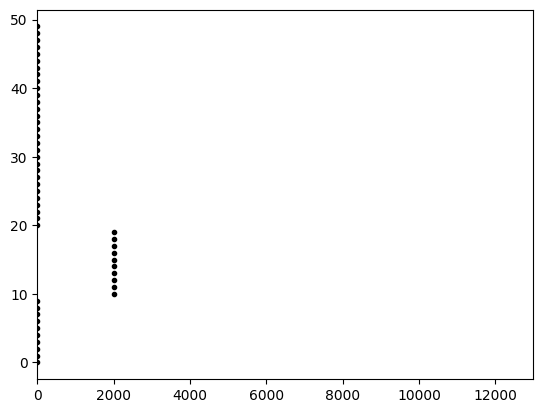

In [4]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)

nstep = 13000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000

seq = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
    
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1


tag = np.zeros(N)
 
#tag[:10] = 1
#tag[25] = 2000

#tag = np.arange(1,nstep,nstep/N)

#tag[:10] = np.arange(1,1000,100)
#tag[10:20] = np.arange(2000,3000,100)

tag[:10] = 1
tag[10:20] = 2000

plt.plot(tag,range(N),'k.')
plt.xlim([0,nstep])
index=[range(0,N),range(N,N + N*N),range(N + N*N,N + N*N +N),range(N + N*N +N,N + N*N +N+N)]

In [5]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [6]:
def plot_all():
    mm = 1/2.54/10 
    fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
    rc('text', usetex=True)
    rc('font',**fontProperties)
    fig = plt.figure(figsize=(180*mm,200*mm), facecolor='w',frameon=False)
    
    ax1 = fig.add_axes([.05,.7,.9,.2]) # [left, bottom, width, height] 
    ax2 = fig.add_axes([.05,.5,.9,.2])
    ax3 = fig.add_axes([.05,.29,.9,.2])


    ax5 = fig.add_axes([.05,.02,.2,.2])
    ax6 = fig.add_axes([.28,.02,.2,.2])
    ax7 = fig.add_axes([.51,.02,.2,.2])
    ax8 = fig.add_axes([.74,.02,.2,.2])
    
    
    im = ax1.imshow(Emat,aspect = nstep/N*2/9,cmap = 'cividis')
    ax1.set_ylabel('Neurons')
    ax1.set_xticklabels('')
    cbar1 = plt.colorbar(im,cax = plt.axes([0, 0.71, 0.01, 0.18]))
    cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=.05,x=4)
    
    im = ax2.imshow(np.maximum(0,r),aspect = nstep/N*2/9,cmap = 'cividis')
    ax2.set_ylabel('Neurons')
    ax2.set_xticklabels('')
    cbar2 = plt.colorbar(im,cax = plt.axes([0, 0.51, 0.01, 0.18]))
    cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.05,x=4)

        
    for n in range(N):
        ax3.plot(r[n,:],'k',linewidth = 1)
    for n in range(10,15):
        ax3.plot(r[n,:],'r',linewidth = 1)
        
    ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
    ax3.set_xlabel('Time (a.u.)')
    ax3.set_ylabel('Firing rate (a.u.)')
    
    ax3.set_xlim([0,nstep])
    h = -1
    for s in range(int(len(seq)/2)):
        ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


    im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
    ax6.set_yticklabels('')
    ax7.set_yticklabels('')
    ax8.set_yticklabels('')

    cbar3 = plt.colorbar(im,cax = plt.axes([0, 0.1, 0.01, 0.18]))
    cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=.05,x=4)
    #plt.savefig('all.pdf')

    #plt.show()

In [7]:
color = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]
color = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]

In [8]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

# Run different seeds, fixed E, get V_list

In [4810]:
threshold = 3

decayL = [1000]
tauwL = [500]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [3]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [4811]:
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [4812]:
threshold = 3

decayL = [800]
tauwL = [600]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [4813]:
# beautiful ordinal
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [4814]:
Nseed = 10
V_list = np.zeros([4,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V
        
    #plot_all()
    #plt.show()

0


KeyboardInterrupt: 

In [ ]:
#np.save("V_list.npy", V_list)
#V_list = np.load('V_list.npy')

In [2331]:
#V_list = np.load('V_list.npy')

In [2332]:
Nseed

10

In [2334]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])

corr_tot

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.6109677 , 0.67874724, 0.85692262, 0.66273943, 0.67294757,
        0.88530045, 0.5413317 , 0.74809044, 0.76242306, 0.86415487],
       [0.55214757, 0.61522177, 0.4345725 , 0.45126002, 0.62959342,
        0.79056512, 0.53381656, 0.70809895, 0.79206107, 0.67096426],
       [0.50514103, 0.56424689, 0.31786056, 0.42000626, 0.64005442,
        0.80789416, 0.54868887, 0.74099437, 0.58376534, 0.61162497]])

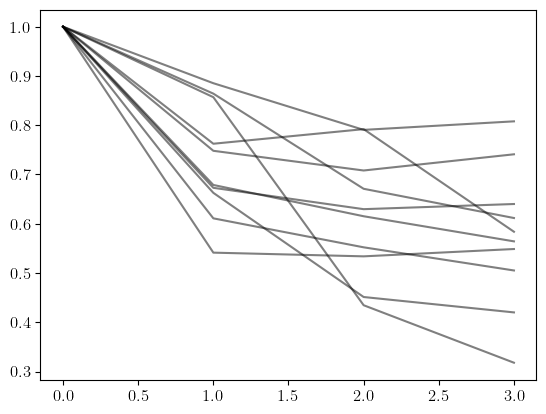

In [2335]:
for seed in range(Nseed):
    plt.plot(corr_tot[:,seed],'k', alpha = .5)

## figure

In [16]:
Nseed = 10

In [17]:
#np.save("V_list.npy", V_list)
V_list = np.load('V_list.npy')

In [18]:
V_list_shuffled = np.copy(V_list)

In [19]:
V_list_shuffled.shape

(4, 50, 10)

In [20]:
for seed in range(Nseed):
    for day in range(4):
        np.random.shuffle(V_list_shuffled[day,:,seed])

In [21]:
V_list[:,0,0]

array([9.93548186e-06, 9.93239638e-06, 9.85165660e-06, 9.68867556e-06])

In [22]:
V_list_shuffled[:,0,0]

array([9.79038095e-06, 1.05838352e+01, 9.86231640e-06, 9.90102188e-06])

In [38]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])
        
corr_tot_shuffled = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot_shuffled[day,seed] = correlation(V_list_shuffled[0,:,seed],V_list_shuffled[day,:,seed])

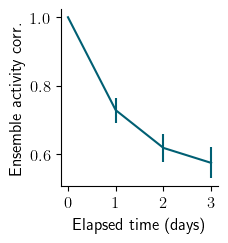

In [41]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corr_tot,axis=1),stats.sem(corr_tot,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr.pdf')

# Ordinal time decoder, run different E, get t_mat

In [4799]:
V_list = np.zeros([4,N])
V_list[0,:] = np.arange(N)
V_list_suffled = np.copy(V_list)
for i in range(N):
    #print(V_list[:,i])
    line = np.copy(V_list[:,i])
    #print(line)
    np.random.shuffle(line)
    V_list_suffled[:,i] = line
    #print(V_list_suffled[:,i])

In [4800]:
V_list[:,21,0]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [4801]:
V_list_suffled[:,21]

array([21.,  0.,  0.,  0.])

In [ ]:
print(V_list[:,:,seed] == V_list_suffled)

In [4815]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))
#L = np.delete(L,[9,11,13,15,16,17,18,19,20,21,22,23],axis = 0)
print(L)

[[0 1 2 3]
 [0 1 3 2]
 [0 2 1 3]
 [0 2 3 1]
 [0 3 1 2]
 [0 3 2 1]
 [1 0 2 3]
 [1 0 3 2]
 [1 2 0 3]
 [1 2 3 0]
 [1 3 0 2]
 [1 3 2 0]
 [2 0 1 3]
 [2 0 3 1]
 [2 1 0 3]
 [2 1 3 0]
 [2 3 0 1]
 [2 3 1 0]
 [3 0 1 2]
 [3 0 2 1]
 [3 1 0 2]
 [3 1 2 0]
 [3 2 0 1]
 [3 2 1 0]]


In [4816]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [4821]:
seedL = range(10)
EL = np.arange(0,3.5,.5)
#EL = [1]
Nseed = len(seedL)

In [4822]:
t_mat = []
t_mat_shuffled = []
V_list = np.zeros([4,N,Nseed])
V_list_suffled = np.zeros([4,N])
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]

    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V

    np.save("V_list.npy", V_list)

    # decoder ordinal
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            #print(V[perm[i],:])
            s += correlation(V[perm[i],:],V[perm[i+1],:])
        s = s
        s_corr.append(s)
    #print(s_corr)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    # shuffle
    
    #V_list_suffled = np.copy(V_list[:,:,seed])
    #np.random.shuffle(V_list_suffled.T)
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_suffled[:,i] = line
    
    #print(V_list[:,:,seed] == V_list_suffled)

    #print(V_list)
    #print(V_list_suffled)
    
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[perm[i],:],V_list_suffled[perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    #plot_all()
    #plt.savefig(str(E)+'all.pdf')

    plt.show()
    




(800, 20, 100, 12, 0.5, 0.0, 2, 1, 1000, 15, 0)
-0.18454384094063173
0.9268830477393216
(800, 20, 100, 12, 0.5, 0.0, 2, 1, 1000, 15, 1)
0.9937982242322005
1.0319731983013327
(800, 20, 100, 12, 0.5, 0.0, 2, 1, 1000, 15, 2)
1.4882543163289759
0.2550125335289293
(800, 20, 100, 12, 0.5, 0.0, 2, 1, 1000, 15, 3)
0.9822166477374817
-1.0007356945049526
(800, 20, 100, 12, 0.5, 0.0, 2, 1, 1000, 15, 4)
-0.5306117816979805
-1.7949496620621699
(800, 20, 100, 12, 0.5, 0.0, 2, 1, 1000, 15, 5)
1.8766064741219721
1.5617210782806428
(800, 20, 100, 12, 0.5, 0.0, 2, 1, 1000, 15, 6)
0.33224599854164777
0.48867086035500135
(800, 20, 100, 12, 0.5, 0.0, 2, 1, 1000, 15, 7)
0.8100541212421033
1.2970720718475524
(800, 20, 100, 12, 0.5, 0.0, 2, 1, 1000, 15, 8)
0.005360799755906541
1.1271068404285316
(800, 20, 100, 12, 0.5, 0.0, 2, 1, 1000, 15, 9)
1.0236235614525304
-1.0104173863732908
(800, 20, 100, 12, 0.5, 0.5, 2, 1, 1000, 15, 0)
-1.1743992204743867
0.6881613156225832
(800, 20, 100, 12, 0.5, 0.5, 2, 1, 1000, 15

In [4823]:
np.save("t_mat_control.npy", t_mat)
np.save("t_mat_shuffled_control.npy", t_mat_shuffled)


In [4824]:
t_mat = np.load("t_mat_control.npy")
t_mat_shuffled = np.load("t_mat_shuffled_control.npy")

In [4825]:
t_mat = np.array(t_mat).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled = np.array(t_mat_shuffled).reshape((len(EL),len(decayL),len(seedL)))

decay = 0
#t_mat = np.abs(t_mat[:,decay,:])
#t_mat_shuffled = np.abs(t_mat_shuffled[:,decay,:])
t_mat = t_mat[:,decay,:]
t_mat_shuffled = t_mat_shuffled[:,decay,:]

In [4826]:
lab = [str(round(idx,2)) for idx in EL]


In [4827]:
t_mat_shuffled

array([[ 0.92688305,  1.0319732 ,  0.25501253, -1.00073569, -1.79494966,
         1.56172108,  0.48867086,  1.29707207,  1.12710684, -1.01041739],
       [ 0.68816132, -1.41982026,  0.99987431, -0.59623374,  1.00831584,
        -0.99316883,  0.20065636,  1.86627124,  1.32135663,  0.33818206],
       [ 0.00272822, -1.97028618,  0.99957283, -1.34730217, -0.23341243,
         1.42948947, -1.03269469,  1.01120997, -0.92127177,  0.70514153],
       [ 1.04656824, -1.06639304,  1.49194877, -0.5932922 ,  0.81964072,
         0.58899999, -0.20203963, -0.79036205, -0.4078391 ,  1.4732748 ],
       [ 1.46242775, -1.29423017, -1.10737523, -0.26681115,  0.77771552,
        -0.12311948, -1.36225716, -1.38368569,  0.93659027,  0.48890759],
       [ 1.6557748 ,  0.47668804, -1.39254209,  1.1837746 , -0.65897836,
         1.29018094, -1.55301628,  1.04616115,  0.16745976, -0.43995855],
       [-0.9948051 ,  0.64046853, -1.61445633,  0.41507078,  0.99056135,
         1.46899478, -1.63704856,  1.0462165 

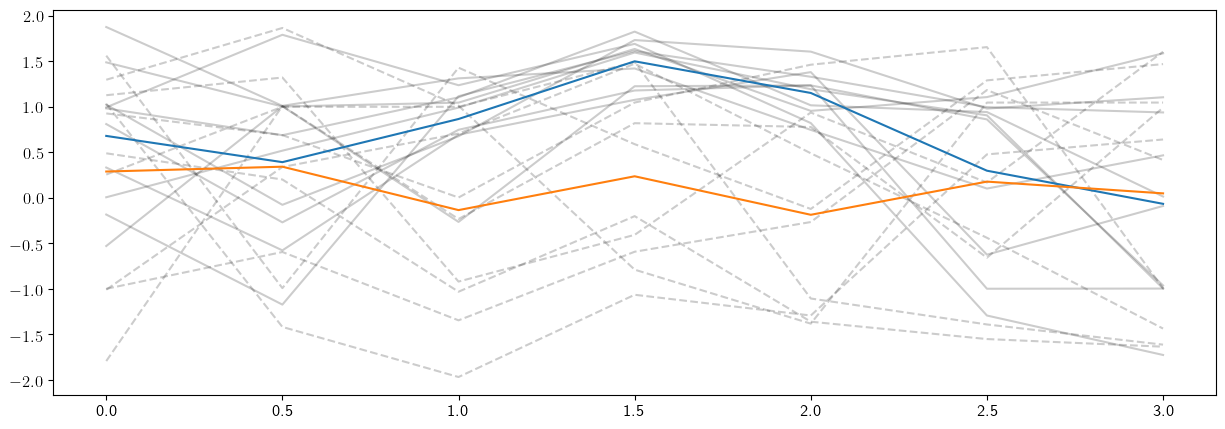

In [4828]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat[:,seed],'k', alpha = .2)
    
for seed in range(Nseed):
    plt.plot(t_mat_shuffled[:,seed],'--k', alpha = .2)
    
plt.plot(np.mean(t_mat,axis = 1))
plt.plot(np.mean(t_mat_shuffled,axis = 1))
plt.xticks(range(len(EL)),lab);

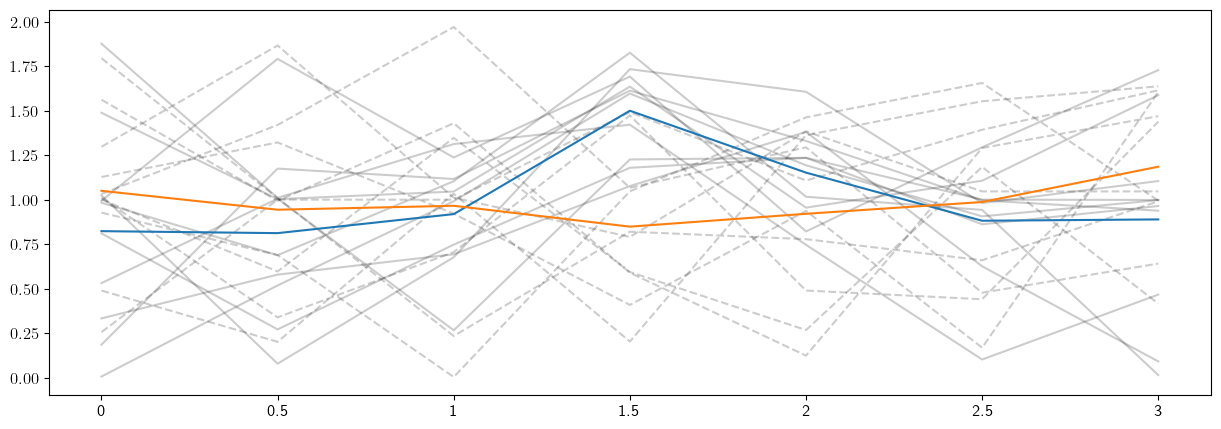

In [2256]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat[:,seed],'k', alpha = .2)
    
for seed in range(Nseed):
    plt.plot(t_mat_shuffled[:,seed],'--k', alpha = .2)
    
plt.plot(np.mean(t_mat,axis = 1))
plt.plot(np.mean(t_mat_shuffled,axis = 1))
plt.xticks(range(len(EL)),lab);

## figure

In [4829]:
EL = [0,.5,1,1.5,2,2.5,3]
Nseed = len(seedL)

In [4830]:
#np.save("t_mat.npy", t_mat)
#np.save("t_mat_shuffled.npy", t_mat_shuffled)
#t_mat = np.load("t_mat.npy")
#t_mat_shuffled = np.load("t_mat_shuffled.npy")

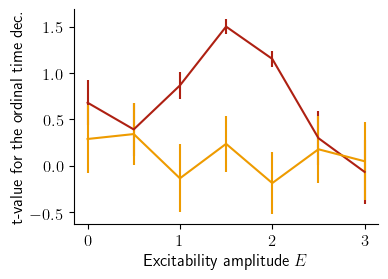

In [4833]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(90*mm,70*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat,axis = 1),stats.sem(t_mat,axis = 1),color = "#ae2012")
ax.errorbar(EL,np.mean(t_mat_shuffled,axis = 1),stats.sem(t_mat_shuffled,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('tVSE.pdf',dpi = 1000)



## figure

In [101]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))


In [98]:
#np.save("V_list.npy", V_list)
V_list = np.load('V_list.npy')

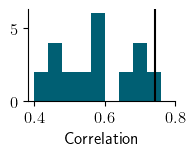

In [105]:
# Ordinal time decoder
decod = []
all_corr_simple = np.zeros((Nseed,len(L)))
for seed in range(Nseed):
    s_corr = []
    p = 0
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list[perm[i],:,seed],V_list[perm[i+1],:,seed])
        s = s/3
        all_corr_simple[seed,p] = s
        p+=1

        
        

seed = 2


mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,30*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.75,.78])


bins = np.arange(.4,.78,.04)
ax.hist(all_corr_simple[seed,:].flatten(),color = color[1], alpha = 1,bins = bins)
ax.axvline(np.mean(all_corr_simple[seed,0]),color = 'k')
#ax.set_ylabel('Count for the ordinal time decoder')
ax.set_xlabel('Correlation')

ax.set_xticks([.4,.6,.8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('hist.pdf')

In [100]:
bins

array([0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76])

In [1419]:
all_corr_simple[seed,0]

0.7421287327379794

# Time decoder

In [803]:
# works well, nice plot and ordinal decoder and decode memory
threshold = 3

decayL = [800]
tauwL = [500]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

In [804]:
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [1082]:
threshold = 3

decayL = [800]
tauwL = [600]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [16]:
# beautiful ordinal
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [1332]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [1333]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:12500] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [1334]:
# main function
def f(yt,t,tag,dt):
    
    global theta
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))

    if t > pause + Nstim*stim + duration + delay*(Nevent-1):
        dWdt = np.zeros((N,N))
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
            
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten()))

    return dydt

In [1335]:
pause + Nstim*stim + duration + delay*(Nevent-1)

12100

In [1336]:
Nseed = 10
V_list = np.zeros([Nseed,2,4,N])
for seed in range(Nseed):
    print(seed)
    np.random.seed(seed)
    
    for day in range(4):
        nstep = 14000
        dt = 1
        IN = 15
        Nstim = 10
        stim = 200
        duration = 100
        pause = 1000
        delay = 3000

        seq = []
        Nevent = day + 1

        for ev in range(Nevent):

            for i in range(Nstim):
                seq.append(pause + i*stim + delay*ev)
                seq.append(pause + i*stim + duration + delay*ev)

        seq.append(13000)
        seq.append(13000 + duration)

        def INPUT(t):
            L = 0
            pol = 1
            for step in seq:
                L += np.tanh(t-step)*pol
                pol *= -1
            return IN * np.ones(N)*L/2 + 1




        ############ RUN ##############



         # initialisation
        r0 = np.zeros(N)
        W0 = np.zeros(N*N)
        exc0 = np.zeros(N)
        exc0 = np.random.normal(0,sigma,N)
        exc0 = np.sqrt(exc0*exc0)
        #exc0 = np.random.uniform(0,sigma,N)
        theta0 = np.zeros(N)

        Emat = def_Emat(E,exc0)

        # run
        y = run(INPUT)
        exc = y[index[2][:],:]
        r = y[index[0][:],:]
        theta = y[index[3][:],:]

        V_list[seed,0,day,:] =  r[:,pause + Nstim*stim + delay*day - 100]
        V_list[seed,1,day,:] =  r[:,13100]

        #plot_all()
        


0
1
2
3
4
5
6
7
8
9


In [1337]:
decod = np.zeros((Nseed,4))
for seed in range(Nseed):
    for day in range(4):
        corr = []
        for day_try in range(4):
            corr.append(correlation(V_list[seed,0,day,:],V_list[seed,1,day_try,:]))
    
        decod[seed,day] = np.where(corr == np.max(corr))[0]
decod

array([[0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.]])

In [1338]:
V_list_shuffled = np.copy(V_list)

decod_shuffled = np.zeros((Nseed,4))
for seed in range(10):
    V = np.copy(V_list_shuffled[seed,1,:,:])
    np.random.shuffle(V)
    V_list_shuffled[seed,1,:,:] = V
    
    for day in range(4):
        corr = []
        for day_try in range(4):
            corr.append(correlation(V_list_shuffled[seed,1,day,:],V_list_shuffled[seed,0,day_try,:]))
        #print(corr)
        decod_shuffled[seed,day] = np.where(corr == np.max(corr))[0]
decod_shuffled

array([[3., 0., 2., 1.],
       [2., 3., 0., 1.],
       [1., 2., 0., 3.],
       [2., 1., 3., 0.],
       [2., 1., 3., 0.],
       [3., 2., 0., 1.],
       [2., 0., 3., 1.],
       [0., 3., 2., 1.],
       [2., 1., 0., 3.],
       [2., 1., 3., 0.]])

In [1339]:
error = np.zeros([Nseed,4])
error_shuffled = np.zeros([Nseed,4])
for seed in range(Nseed):
    error[seed,:] = decod[seed,:] - np.arange(4)
    error_shuffled[seed,:] = decod_shuffled[seed,:] - np.arange(4)

## figure

In [84]:
#np.save("error.npy", error)
#np.save("error_shuffled.npy", error_shuffled)
error = np.load('error.npy')
error_shuffled = np.load('error_shuffled.npy')

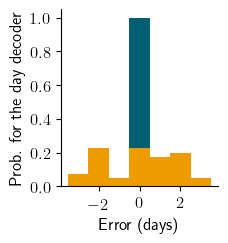

In [114]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])


ax.hist(error.flatten(),bins = np.arange(-3.5,4.5,1),density = True, color = color[1], alpha = 1)
ax.hist(error_shuffled.flatten(),bins = np.arange(-3.5,4.5,1),density = True, color = color[5], alpha = 1)
#plt.legend(['real','shuffled'])
ax.set_ylabel('Prob. for the day decoder')
ax.set_xlabel('Error (days)')
ax.set_xticks([-2,0,2])
ax.set_yticks([0,.2,.4,.6,.8,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('time_decoder.pdf')


# Memory decoder

In [4782]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    thetaL = np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0,Wout0,rout0,thetaout0))
    y = np.zeros((len(y0),nstep))
    routbis = np.zeros((4,nstep))

    y[:,0] = y0
    
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [4783]:
# main function
routbis = np.zeros((4,nstep))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    Wout = yt[index[4]].reshape((1,N))
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T
    thetaout = yt[index[6]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    rout = Wout.dot(r)[0]
    routbis[0,t] = rout
    dWoutdt = (1 - np.sum(Wout))*r.T * rout/200 - Wout/1000
    #dWoutdt = r.T * rout/1000 - Wout/1000
    #dWoutdt = (rout * (rout-thetaout) * r.T )/ 4000
    #dWoutdt = np.multiply(dWoutdt,Wout<10)
    dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout<=0,dWoutdt<0)))
    #dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout>=10,dWoutdt>0)))
    #droutdt = (Wout.dot(r) - rout) /1
    #dthetaoutdt = ((rout*rout)/.2 - thetaout)/10
    dthetaoutdt = np.zeros((1))
    droutdt = np.zeros((1))
    S.append(np.sum(Wout))
    
    if t > 3000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[1,t] = Wout.dot(r)[0]

    if t > 6000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[2,t] = Wout.dot(r)[0]
        
    if t > 9000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[3,t] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten(),
                           droutdt.flatten(),
                           dthetaoutdt.flatten()))

    return dydt

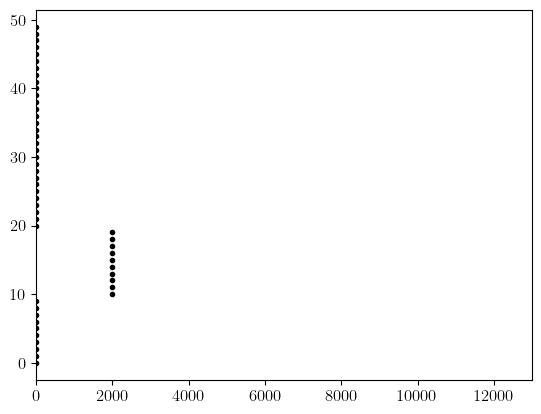

In [4755]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)
rout0 = np.zeros(1)
Wout0 = np.zeros(N) + .001
thetaout0 = np.zeros(1)

nstep = 13000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000

seq = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
    
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1


tag = np.zeros(N)
 
#tag[:10] = 1
#tag[25] = 2000

#tag = np.arange(1,nstep,nstep/N)

#tag[:10] = np.arange(1,1000,100)
#tag[10:20] = np.arange(2000,3000,100)

tag[:10] = 1
tag[10:20] = 2000

plt.plot(tag,range(N),'k.')
plt.xlim([0,nstep])
         
index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N),
         range(N + N*N +N+N+N,N + N*N +N+N+N+1),
         range(N + N*N +N+N+N+1,N + N*N +N+N+N+1+1)]
         
         
         
         
         

(2000.0, 3200.0)

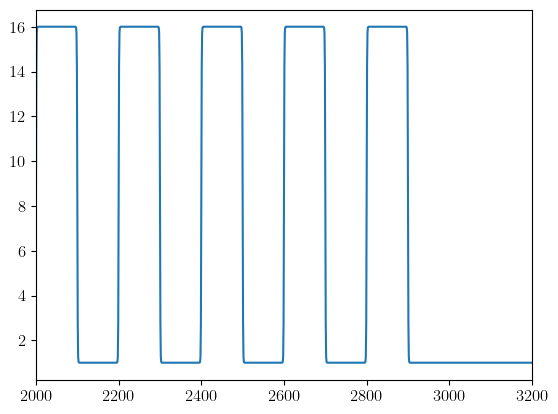

In [4756]:
x=range(nstep)
plt.plot(x,[INPUT(t)[0] for t in x])
plt.xlim(2000,3200)

In [4757]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [4758]:
# works well, nice plot and ordinal decoder and decode memory
threshold = 3

decayL = [800]
tauwL = [500]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [3]

In [4759]:
threshold = 3

decayL = [900]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [3]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [4760]:
threshold = 3

decayL = [800]
tauwL = [600]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [3]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [4761]:
# beautiful ordinal
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
#EL = [3]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [2]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [4762]:
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)

exc0

array([0.30017032, 0.35224985, 1.1425182 , 0.34934272, 0.20889423,
       0.58662319, 0.83898341, 0.93110208, 0.28558733, 0.88514116,
       0.75439794, 1.25286816, 0.51292982, 0.29809284, 0.48851815,
       0.07557171, 1.13162939, 1.51981682, 2.18557541, 1.39649634,
       1.44411381, 0.50446586, 0.16003707, 0.87616892, 0.31563495,
       2.02220122, 0.30620401, 0.82797464, 0.23009474, 0.76201118,
       0.22232814, 0.20075807, 0.18656139, 0.41005165, 0.19829972,
       0.11900865, 0.67066229, 0.37756379, 0.12182127, 1.12948391,
       1.19891788, 0.18515642, 0.37528495, 0.63873041, 0.42349435,
       0.07734007, 0.34385368, 0.04359686, 0.62000084, 0.69803203])

(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 2)


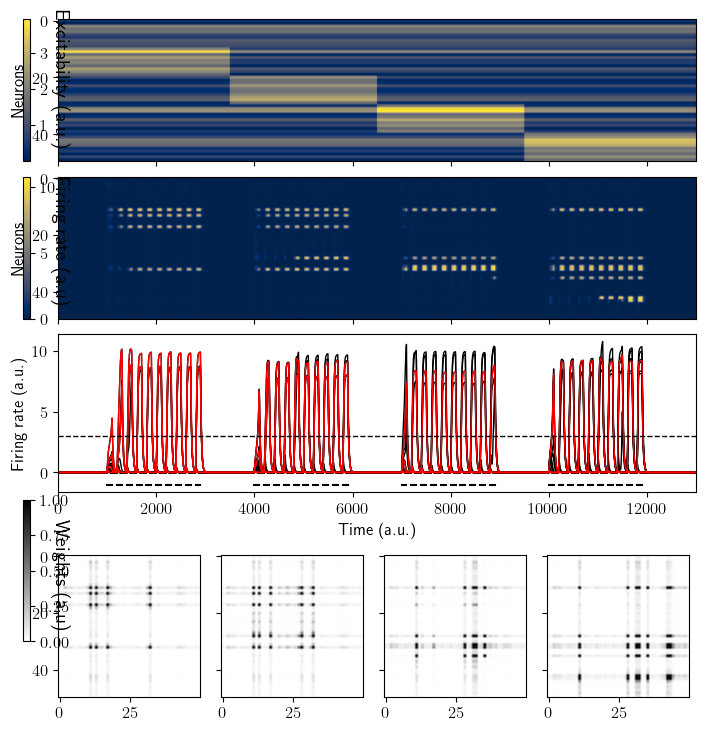

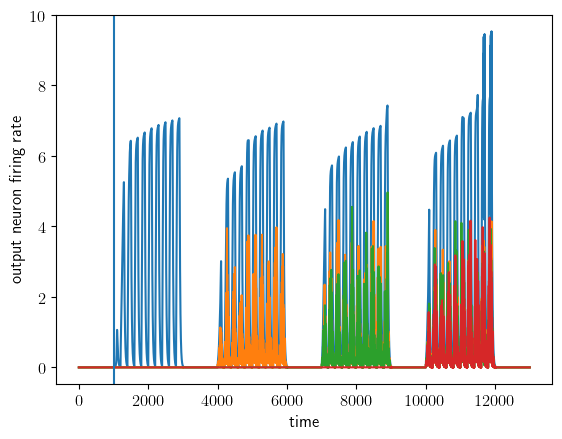

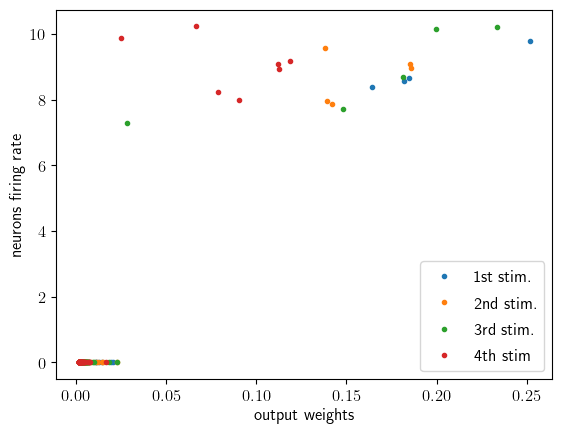

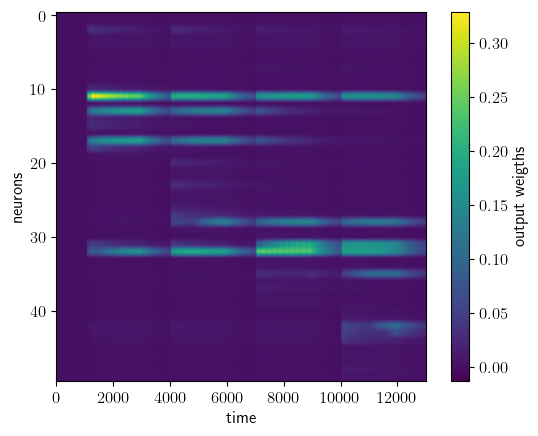

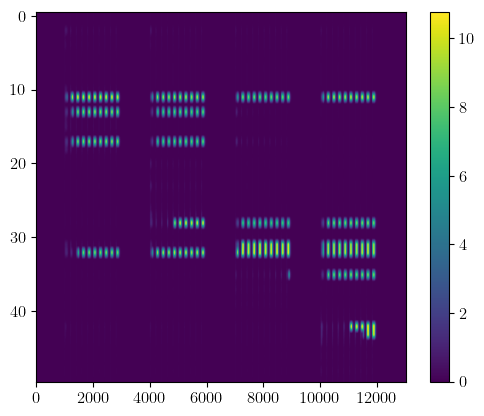

In [4731]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    rout = y[index[5][:],:] 
    
    
    plot_all()
    #plt.savefig('all.pdf')

    plt.show()
    
    
    # decode memory rate
    plt.figure()
    plt.plot(routbis[0,:]);
    plt.plot(routbis[1,:]);
    plt.plot(routbis[2,:]);
    plt.plot(routbis[3,:]);
    plt.xlabel('time')
    plt.ylabel('output neuron firing rate')
    plt.axvline(x = 1000)
    plt.savefig('decode_rate.png',dpi = 500)
    plt.show()

    # weights vs rates
    for t in [2900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [5900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [8900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [11900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    plt.legend(['1st stim.','2nd stim.','3rd stim.','4th stim'])
    plt.xlabel('output weights')
    plt.ylabel('neurons firing rate')
    plt.savefig('decode_corr.png',dpi = 500)
    plt.show()

    
    # weights
    plt.figure()
    plt.imshow(Wout,aspect = nstep/N)
    cbar = plt.colorbar()
    cbar.set_label('output weigths')
    plt.ylabel('neurons')
    plt.xlabel('time')
    plt.savefig('weights.png',dpi = 500)
    plt.show()

    # rates
    plt.figure()
    plt.imshow(r,aspect = nstep/N)
    plt.colorbar()
    plt.show()





## figure

In [417]:
threshold = 5

In [418]:
active = r[:,2850]>threshold

In [419]:
active = np.where(active)[0]

In [420]:
L = np.array(range(N))
for l in active:
    L = np.delete(L,l)

In [421]:
L = [i for i in range(N) if i not in active]

In [422]:
active

array([10, 11, 13, 14, 15, 17, 18])

In [34]:
cmap = reversed(["20331a","33512a","446c37","558745","66a253","7cb36b","94c186","abcea1","c3dcbc","dbead7"])
cmap2 = ["ffffff","005F73"]

In [424]:
import matplotlib.colors as mcolors
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

cmap = get_continuous_cmap(cmap)
cmap2 = get_continuous_cmap(cmap2)

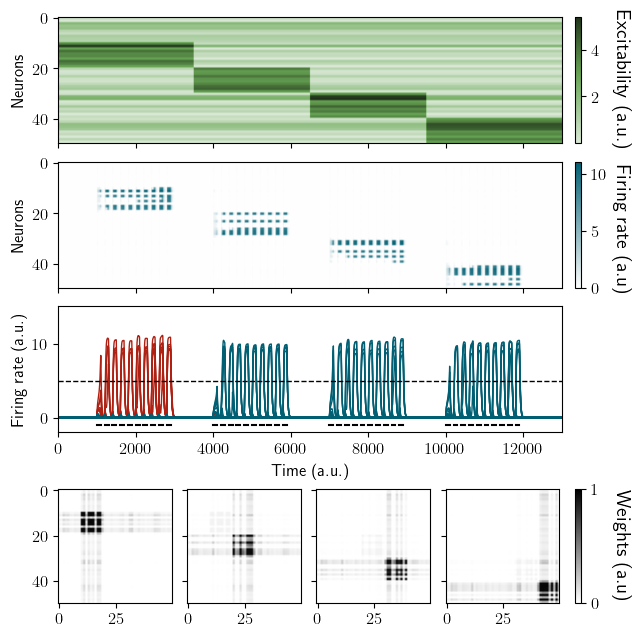

In [425]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(160*mm,160*mm), facecolor='w',frameon=False)

ax1 = fig.add_axes([.04,.79,.88,.2]) # [left, bottom, width, height] 
ax2 = fig.add_axes([.04,.56,.88,.2])
ax3 = fig.add_axes([.08,.33,.8,.2])

w = .18
ax5 = fig.add_axes([.08,.06,w,w])
ax6 = fig.add_axes([.285,.06,w,w])
ax7 = fig.add_axes([.49,.06,w,w])
ax8 = fig.add_axes([.695,.06,w,w])


im = ax1.imshow(Emat,aspect = nstep/N*2/8,cmap = cmap)
ax1.set_ylabel('Neurons')
ax1.set_xticklabels('')
cbar1 = plt.colorbar(im,cax = plt.axes([.9, 0.79, 0.01, 0.2])) # [left, bottom, width, height] 
cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=-.09,x=6)

im = ax2.imshow(np.maximum(0,r),aspect = nstep/N*2/8,cmap = cmap2)
ax2.set_ylabel('Neurons')
ax2.set_xticklabels('')
cbar2 = plt.colorbar(im,cax = plt.axes([.9, 0.56, 0.01, 0.2])) # [left, bottom, width, height] 
cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=-.09,x=6)

for n in active:
    ax3.plot(r[n,:],color[8],linewidth = 1)
for n in L:
    ax3.plot(r[n,:],color[1],linewidth = 1)


ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
ax3.set_xlabel('Time (a.u.)')
ax3.set_ylabel('Firing rate (a.u.)')

ax3.set_xlim([0,nstep])
ax3.set_ylim([-2,15])

h = -1
for s in range(int(len(seq)/2)):
    ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
ax6.set_yticklabels('')
ax7.set_yticklabels('')
ax8.set_yticklabels('')

cbar3 = plt.colorbar(im,cax = plt.axes([.9, 0.06, 0.01, 0.18]))
cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=-.02,x=6)
cbar3.set_ticks([0,1])
plt.savefig('all.pdf')

## figure

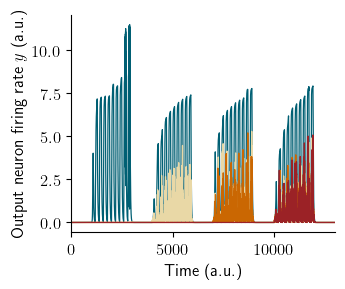

In [426]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(80*mm,70*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.16,0.18,.84,.79])

lw = .9
ax.plot(routbis[0,:],color[1],linewidth=lw);
ax.plot(routbis[1,:],color[4],linewidth=lw);
ax.plot(routbis[2,:],color[6],linewidth=lw);
ax.plot(routbis[3,:],color[9],linewidth=lw);

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,13000])
plt.savefig('decode_rate.pdf')




## figure

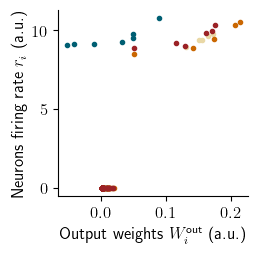

In [427]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(70*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


for t in [2900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[1])
for t in [5900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[4])
for t in [8900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[6])
for t in [11900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[9])

ax.set_xlabel(r'Output weights $W^{\text{out}}_i$ (a.u.)')
ax.set_ylabel(r'Neurons firing rate $r_i$ (a.u.)')
ax.set_yticks([0,5,10])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf')

## figure

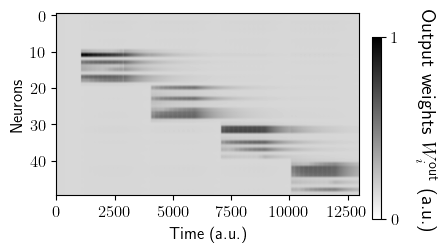

In [428]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(110*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.12,0.2,.7,.77])


ax.imshow(Wout, aspect='auto', cmap = 'binary')
cbar3 = plt.colorbar(im,cax = plt.axes([.85, 0.1, 0.02, 0.77]))
cbar3.ax.set_title(r'Output weights $W^{\text{out}}_i$ (a.u.)', rotation=270,loc='left',y=-.1,x=5)
cbar3.set_ticks([0,1])


ax.set_ylabel('Neurons')
ax.set_xlabel('Time (a.u.)')

plt.savefig('weights.pdf')

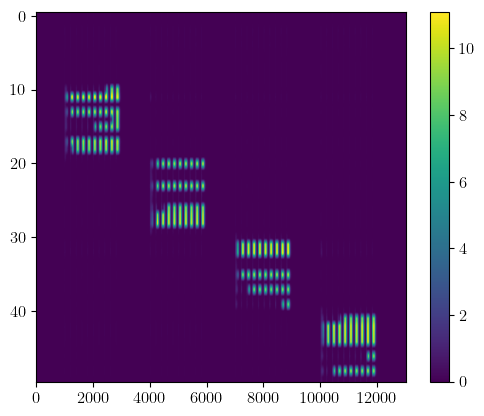

In [429]:
plt.figure()
plt.imshow(r,aspect = nstep/N)
plt.colorbar()

In [430]:
r[:,2900]

array([7.35757819e-04, 6.15522147e-04, 1.99010527e-03, 1.46546847e-03,
       1.57971302e-03, 8.82911318e-04, 7.64481707e-04, 1.17719094e-03,
       1.04052293e-03, 9.31863380e-04, 9.12804249e+00, 1.07459138e+01,
       3.68546547e-03, 9.50692138e+00, 9.07202114e+00, 9.14304261e+00,
       3.59756202e-03, 9.77185485e+00, 9.23701574e+00, 3.57019327e-03,
       9.09322912e-04, 6.48930904e-04, 6.82329152e-04, 9.90059374e-04,
       7.09761662e-04, 6.75529072e-04, 8.09433017e-04, 1.13511580e-03,
       1.30553615e-03, 6.47950574e-04, 6.86494155e-04, 2.10988653e-03,
       2.37133589e-03, 6.34351714e-04, 7.20309634e-04, 1.26061051e-03,
       7.64140074e-04, 8.84695324e-04, 5.96760139e-04, 7.77647579e-04,
       7.01321298e-04, 8.53911542e-04, 1.65326846e-03, 1.53252218e-03,
       1.33944588e-03, 7.08712744e-04, 8.00655765e-04, 6.12754824e-04,
       8.73834958e-04, 6.26010489e-04])

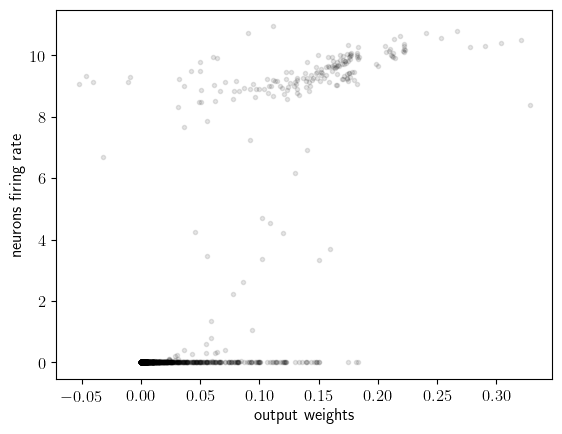

In [431]:
# weights vs rates
for t in np.arange(100,nstep,200):
    plt.plot(Wout[:,t],r[:,t],'k.', alpha = .1)
plt.xlabel('output weights')
plt.ylabel('neurons firing rate')
plt.savefig('decode_corr.png',dpi = 500)
plt.show()

## figure


In [432]:
for t in [2900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[1])
for t in [5900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[4])
for t in [8900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[6])
for t in [11900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[9])

In [433]:
W1 = Wout[:,2900]
W2 = Wout[:,5900]
W3 = Wout[:,8900]
W4 = Wout[:,11900]

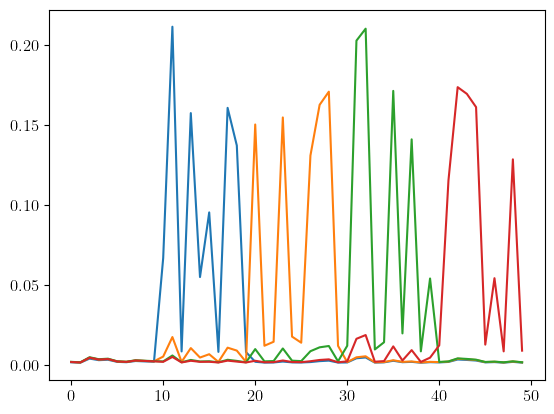

In [434]:
plt.plot(W1)
plt.plot(W2)
plt.plot(W3)
plt.plot(W4)

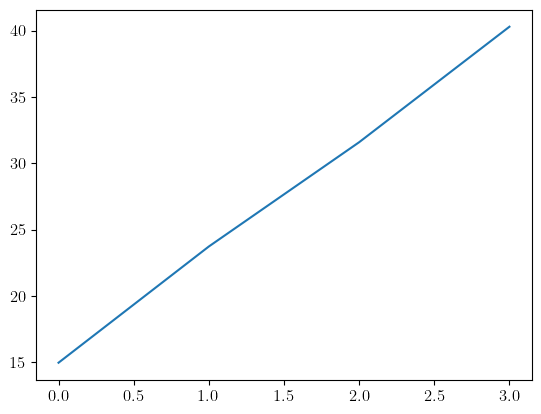

In [435]:
plt.plot([sum(np.multiply(W1,pos)),sum(np.multiply(W2,pos)),sum(np.multiply(W3,pos)),sum(np.multiply(W4,pos))])

In [436]:
pos = np.array(range(N))
pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [439]:
seedL = range(10)
WoutL = np.zeros((len(seedL),4))
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    
    W1 = Wout[:,2950]
    W2 = Wout[:,5950]
    W3 = Wout[:,8950]
    W4 = Wout[:,11950]

    WoutL[seed,:] = np.array([sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)])
    

(800, 20, 100, 12, 0.5, 3, 2, 1, 1000, 15, 0)
(800, 20, 100, 12, 0.5, 3, 2, 1, 1000, 15, 1)
(800, 20, 100, 12, 0.5, 3, 2, 1, 1000, 15, 2)
(800, 20, 100, 12, 0.5, 3, 2, 1, 1000, 15, 3)
(800, 20, 100, 12, 0.5, 3, 2, 1, 1000, 15, 4)
(800, 20, 100, 12, 0.5, 3, 2, 1, 1000, 15, 5)
(800, 20, 100, 12, 0.5, 3, 2, 1, 1000, 15, 6)
(800, 20, 100, 12, 0.5, 3, 2, 1, 1000, 15, 7)
(800, 20, 100, 12, 0.5, 3, 2, 1, 1000, 15, 8)
(800, 20, 100, 12, 0.5, 3, 2, 1, 1000, 15, 9)


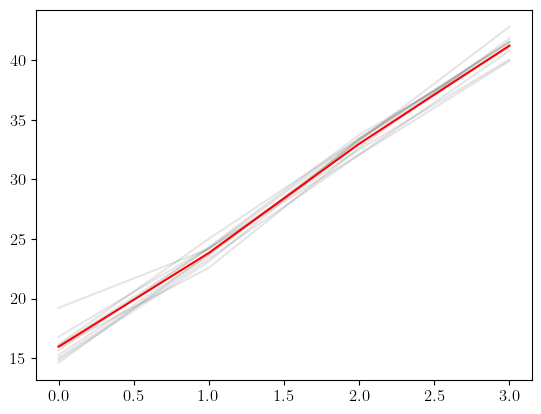

In [440]:
for i in range(10):
    plt.plot(WoutL[i,:],'k',alpha=.1)
plt.plot(np.mean(WoutL,axis=0),'r')

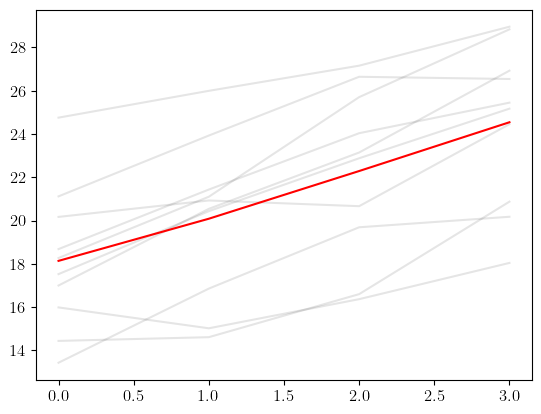

In [29]:
for i in range(10):
    plt.plot(WoutL[i,:],'k',alpha=.1)
plt.plot(np.mean(WoutL,axis=0),'r')

In [30]:
WoutLshuffled = np.copy(WoutL)
np.random.shuffle(WoutLshuffled.T)


In [31]:
WoutL

array([[17.52316777, 20.43207954, 22.87754112, 25.16960558],
       [14.43614135, 14.60848128, 16.59771255, 20.87209374],
       [18.2672715 , 21.09934652, 25.70268165, 28.835374  ],
       [16.99646609, 20.53978735, 23.14264423, 26.92605706],
       [21.11689195, 23.92722625, 26.64337614, 26.54146951],
       [15.98408315, 15.01921273, 16.36526766, 18.04012788],
       [13.42798403, 16.85401495, 19.68781605, 20.17347439],
       [24.75475706, 25.99395943, 27.15653944, 28.95711925],
       [20.16728762, 20.9265379 , 20.66251965, 24.45181255],
       [18.67962372, 21.43144724, 24.03565211, 25.44735879]])

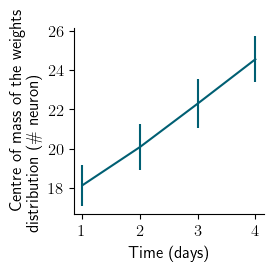

In [32]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(70*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar([1,2,3,4],np.mean(WoutL,axis=0),stats.sem(WoutL),color = color[1])


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks([1,2,3,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf')



## Revision: read-out vs drift rate

In [115]:
seedL = range(100)
Nshuffle = 50

corrL = np.zeros((len(seedL),4))
routL = np.zeros((len(seedL),4))
rout_shuffleL = np.zeros((len(seedL),Nshuffle,4))
rout_init_shuffle = np.zeros((len(seedL),Nshuffle,4))
rout_init = np.zeros((len(seedL),4))

CoML = np.zeros((len(seedL),4))
pos = np.array(range(N))

In [ ]:
for seed in seedL:
    print(seed)
    for shuffle in range(Nshuffle):
        
        routbis = np.zeros((4,nstep))
        
         # initialisation
        np.random.seed(seed)
        r0 = np.zeros(N)
        W0 = np.zeros(N*N)
        exc0 = np.zeros(N)
        exc0 = np.random.normal(0,sigma,N)
        exc0 = np.sqrt(exc0*exc0)
        #exc0 = np.random.uniform(0,sigma,N)
        theta0 = np.zeros(N)

        Emat = def_Emat(E,exc0)

        # run
        np.random.seed(100*(seed+1) + shuffle)
        y = run(INPUT)
        exc = y[index[2][:],:]
        r = y[index[0][:],:]
        theta = y[index[3][:],:]
        Wout = y[index[4][:],:]

        V0 = r[:,2900]
        V1 = r[:,5900]
        V2 = r[:,8900]
        V3 = r[:,11900]
        rout_0 = Wout[:,2900].reshape((1,N)).dot(V0)[0]
        rout_1 = Wout[:,5900].reshape((1,N)).dot(V1)[0]
        rout_2 = Wout[:,8900].reshape((1,N)).dot(V2)[0]
        rout_3 = Wout[:,11900].reshape((1,N)).dot(V3)[0]
        
        routL[seed,:] = [rout_0,rout_1,rout_2,rout_3]

        corrL[seed,:] = [correlation(V0,V0),correlation(V0,V1),correlation(V0,V2),correlation(V0,V3)]
        W1 = Wout[:,2900]
        W2 = Wout[:,5900]
        W3 = Wout[:,8900]
        W4 = Wout[:,11900]
        CoML[seed,:] = [sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)]

        rout_shuffleL[seed,shuffle,:] = [np.mean(routbis[0,:]),np.mean(routbis[1,:]),np.mean(routbis[2,:]),np.mean(routbis[3,:])]
        
        rout_init_shuffle[seed,shuffle,:] = [routbis[0,1100],
                                             routbis[1,4100],
                                             routbis[2,7100],
                                             routbis[3,10100]]
        
        rout_init[seed,:] = [Wout[:,1100].reshape((1,N)).dot(r[:,1100])[0],
                            Wout[:,4100].reshape((1,N)).dot(r[:,4100])[0],
                            Wout[:,7100].reshape((1,N)).dot(r[:,7100])[0],
                            Wout[:,10100].reshape((1,N)).dot(r[:,10100])[0]]
        

In [116]:


#np.save('corrL.npy', corrL)
#np.save('routL.npy', routL)
#np.save('rout_shuffleL.npy', rout_shuffleL)
#np.save('rout_init_shuffle.npy', rout_init_shuffle)
#np.save('rout_init.npy', rout_init)
#np.save('CoML.npy', CoML)


corrL = np.load('corrL.npy', )
routL = np.load('routL.npy', )
rout_shuffleL = np.load('rout_shuffleL.npy', )
rout_init_shuffle = np.load('rout_init_shuffle.npy', )
rout_init = np.load('rout_init.npy', )
CoML = np.load('CoML.npy', )

In [117]:
rout_shuffle_mean = np.mean(rout_shuffleL,axis = 1)
rout_init_shuffle_mean = np.mean(rout_init_shuffle,axis = 1)

In [118]:
# AVG on shuffle and all time + ratio 
#r_normed = np.zeros((100,4))
#for seed in range(100):
#    for day in range(4):
#        r_normed[seed,day] = rout_shuffle_mean[seed,0]/rout_shuffle_mean[seed,1]
        
# AVG on shuffle + ratio
#r_normed = np.divide(rout_init,rout_init_shuffle_mean)

# AVG on shuffle + contrast
#r_normed = np.divide(rout_init - rout_init_shuffle_mean,rout_init + rout_init_shuffle_mean)

# AVG on shuffle + difference
#r_normed = rout_init - rout_init_shuffle_mean

# ... + AVG on shuffle
r_normed = np.zeros((len(seedL),Nshuffle,4))
for s in range(Nshuffle):
    # ratio ...
    r_normed[:,s,:] = np.divide(rout_init,rout_init_shuffle[:,s,:])
    # contrast ...
    #r_normed[:,s,:] = np.divide(rout_init-rout_init_shuffle[:,s,:],rout_init+rout_init_shuffle[:,s,:])
    # difference ... (same as AVG + difference)
    #r_normed[:,s,:] = rout_init-rout_init_shuffle[:,s,:]
r_normed = np.mean(r_normed,axis = 1)

drift = np.sum(1-corrL[:,:],1)
drift2= np.max(1-corrL,1)

In [119]:
X = np.sum(1-corrL[:,0:],1).reshape(-1,1)
Y = np.sum(r_normed[:,0:],axis = 1)
X = np.sum(1-corrL[:,1:],1).reshape(-1,1)
Y = np.sum(r_normed[:,1:],axis = 1)


In [120]:
reg = LinearRegression().fit(X,Y)

r = reg.score(X, Y)
a = reg.coef_[0]
b = reg.intercept_

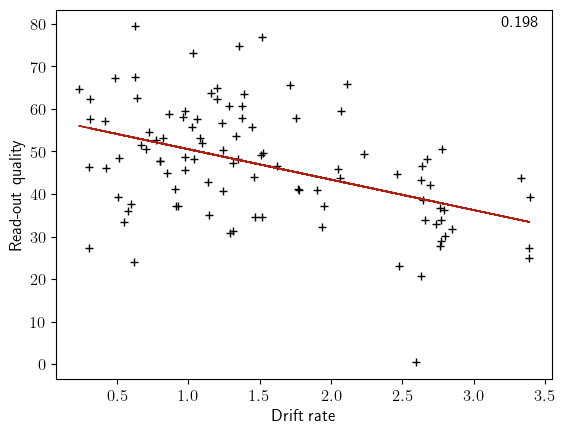

In [129]:
plt.plot(X,Y,'+',color = 'k')
plt.plot(X,a * X + b,color = '#AE2012',linewidth = 1)
plt.xlabel('Drift rate')
plt.ylabel('Read-out quality')
plt.text(max(X)*.94,max(Y),str(round(r,3)));
plt.savefig('readVSdrift.pdf')

Text(0, 0.5, 'Initial y response')

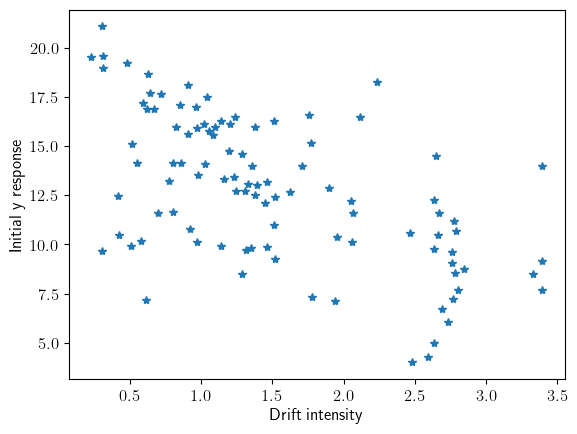

In [ ]:
plt.plot(drift,np.sum(rout_init,axis = 1),'*')

plt.xlabel('Drift intensity')
plt.ylabel('Initial y response')

Text(0, 0.5, 'Mean response of y all days, no shuffle')

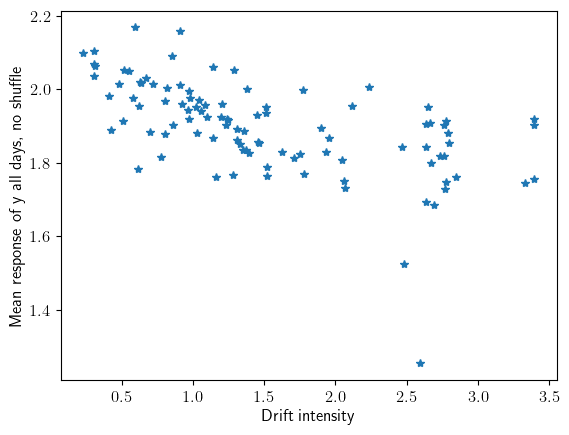

In [215]:
plt.plot(drift,rout_shuffle_mean[:,0],'*')
#plt.plot(np.min(corrL,1),np.sum(r_normed,axis = 1),'*')


plt.xlabel('Drift intensity')
plt.ylabel('Mean response of y all days, no shuffle')

In [124]:
CoML

array([[17.52316777, 20.43207954, 22.87754112, 25.16960558],
       [14.43614135, 14.60848128, 16.59771255, 20.87209374],
       [18.2672715 , 21.09934652, 25.70268165, 28.835374  ],
       [16.99646609, 20.53978735, 23.14264423, 26.92605706],
       [21.11689195, 23.92722625, 26.64337614, 26.54146951],
       [15.98408315, 15.01921273, 16.36526766, 18.04012788],
       [13.42798403, 16.85401495, 19.68781605, 20.17347439],
       [24.75475706, 25.99395943, 27.15653944, 28.95711925],
       [20.16728762, 20.9265379 , 20.66251965, 24.45181255],
       [18.67962372, 21.43144724, 24.03565211, 25.44735879]])

Text(0, 0.5, 'CoM drift')

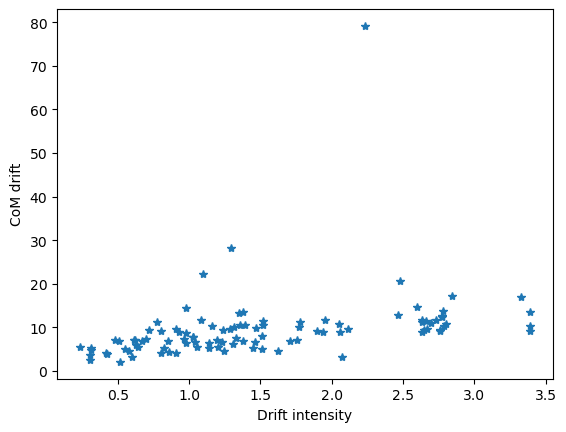

In [202]:
plt.plot(drift,CoML[:,3]-CoML[:,0],'*')

plt.xlabel('Drift intensity')
plt.ylabel('CoM drift')

## Revision: read-out vs E

In [876]:
seedL = range(10)
Nshuffle = 10
EL = [0,.5,1,1.5,2,2.5,3]

corrL = np.zeros((len(seedL),4,len(EL)))
routL = np.zeros((len(seedL),4,len(EL)))
rout_shuffleL = np.zeros((len(seedL),Nshuffle,4,len(EL)))
rout_init_shuffle = np.zeros((len(seedL),Nshuffle,4,len(EL)))
rout_init = np.zeros((len(seedL),4,len(EL)))
CoML = np.zeros((len(seedL),4,len(EL)))

pos = np.array(range(N))

In [879]:
for c in range(len(EL)):
    E = EL[c]
    for seed in seedL:
        print([E,seed])
        for shuffle in range(Nshuffle):
            routbis = np.zeros((4,nstep))

             # initialisation
            np.random.seed(seed)
            r0 = np.zeros(N)
            W0 = np.zeros(N*N)
            exc0 = np.zeros(N)
            exc0 = np.random.normal(0,sigma,N)
            exc0 = np.sqrt(exc0*exc0)
            #exc0 = np.random.uniform(0,sigma,N)
            theta0 = np.zeros(N)

            Emat = def_Emat(E,exc0)

            # run
            np.random.seed(100*(seed+1) + shuffle)
            y = run(INPUT)
            exc = y[index[2][:],:]
            r = y[index[0][:],:]
            theta = y[index[3][:],:]
            Wout = y[index[4][:],:]

            V0 = r[:,2900]
            V1 = r[:,5900]
            V2 = r[:,8900]
            V3 = r[:,11900]
            rout_0 = Wout[:,2900].reshape((1,N)).dot(V0)[0]
            rout_1 = Wout[:,5900].reshape((1,N)).dot(V1)[0]
            rout_2 = Wout[:,8900].reshape((1,N)).dot(V2)[0]
            rout_3 = Wout[:,11900].reshape((1,N)).dot(V3)[0]

            routL[seed,:,c] = [rout_0,rout_1,rout_2,rout_3]

            corrL[seed,:,c] = [correlation(V0,V0),correlation(V0,V1),correlation(V0,V2),correlation(V0,V3)]
            W1 = Wout[:,2900]
            W2 = Wout[:,5900]
            W3 = Wout[:,8900]
            W4 = Wout[:,11900]
            CoML[seed,:,c] = [sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)]

            rout_shuffleL[seed,shuffle,:,c] = [np.mean(routbis[0,:]),np.mean(routbis[1,:]),np.mean(routbis[2,:]),np.mean(routbis[3,:])]

            rout_init_shuffle[seed,shuffle,:,c] = [routbis[0,1100],
                                                 routbis[1,4100],
                                                 routbis[2,7100],
                                                 routbis[3,10100]]

            rout_init[seed,:,c] = [Wout[:,1100].reshape((1,N)).dot(r[:,1100])[0],
                                Wout[:,4100].reshape((1,N)).dot(r[:,4100])[0],
                                Wout[:,7100].reshape((1,N)).dot(r[:,7100])[0],
                                Wout[:,10100].reshape((1,N)).dot(r[:,10100])[0]]
        

[0, 0]
[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 5]
[0, 6]
[0, 7]
[0, 8]
[0, 9]
[0.5, 0]
[0.5, 1]
[0.5, 2]
[0.5, 3]
[0.5, 4]
[0.5, 5]
[0.5, 6]
[0.5, 7]
[0.5, 8]
[0.5, 9]
[1, 0]
[1, 1]
[1, 2]
[1, 3]
[1, 4]
[1, 5]
[1, 6]
[1, 7]
[1, 8]
[1, 9]
[1.5, 0]
[1.5, 1]
[1.5, 2]
[1.5, 3]
[1.5, 4]
[1.5, 5]
[1.5, 6]
[1.5, 7]
[1.5, 8]
[1.5, 9]
[2, 0]
[2, 1]
[2, 2]
[2, 3]
[2, 4]
[2, 5]
[2, 6]
[2, 7]
[2, 8]
[2, 9]
[2.5, 0]
[2.5, 1]
[2.5, 2]
[2.5, 3]
[2.5, 4]
[2.5, 5]
[2.5, 6]
[2.5, 7]
[2.5, 8]
[2.5, 9]
[3, 0]
[3, 1]
[3, 2]
[3, 3]
[3, 4]
[3, 5]
[3, 6]
[3, 7]
[3, 8]
[3, 9]


In [211]:
np.save('corrL_vsE.npy', corrL)
np.save('routL_vsE.npy', routL)
np.save('rout_shuffleL_vsE.npy', rout_shuffleL)
np.save('rout_init_shuffle_vsE.npy', rout_init_shuffle)
np.save('rout_init_vsE.npy', rout_init)
np.save('CoML_vsE.npy', CoML)


#corrL = np.load('corrL_vsE.npy', )
#routL = np.load('routL_vsE.npy', )
#rout_shuffleL = np.load('rout_shuffleL_vsE.npy', )
#rout_init_shuffle = np.load('rout_init_shuffle_vsE.npy', )
#rout_init = np.load('rout_init_vsE.npy', )
#CoML = np.load('CoML_vsE.npy', )

In [212]:
rout_shuffle_mean = np.mean(rout_shuffleL,axis = 1)
rout_init_shuffle_mean = np.mean(rout_init_shuffle,axis = 1)

In [257]:
# AVG on shuffle and all time + ratio 
#r_normed = np.zeros((100,4))
#for seed in range(100):
#    for day in range(4):
#        r_normed[seed,day] = rout_shuffle_mean[seed,0]/rout_shuffle_mean[seed,1]
        
# AVG on shuffle + ratio
#r_normed = np.divide(rout_init,rout_init_shuffle_mean)

# AVG on shuffle + contrast
#r_normed = np.divide(rout_init - rout_init_shuffle_mean,rout_init + rout_init_shuffle_mean)

# AVG on shuffle + difference
#r_normed = rout_init - rout_init_shuffle_mean

# ... + AVG on shuffle
r_normed = np.zeros((len(seedL),Nshuffle,4))
for s in range(Nshuffle):
    # ratio ...
    r_normed[:,s,:] = np.divide(rout_init,rout_init_shuffle[:,s,:])
    # contrast ...
    #r_normed[:,s,:] = np.divide(rout_init-rout_init_shuffle[:,s,:],rout_init+rout_init_shuffle[:,s,:])
    # difference ... (same as AVG + difference)
    #r_normed[:,s,:] = rout_init-rout_init_shuffle[:,s,:]
r_normed = np.mean(r_normed,axis = 1)

drift = np.sum(1-corrL[:,:],1)
drift2= np.max(1-corrL,1)

In [258]:
X = np.sum(1-corrL[:,0:],1).reshape(-1,1)
Y = np.sum(r_normed[:,0:],axis = 1)
X = np.sum(1-corrL[:,1:],1).reshape(-1,1)
Y = np.sum(r_normed[:,1:],axis = 1)


In [259]:
reg = LinearRegression().fit(X,Y)

r = reg.score(X, Y)
a = reg.coef_[0]
b = reg.intercept_

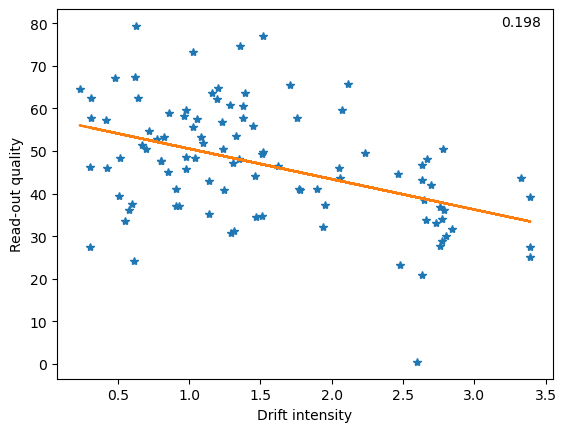

In [262]:
plt.plot(X,Y,'*')
plt.plot(X,a * X + b)
plt.xlabel('Drift intensity')
plt.ylabel('Read-out quality')
plt.text(max(X)*.94,max(Y),str(round(r,3)));

Text(0, 0.5, 'Initial y response')

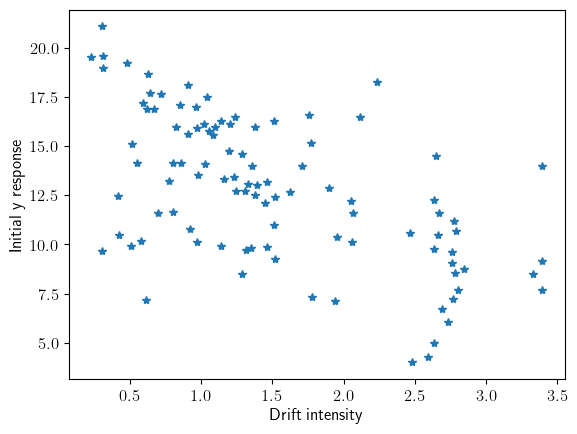

In [ ]:
plt.plot(drift,np.sum(rout_init,axis = 1),'*')

plt.xlabel('Drift intensity')
plt.ylabel('Initial y response')

Text(0, 0.5, 'Mean response of y all days, no shuffle')

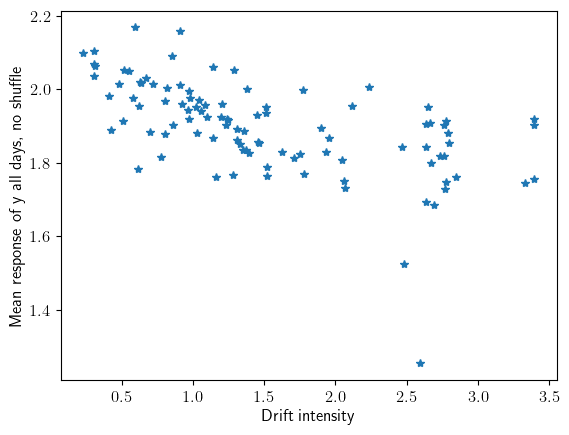

In [215]:
plt.plot(drift,rout_shuffle_mean[:,0],'*')
#plt.plot(np.min(corrL,1),np.sum(r_normed,axis = 1),'*')


plt.xlabel('Drift intensity')
plt.ylabel('Mean response of y all days, no shuffle')

In [124]:
CoML

array([[17.52316777, 20.43207954, 22.87754112, 25.16960558],
       [14.43614135, 14.60848128, 16.59771255, 20.87209374],
       [18.2672715 , 21.09934652, 25.70268165, 28.835374  ],
       [16.99646609, 20.53978735, 23.14264423, 26.92605706],
       [21.11689195, 23.92722625, 26.64337614, 26.54146951],
       [15.98408315, 15.01921273, 16.36526766, 18.04012788],
       [13.42798403, 16.85401495, 19.68781605, 20.17347439],
       [24.75475706, 25.99395943, 27.15653944, 28.95711925],
       [20.16728762, 20.9265379 , 20.66251965, 24.45181255],
       [18.67962372, 21.43144724, 24.03565211, 25.44735879]])

Text(0, 0.5, 'CoM drift')

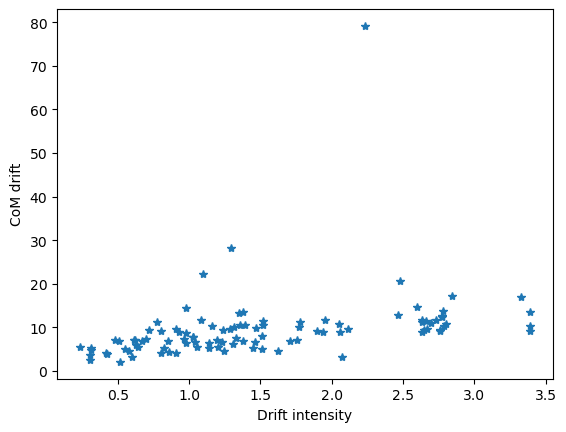

In [202]:
plt.plot(drift,CoML[:,3]-CoML[:,0],'*')

plt.xlabel('Drift intensity')
plt.ylabel('CoM drift')

## Revision: change of slope

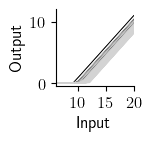

In [3285]:
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)

np.random.seed(0)
sigma = 1
E = 1.5
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)

fig, ax = plt.subplots(figsize = (1,1))
lw = .5
X = np.arange(0,21)
for i in range(N):
    Y = np.maximum(0, X + exc0[i] - 12)
    ax.plot(X,Y, color='lightgrey',linewidth=lw)
    if i >=10 and i < 20:
        Y = np.maximum(0, X + exc0[i] + E - 12)
        ax.plot(X,Y, color='k',linewidth=lw)

ax.set_xlabel(r'Input')
ax.set_ylabel(r'Output')
ax.set_xlim([6,20])
ax.set_ylim([-.5,12])
ax.set_xticks([10,15,20])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('th.pdf',bbox_inches='tight')


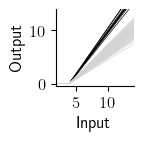

In [4649]:
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)

np.random.seed(0)
sigma = .1
E = .6
offset = 0
slope = 1
exc0 = np.zeros(N)
exc0 = np.random.normal(slope,sigma,N)
exc0 = np.sqrt(exc0*exc0)

fig, ax = plt.subplots(figsize = (1,1))
lw = .5
X = np.arange(0,21)
for i in range(N):
    Y = np.maximum(0, X - I0 + offset) * exc0[i]
    ax.plot(X,Y, color='lightgrey',linewidth=lw)
    if i >=10 and i < 20:
        Y = np.maximum(0, X  - I0 + offset) * (exc0[i]+ E)
        ax.plot(X,Y, color='k',linewidth=lw)

ax.set_xlabel(r'Input')
ax.set_ylabel(r'Output')
ax.set_xlim([2,14])
ax.set_ylim([-.5,14])

#ax.set_xticks([5,10,15,20])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('sl.pdf',bbox_inches='tight')


In [4650]:
# main function
routbis = np.zeros((4,nstep))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    Wout = yt[index[4]].reshape((1,N))
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T
    thetaout = yt[index[6]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*I2

    drdt = (-r + exc * np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib) )/taur
    #drdt = (-r + np.arctan(exc) * np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib) )/taur
    

    #if t == 2050:
    #    print(W.dot(r) + INPUT(t)[np.newaxis].T - rinhib)
    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=cap ,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    rout = Wout.dot(r)[0]
    routbis[0,t] = rout
    dWoutdt = (1 - np.sum(Wout))*r.T * rout/200 - Wout/1000
    #dWoutdt = r.T * rout/1000 - Wout/1000
    #dWoutdt = (rout * (rout-thetaout) * r.T )/ 4000
    #dWoutdt = np.multiply(dWoutdt,Wout<10)
    dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout<=0,dWoutdt<0)))
    #dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout>=10,dWoutdt>0)))
    #droutdt = (Wout.dot(r) - rout) /1
    #dthetaoutdt = ((rout*rout)/.2 - thetaout)/10
    dthetaoutdt = np.zeros((1))
    droutdt = np.zeros((1))
    S.append(np.sum(Wout))
    
    if t > 3000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[1,t] = Wout.dot(r)[0]

    if t > 6000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[2,t] = Wout.dot(r)[0]
        
    if t > 9000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[3,t] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten(),
                           droutdt.flatten(),
                           dthetaoutdt.flatten()))

    return dydt

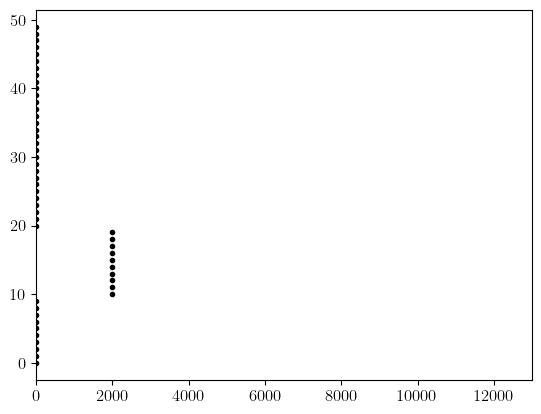

In [4651]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)
rout0 = np.zeros(1)
Wout0 = np.zeros(N) + .001
thetaout0 = np.zeros(1)

nstep = 13000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000

seq = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
    
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1


tag = np.zeros(N)
 
#tag[:10] = 1
#tag[25] = 2000

#tag = np.arange(1,nstep,nstep/N)

#tag[:10] = np.arange(1,1000,100)
#tag[10:20] = np.arange(2000,3000,100)

tag[:10] = 1
tag[10:20] = 2000

plt.plot(tag,range(N),'k.')
plt.xlim([0,nstep])
         
index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N),
         range(N + N*N +N+N+N,N + N*N +N+N+N+1),
         range(N + N*N +N+N+N+1,N + N*N +N+N+N+1+1)]
         
         
         
         
         

In [4652]:
E = 1.5
sigma = 1
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)

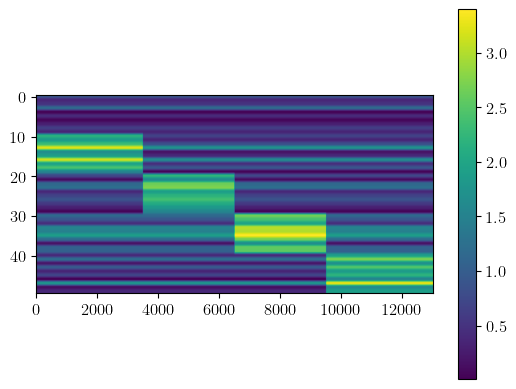

In [4653]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

Emat = def_Emat(E,exc0)

plt.figure()
plt.imshow(Emat,aspect = nstep/N/2)
plt.colorbar()

(array([9., 7., 8., 6., 5., 4., 5., 1., 2., 3.]),
 array([0.01050002, 0.19903894, 0.38757785, 0.57611677, 0.76465568,
        0.9531946 , 1.14173351, 1.33027243, 1.51881134, 1.70735026,
        1.89588918]),
 <a list of 10 Patch objects>)

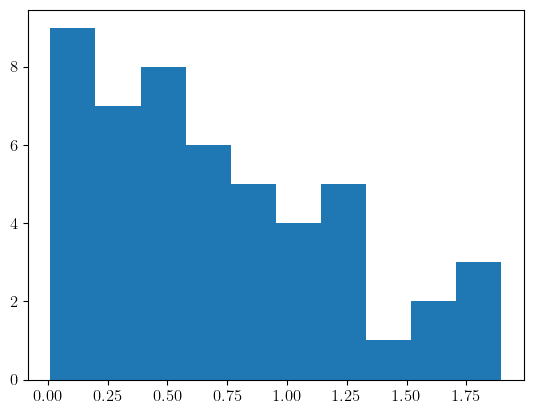

In [4654]:
plt.hist(exc0)

In [4655]:
seedL = [2]

threshold = 3
tauwL = [800]
taurL = [20]
tauthetaL = [100]
y0L = [2]
I1L = [.5]

I0L = [8]
sigmaL = [.1]
EL = [.1]
INL = [17]
decayL = [500]

(800, 20, 100, 8, 0.5, 1, 2, 0.5, 1000, 15, 2)
(800, 20, 100, 12, 0.5, 1.5, 2, 0.6, 1000, 20, 2)
(800, 20, 100, 12, 0.5, 1.5, 2, 0.6, 1000, 20, 2)
(800, 20, 100, 8, 0.5, 1, 2, 0.1, 500, 15, 2)
(800, 20, 100, 8, 0.5, 0.8, 2, 0.08, 500, 15, 2)

(800, 20, 100,   8, 0.5, 0.8, 2, 0.1, 500, 15, 2)
(800, 20, 100, 8, 0.5, 1, 2, 0.1, 500, 15, 2)

(800, 20, 100, 8, 0.5, 1, 2, 0.1, 500, 17, 2)
(800, 20, 100, 8, 0.5, 1, 2, 0.12, 500, 17, 2)
(800, 20, 100, 8, 0.5, 1.2, 2, 0.08, 500, 17, 2)
(800, 20, 100, 8, 0.5, 1.2, 2, 0.12, 500, 17, 2)

(800, 20, 100, 10, 0.5, 1, 2, 0.1, 500, 19, 2)
(800, 20, 100, 7, 0.5, 1, 2, 0.1, 500, 15, 2)
(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])
slope = 1


In [4656]:
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]

I0L = [10]
I1L = [.5]
EL = [.5]
y0L = [2]
sigmaL = [.2]
INL = [1]
seedL = [0]
slopeL = [.2]

(800, 20, 100,  8, 0.5, 0.3, 2, 0.1, 1000, 15, 0) # works ish, slope = .2
(800, 20, 100, 12, 0.5, 0.3, 2, 0.1, 1000, 20, 2) # slope = .2

(800, 20, 100, 5, 0.4, 0.5, 2, 0.1, 1000, 10, 0, 0.2) # most things work but big engram so diff with previously slope = .2
(800, 20, 100, 5, 0.5, 0.5, 2, 0.1, 1000, 10, 1, 0.4)


(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0])
# slope = .2

### param

In [4657]:
### works for slope
threshold = 1
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [1]
I1L = [.9]
EL = [.6]
y0L = [2]
sigmaL = [.1]
decayL = [500]
INL = [15]
seedL = [2]
slopeL = [1]

cap = 1
I2 = .05

(800, 20, 100,  8, 0.5, 0.3, 2, 0.1, 1000, 15, 0) # works ish, slope = .2, exc0 = np.random.normal(slope,sigma,N)
(800, 20, 100, 12, 0.5, 0.3, 2, 0.1, 1000, 20, 2) # slope = .2, exc0 = np.random.normal(slope,sigma,N)

(800, 20, 100, 5, 0.4, 0.5, 2, 0.1, 1000, 10, 0, 0.2) # most things work but big engram so diff with previously, exc0 = np.random.normal(slope,sigma,N)
(800, 20, 100, 5, 0.5, 0.5, 2, 0.1, 1000, 10, 1, 0.4)

(800, 20, 100, 8, 0.5, 1, 2, 0.1, 500, 15, 2)
(800, 20, 100, 4, 0.8, 0.5, 2, 0.1, 500, 15, 2, 1)
(800, 20, 100, 1, 0.9, 0.5, 2, 0.1, 500, 15, 2, 1) # works amost
(700, 20, 100, 1.2, 0.9, 0.6, 2, 0.1, 500, 15, 2, 1)

(700, 20, 100, 1, 0.9, 0.6, 2, 0.1, 500, 15, 2, 1)
(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0])
# slope = .2

In [4658]:
### try to improve

threshold = .5
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [1]
I1L = [.85]
EL = [.5]
y0L = [2]
sigmaL = [.1]
decayL = [750]
INL = [10]
seedL = [2]
slopeL = [1]

cap = .5
I2 = .05

(700, 20, 100, 1, 0.9, 0.5, 2, 0.1, 700, 11, 2, 1)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0])
# slope = .2


In [4659]:
### try to improve

threshold = .5
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [1]
I1L = [.6]
EL = [.4]
y0L = [2]
sigmaL = [.1]
decayL = [800]
INL = [8]
seedL = [8]
slopeL = [.6]

cap = .9
I2 = .2

(700, 20, 100, 1, 0.9, 0.5, 2, 0.1, 700, 11, 2, 1)
(700, 20, 100, 1, 0.9, 0.6, 2, 0.1, 1000, 10, 2, 0.6)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0])
# slope = .2


In [4660]:
### works ok

threshold = 2
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [1]
I1L = [.6]
EL = [.5]
y0L = [2]
sigmaL = [.2]
decayL = [800]
INL = [9]
seedL = [2]
slopeL = [.5]

cap = .8
I2 = .2

(700, 20, 100, 1, 0.9, 0.5, 2, 0.1, 700, 11, 2, 1)
(700, 20, 100, 1, 0.9, 0.6, 2, 0.1, 1000, 10, 2, 0.6)

(700, 20, 100, 1, 0.5, 0.5, 2, 0.1, 800, 7, 8, 0.6)
(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0])
# slope = .2


In [4661]:
### works with previous ordinal decoder
(800, 20, 100,  8, 0.5, 0.3, 2, 0.1, 1000, 15, 0) # works ish, slope = .2, exc0 = np.random.normal(slope,sigma,N)
(800, 20, 100, 12, 0.5, 0.3, 2, 0.1, 1000, 20, 2) # slope = .2, exc0 = np.random.normal(slope,sigma,N)

(800, 20, 100, 5, 0.4, 0.5, 2, 0.1, 1000, 10, 0, 0.2) # most things work but big engram so diff with previously, exc0 = np.random.normal(slope,sigma,N)
(800, 20, 100, 5, 0.5, 0.5, 2, 0.1, 1000, 10, 1, 0.4)

(800, 20, 100, 8, 0.5, 1, 2, 0.1, 500, 15, 2)
(800, 20, 100, 4, 0.8, 0.5, 2, 0.1, 500, 15, 2, 1)
(800, 20, 100, 1, 0.9, 0.5, 2, 0.1, 500, 15, 2, 1) # works amost
(700, 20, 100, 1.2, 0.9, 0.6, 2, 0.1, 500, 15, 2, 1)

(700, 20, 100, 1, 0.9, 0.5, 2, 0.1, 600, 12, 2, 0.8) # cap .9  I2 .1, works! but still feel that can be improved

(600, 20, 100, 1, 0.9, 0.5, 2, 0.1, 600, 12, 2, 0.8, 0.9)
(700, 20, 100, 2, 0.6, 0.4, 2, 0.2, 800, 15, 1, 0.5, 0.7, 0.05) # works!
(700, 20, 100, 2, 0.7, 0.5, 2, 0.2, 800, 15, 1, 0.5, 0.7, 0.05)

threshold = 1
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [3]
I1L = [.6]
EL = [.5]
y0L = [2]
sigmaL = [.2]
decayL = [800]
INL = [15]
seedL = [1]
slopeL = [.5]
capL = [.7]
I2L = [.05]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0],capL[0],I2L[0])
# slope = .2

In [4662]:
### works with new decoder

threshold = 1
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [5]
I1L = [1]
EL = [.4]
y0L = [2]
sigmaL = [.2]
decayL = [800]
INL = [18]
seedL = [1]
slopeL = [.5]
capL = [.7]
I2L = [.05]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0],capL[0],I2L[0])
# slope = .2

In [4663]:
### works great with new decoder

threshold = 1
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [4]
I1L = [.7]
EL = [.5]
y0L = [2]
sigmaL = [.2]
decayL = [800]
INL = [15]
seedL = [0]
slopeL = [.4]
capL = [.5]
I2L = [.05]
(700, 20, 100, 4, 0.7, 1, 2, 0.2, 800, 15, 1, 0.5, 0.6, 0.05)## works ok but not good decay

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0],capL[0],I2L[0])
# slope = .2

In [4664]:
### works

threshold = 1
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [4]
I1L = [.8]
EL = [.5]
y0L = [2]
sigmaL = [.2]
decayL = [800]
INL = [15]
seedL = [0]
slopeL = [.5]
capL = [.5]
I2L = [.05]
(700, 20, 100, 4, 0.7, 1, 2, 0.2, 800, 15, 1, 0.5, 0.6, 0.05)## works ok but not good decay

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0],capL[0],I2L[0])
# slope = .2

In [4665]:
### works well but reactivation not perfect

threshold = 1
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [2]
I1L = [.9]
EL = [.5]
y0L = [2]
sigmaL = [.2]
decayL = [800]
INL = [15]
seedL = [10]
slopeL = [.5]
capL = [.5]
I2L = [.05]
(700, 20, 100, 4, 0.7, 1, 2, 0.2, 800, 15, 1, 0.5, 0.6, 0.05)## works ok but not good decay

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0],capL[0],I2L[0])
# slope = .2

In [4666]:
### test

threshold = 1
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [4]
I1L = [.7]
EL = [.5]
y0L = [2]
sigmaL = [.2]
decayL = [800]
INL = [15]
seedL = [0]
slopeL = [.4]
capL = [.5]
I2L = [.05]
(700, 20, 100, 4, 0.7, 1, 2, 0.2, 800, 15, 1, 0.5, 0.6, 0.05)## works ok but not good decay

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0],capL[0],I2L[0])
# slope = .2

(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 0, 0.4, 0.5, 0.05)


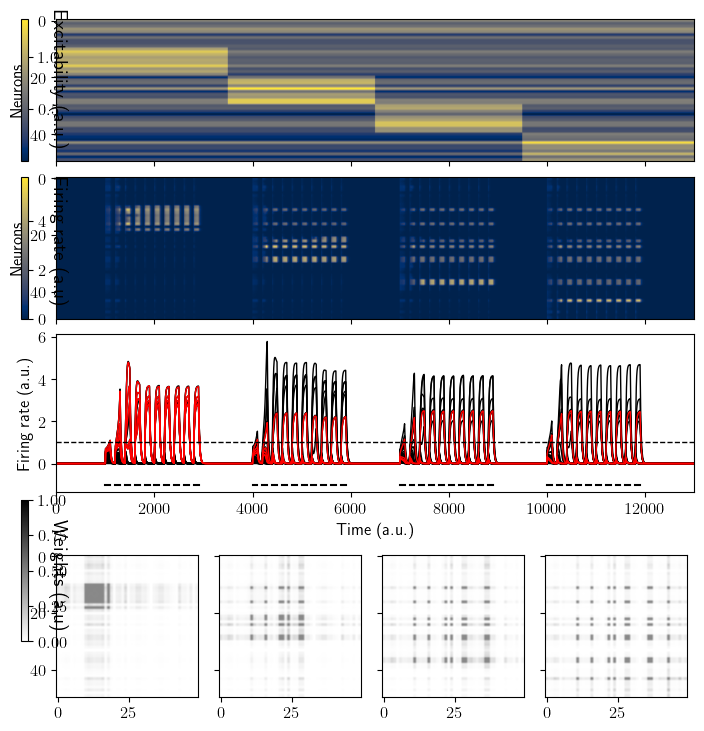

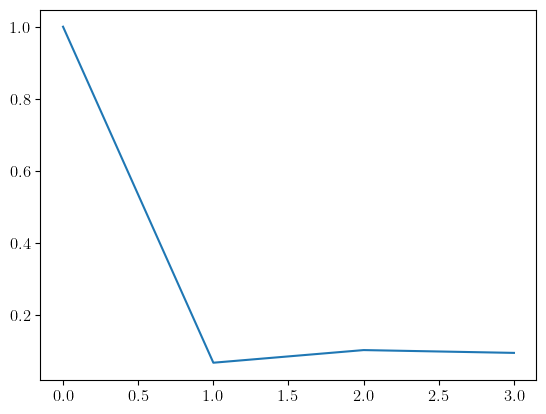

In [4667]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL,slopeL,capL,I2L):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    #exc0 = np.random.uniform(slope-sigma,slope+sigma,N)
    exc0 = np.sqrt(exc0*exc0)


    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    rout = y[index[5][:],:] 
    
    plot_all()
    #plt.savefig('all.pdf')

    plt.show()
    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    plt.plot([correlation(V0,V0),correlation(V0,V1),correlation(V0,V2),correlation(V0,V3)])
    plt.show()


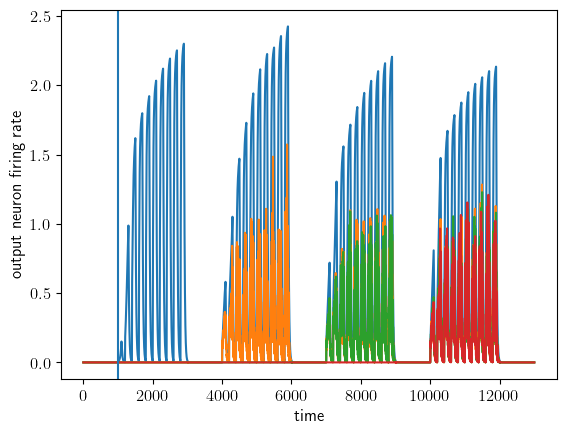

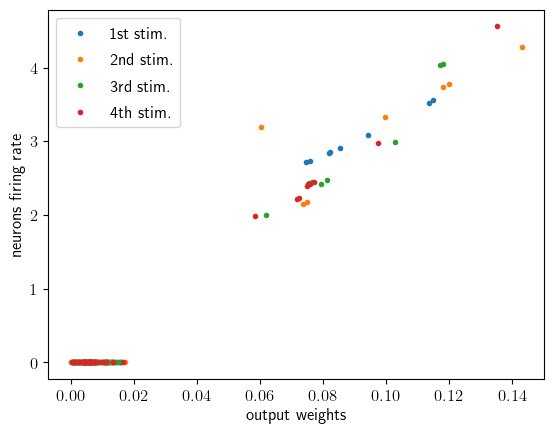

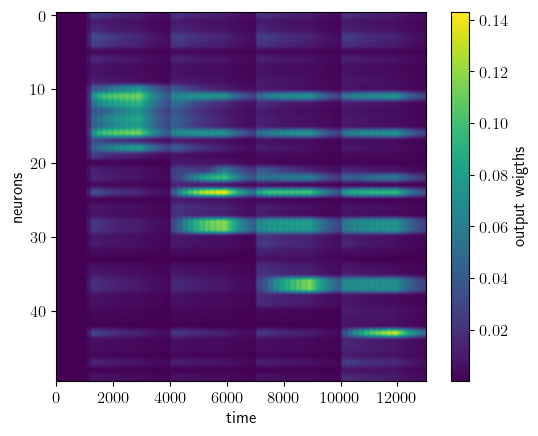

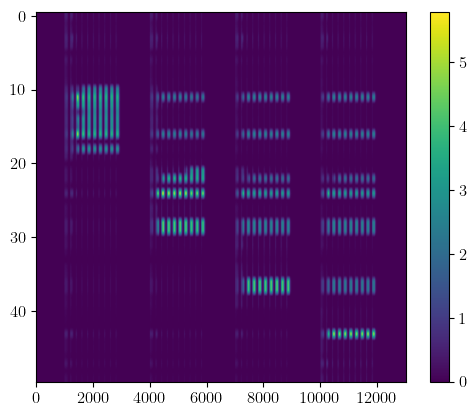

In [4668]:
    
    # decode memory rate
    plt.figure()
    plt.plot(routbis[0,:]);
    plt.plot(routbis[1,:]);
    plt.plot(routbis[2,:]);
    plt.plot(routbis[3,:]);
    plt.xlabel('time')
    plt.ylabel('output neuron firing rate')
    plt.axvline(x = 1000)
    plt.savefig('decode_rate.png',dpi = 500)
    plt.show()

    # weights vs rates
    for t in [2900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [5900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [8900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [11900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    plt.legend(['1st stim.','2nd stim.','3rd stim.','4th stim.'])
    plt.xlabel('output weights')
    plt.ylabel('neurons firing rate')
    plt.savefig('decode_corr.png',dpi = 500)
    plt.show()

    
    # weights
    plt.figure()
    plt.imshow(Wout,aspect = nstep/N)
    cbar = plt.colorbar()
    cbar.set_label('output weigths')
    plt.ylabel('neurons')
    plt.xlabel('time')
    plt.savefig('weights.png',dpi = 500)
    plt.show()

    # rates
    plt.figure()
    plt.imshow(r,aspect = nstep/N)
    plt.colorbar()
    plt.show()

In [4669]:
active = r[:,2850]>threshold

In [4670]:
active = np.where(active)[0]

In [4671]:
L = np.array(range(N))
for l in active:
    L = np.delete(L,l)

In [4672]:
L = [i for i in range(N) if i not in active]

In [4673]:
active

array([10, 11, 12, 13, 14, 15, 16, 18])

In [4674]:
cmap = reversed(["20331a","33512a","446c37","558745","66a253","7cb36b","94c186","abcea1","c3dcbc","dbead7"])
cmap2 = ["ffffff","005F73"]

In [4675]:
import matplotlib.colors as mcolors
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

cmap = get_continuous_cmap(cmap)
cmap2 = get_continuous_cmap(cmap2)

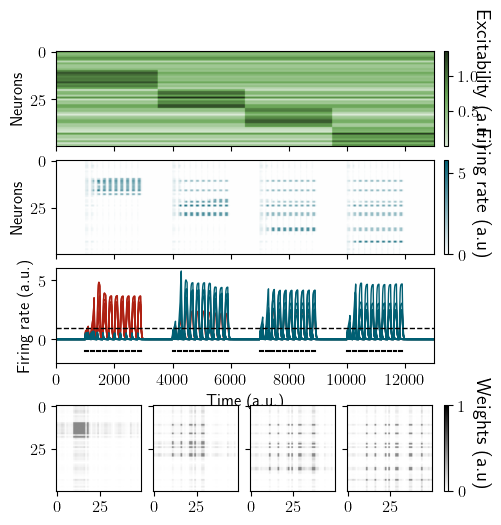

In [4676]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(120*mm,120*mm), facecolor='w',frameon=False)

ax1 = fig.add_axes([.04,.79,.88,.2]) # [left, bottom, width, height] 
ax2 = fig.add_axes([.04,.56,.88,.2])
ax3 = fig.add_axes([.08,.33,.8,.2])

w = .18
ax5 = fig.add_axes([.08,.06,w,w])
ax6 = fig.add_axes([.285,.06,w,w])
ax7 = fig.add_axes([.49,.06,w,w])
ax8 = fig.add_axes([.695,.06,w,w])


im = ax1.imshow(Emat,aspect = nstep/N*2/8,cmap = cmap)
ax1.set_ylabel('Neurons')
ax1.set_xticklabels('')
cbar1 = plt.colorbar(im,cax = plt.axes([.9, 0.79, 0.01, 0.2])) # [left, bottom, width, height] 
cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=-.09,x=6)

im = ax2.imshow(np.maximum(0,r),aspect = nstep/N*2/8,cmap = cmap2)
ax2.set_ylabel('Neurons')
ax2.set_xticklabels('')
cbar2 = plt.colorbar(im,cax = plt.axes([.9, 0.56, 0.01, 0.2])) # [left, bottom, width, height] 
cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=-.09,x=6)

for n in active:
    ax3.plot(r[n,:],color[8],linewidth = 1)
for n in L:
    ax3.plot(r[n,:],color[1],linewidth = 1)


ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
ax3.set_xlabel('Time (a.u.)')
ax3.set_ylabel('Firing rate (a.u.)')

ax3.set_xlim([0,nstep])
ax3.set_ylim([-2,6])

h = -1
for s in range(int(len(seq)/2)):
    ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
ax6.set_yticklabels('')
ax7.set_yticklabels('')
ax8.set_yticklabels('')

cbar3 = plt.colorbar(im,cax = plt.axes([.9, 0.06, 0.01, 0.18]))
cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=-.02,x=6)
cbar3.set_ticks([0,1])
plt.savefig('all_slope.pdf')

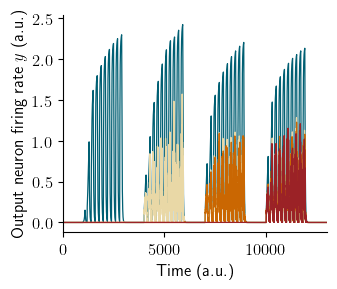

In [4677]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(80*mm,70*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.16,0.18,.84,.79])

lw = .9
ax.plot(routbis[0,:],color[1],linewidth=lw);
ax.plot(routbis[1,:],color[4],linewidth=lw);
ax.plot(routbis[2,:],color[6],linewidth=lw);
ax.plot(routbis[3,:],color[9],linewidth=lw);

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,13000])
plt.savefig('decode_rate.pdf')




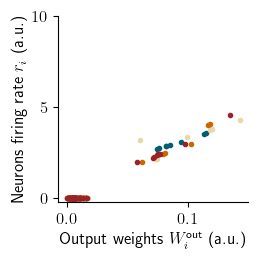

In [4678]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(70*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


for t in [2900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[1])
for t in [5900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[4])
for t in [8900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[6])
for t in [11900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[9])

ax.set_xlabel(r'Output weights $W^{\text{out}}_i$ (a.u.)')
ax.set_ylabel(r'Neurons firing rate $r_i$ (a.u.)')
ax.set_yticks([0,5,10])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf')

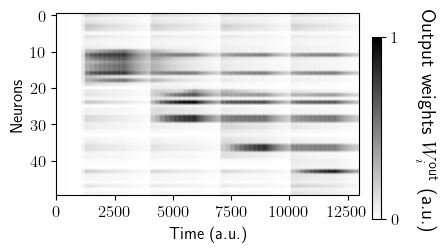

In [4679]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(110*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.12,0.2,.7,.77])


ax.imshow(Wout, aspect='auto', cmap = 'binary')
cbar3 = plt.colorbar(im,cax = plt.axes([.85, 0.1, 0.02, 0.77]))
cbar3.ax.set_title(r'Output weights $W^{\text{out}}_i$ (a.u.)', rotation=270,loc='left',y=-.1,x=5)
cbar3.set_ticks([0,1])


ax.set_ylabel('Neurons')
ax.set_xlabel('Time (a.u.)')

plt.savefig('weights.pdf')

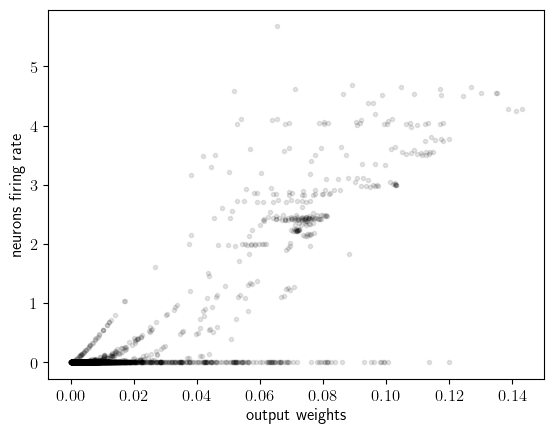

In [4680]:
# weights vs rates
for t in np.arange(100,nstep,200):
    plt.plot(Wout[:,t],r[:,t],'k.', alpha = .1)
plt.xlabel('output weights')
plt.ylabel('neurons firing rate')
plt.savefig('decode_corr.png',dpi = 500)
plt.show()

In [4681]:
W1 = Wout[:,2900]
W2 = Wout[:,5900]
W3 = Wout[:,8900]
W4 = Wout[:,11900]

In [4682]:
pos = np.array(range(N))

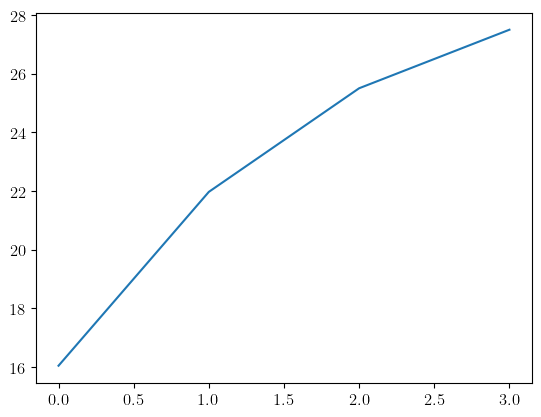

In [4683]:
plt.plot([sum(np.multiply(W1,pos)),sum(np.multiply(W2,pos)),sum(np.multiply(W3,pos)),sum(np.multiply(W4,pos))])

In [4684]:
slope

0.4

In [4685]:
seedL = range(10)
WoutL = np.zeros((len(seedL),4))
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    exc0 = np.sqrt(exc0*exc0)

    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    
    W1 = Wout[:,2900]
    W2 = Wout[:,5900]
    W3 = Wout[:,8900]
    W4 = Wout[:,11900]

    WoutL[seed,:] = np.array([sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)])
    

(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 0)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 1)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 2)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 3)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 4)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 5)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 6)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 7)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 8)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 9)


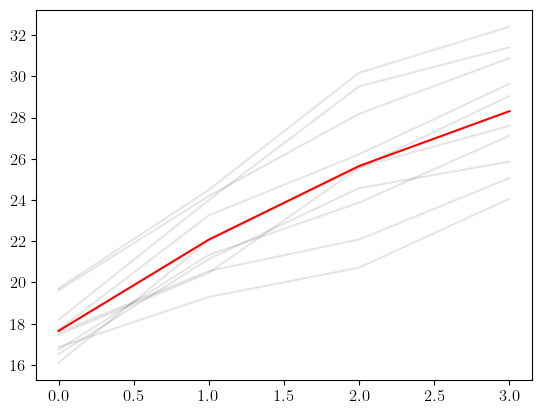

In [4686]:
for i in range(10):
    plt.plot(WoutL[i,:],'k',alpha=.1)
plt.plot(np.mean(WoutL,axis=0),'r')

In [4687]:
WoutLshuffled = np.copy(WoutL)
np.random.shuffle(WoutLshuffled.T)

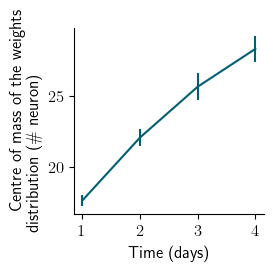

In [4689]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(70*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar([1,2,3,4],np.mean(WoutL,axis=0),stats.sem(WoutL),color = color[1])


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks([1,2,3,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr_slope.pdf')



### Run different seeds, fixed E, get V_list

In [4630]:
Nseed = 10
V_list = np.zeros([4,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V
    
    #plot_all()
    #plt.show()

0
1
2
3
4
5
6
7
8
9


In [4631]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])

corr_tot

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.06746367,  0.17472937,  0.31873797,  0.38055235,  0.08948359,
         0.49150792,  0.25193273,  0.13755251,  0.37780348,  0.57609788],
       [ 0.10253997,  0.20570162,  0.35394063,  0.3433582 , -0.03433817,
         0.26022343,  0.28423134, -0.04332757,  0.43404498,  0.61230739],
       [ 0.09474565,  0.26243002,  0.34320677,  0.4221597 , -0.01656475,
         0.24914823,  0.23250227,  0.0349246 ,  0.41261402,  0.57240504]])

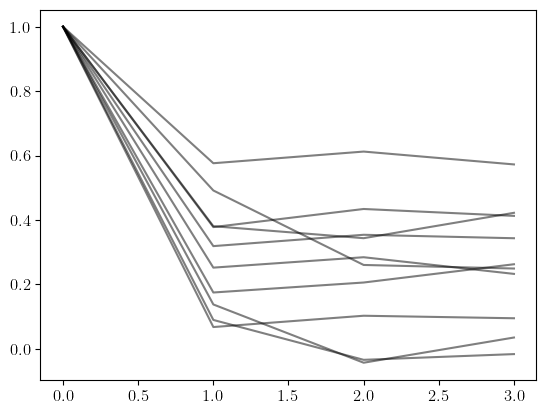

In [4632]:
for seed in range(Nseed):
    plt.plot(corr_tot[:,seed],'k', alpha = .5)

### figure

In [4633]:
Nseed = 10

In [4634]:
V_list_shuffled = np.copy(V_list)

In [4635]:
for seed in range(Nseed):
    for day in range(4):
        np.random.shuffle(V_list_shuffled[day,:,seed])

In [4636]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])
        
corr_tot_shuffled = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot_shuffled[day,seed] = correlation(V_list_shuffled[0,:,seed],V_list_shuffled[day,:,seed])

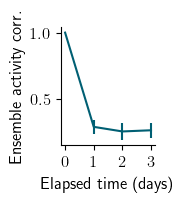

In [4637]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(30*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corr_tot,axis=1),stats.sem(corr_tot,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_slope.pdf',bbox_inches='tight')

### Ordinal time decoder, run different E, get t_mat

In [4638]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))

In [4639]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [4640]:
seedL = np.arange(0,10,1)
seedL

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4641]:
EL = np.arange(0,.8,.1)
EL = np.arange(0,1.6,.5)
Nseed = len(seedL)
#EL = [1.5]
EL

array([0. , 0.5, 1. , 1.5])

In [4642]:
EL = np.arange(0,.8,.1)
EL = np.arange(0,1.6,.2)
Nseed = len(seedL)
#EL = [1.5]
EL

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4])

In [4643]:
t_mat = []
t_mat_shuffled = []
V_list = np.zeros([4,N,Nseed])
V_list_suffled = np.zeros([4,N])
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]

    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V

    np.save("V_list.npy", V_list)

    # decoder ordinal
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            #print(V[perm[i],:])
            s += correlation(V[perm[i],:],V[perm[i+1],:])
        s = s
        s_corr.append(s)
    #print(s_corr)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    # shuffle
    
    #V_list_suffled = np.copy(V_list[:,:,seed])
    #np.random.shuffle(V_list_suffled.T)
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_suffled[:,i] = line
    
    #print(V_list[:,:,seed] == V_list_suffled)

    #print(V_list)
    #print(V_list_suffled)
    
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[perm[i],:],V_list_suffled[perm[i+1],:])
        s = s
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    #plot_all()
    #plt.savefig(str(E)+'all.pdf')
    #plt.show()




(700, 20, 100, 4, 0.7, 0.0, 2, 0.2, 800, 15, 0)
1.022521854659838
-0.8588885596633378
(700, 20, 100, 4, 0.7, 0.0, 2, 0.2, 800, 15, 1)
-1.5588470293567251
-0.6752734906697966
(700, 20, 100, 4, 0.7, 0.0, 2, 0.2, 800, 15, 2)
-0.22622678529456935
0.5307453457550598
(700, 20, 100, 4, 0.7, 0.0, 2, 0.2, 800, 15, 3)
0.29817794328187697
0.24457010411585228
(700, 20, 100, 4, 0.7, 0.0, 2, 0.2, 800, 15, 4)
1.4389472828501495
1.4905675767633115
(700, 20, 100, 4, 0.7, 0.0, 2, 0.2, 800, 15, 5)
-0.508913531707952
0.024101758523906655
(700, 20, 100, 4, 0.7, 0.0, 2, 0.2, 800, 15, 6)
0.9941399418498837
1.2682501964509596
(700, 20, 100, 4, 0.7, 0.0, 2, 0.2, 800, 15, 7)
-0.5795630153005848
0.22464830543741354
(700, 20, 100, 4, 0.7, 0.0, 2, 0.2, 800, 15, 8)
0.959057042081312
1.0613900404655312
(700, 20, 100, 4, 0.7, 0.0, 2, 0.2, 800, 15, 9)
-0.2544354985326654
-0.7621043097521147
(700, 20, 100, 4, 0.7, 0.2, 2, 0.2, 800, 15, 0)
1.0156678073144234
0.46461931956085295
(700, 20, 100, 4, 0.7, 0.2, 2, 0.2, 800, 1

In [4644]:
np.save("t_mat_slope.npy", t_mat)
np.save("t_mat_shuffled_slope.npy", t_mat_shuffled)

In [4645]:
t_mat = np.array(t_mat).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled = np.array(t_mat_shuffled).reshape((len(EL),len(decayL),len(seedL)))

decay = 0
#t_mat = np.abs(t_mat[:,decay,:])
#t_mat_shuffled = np.abs(t_mat_shuffled[:,decay,:])
t_mat = t_mat[:,decay,:]
t_mat_shuffled = t_mat_shuffled[:,decay,:]

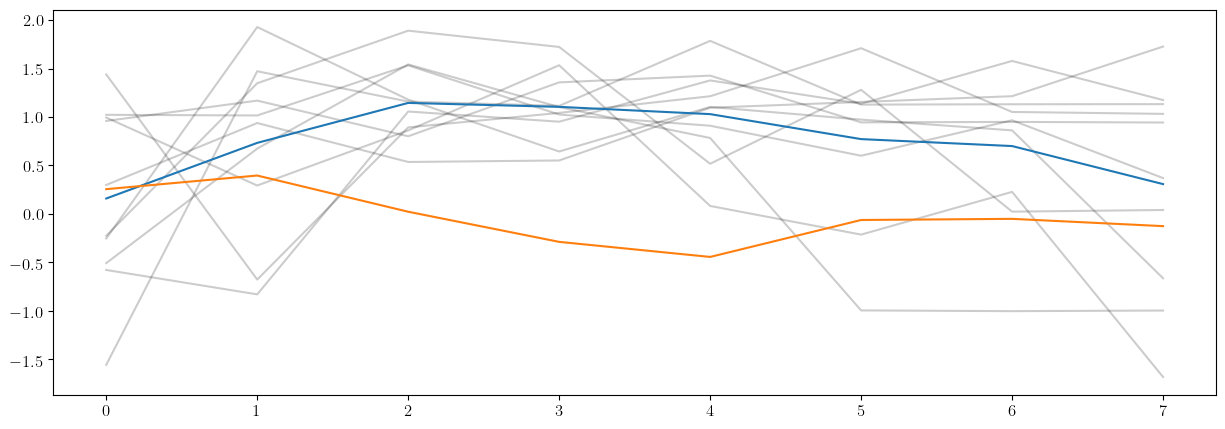

In [4646]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat[:,seed],'k', alpha = .2)
plt.plot(np.mean(t_mat,axis = 1))
plt.plot(np.mean(t_mat_shuffled,axis = 1))
#plt.xticks(range(len(EL)),lab);

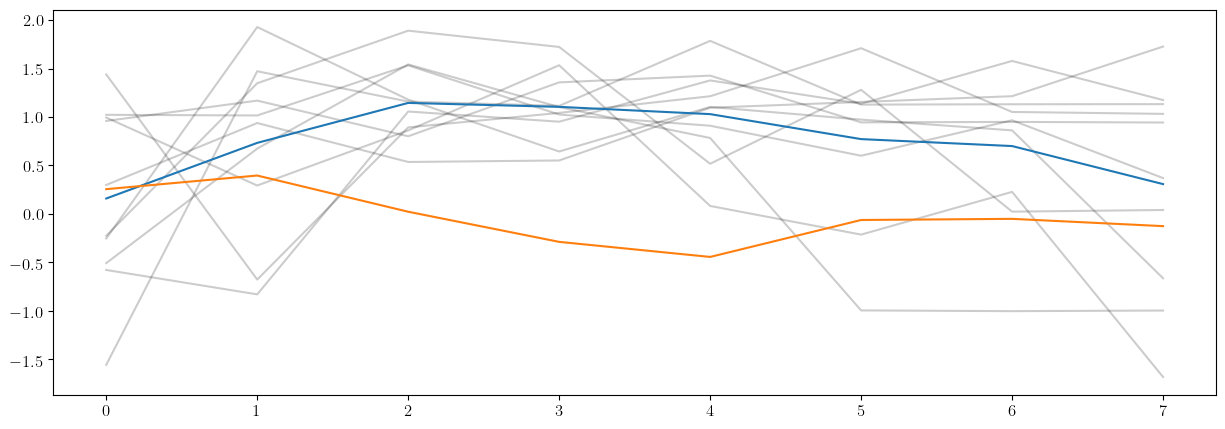

In [4647]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat[:,seed],'k', alpha = .2)
plt.plot(np.mean(t_mat,axis = 1))
plt.plot(np.mean(t_mat_shuffled,axis = 1))
#plt.xticks(range(len(EL)),lab);

### figure

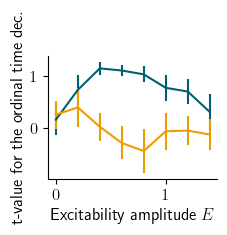

In [4648]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat,axis = 1),stats.sem(t_mat,axis = 1),color = color[1])
ax.errorbar(EL,np.mean(t_mat_shuffled,axis = 1),stats.sem(t_mat_shuffled,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('tVSE_slope.pdf',bbox_inches='tight')



### figure

In [4165]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))


In [4111]:
all_corr_simple

NameError: name 'all_corr_simple' is not defined

In [ ]:
all_corr_simple[:,0]

In [1890]:
all_corr_simple[-1,:]

array([-0.11323241, -0.11305081, -0.11366114, -0.10947887, -0.11351569,
       -0.10951502, -0.10514273, -0.10499727, -0.10560761, -0.10951502,
       -0.10542601, -0.10947887, -0.1091434 , -0.10542601, -0.10917955,
       -0.11351569, -0.10499727, -0.11305081, -0.10917955, -0.10560761,
       -0.1091434 , -0.11366114, -0.10514273, -0.11323241])

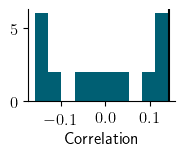

In [4166]:
# Ordinal time decoder
decod = []
all_corr_simple = np.zeros((Nseed,len(L)))
for seed in range(Nseed):
    s_corr = []
    p = 0
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list[perm[i],:,seed],V_list[perm[i+1],:,seed])
        s = s/3
        all_corr_simple[seed,p] = s
        p+=1

seed = -1

mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,30*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.75,.78])


bins = np.arange(.4,.78,.04)
#bins = np.arange(-.12,.1,.01)


#ax.hist(all_corr_simple[seed,:].flatten(),color = color[1], alpha = 1,bins = bins)
ax.hist(all_corr_simple[seed,:].flatten(),color = color[1], alpha = 1)


ax.axvline(np.mean(all_corr_simple[seed,0]),color = 'k')
#ax.set_ylabel('Count for the ordinal time decoder')
ax.set_xlabel('Correlation')

#ax.set_xticks([.4,.6,.8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('hist.pdf')

### figure


In [111]:
pos = np.array(range(N))
pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [4695]:
seedL = range(10)
WoutL = np.zeros((len(seedL),4))
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    #exc0 = np.random.uniform(slope-sigma,slope+sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)

    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    
    W1 = Wout[:,2900]
    W2 = Wout[:,5900]
    W3 = Wout[:,8900]
    W4 = Wout[:,11900]

    WoutL[seed,:] = np.array([sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)])
    

(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 0)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 1)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 2)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 3)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 4)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 5)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 6)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 7)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 8)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 9)


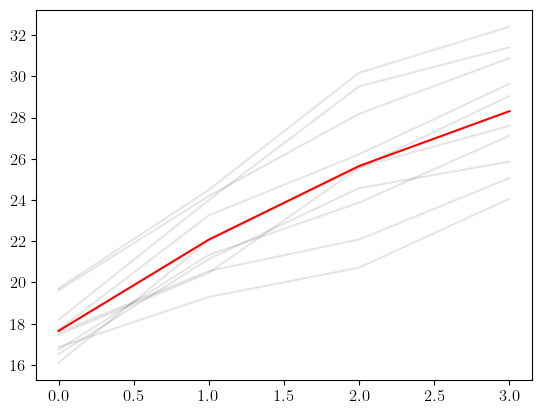

In [4696]:
for i in range(10):
    plt.plot(WoutL[i,:],'k',alpha=.1)
plt.plot(np.mean(WoutL,axis=0),'r')

In [4697]:
WoutLshuffled = np.copy(WoutL)
np.random.shuffle(WoutLshuffled.T)


In [4698]:
WoutL

array([[16.10402668, 22.04834347, 25.59929358, 27.60117338],
       [19.61382665, 24.19261282, 28.18508856, 30.88592138],
       [17.70238261, 23.25803463, 26.22250713, 29.64310894],
       [16.52455726, 21.13621272, 24.57636215, 25.86805198],
       [18.189042  , 24.0044804 , 29.51788056, 31.41006618],
       [17.46681546, 20.46497425, 25.56549665, 29.05307348],
       [16.74324179, 21.33453609, 23.87538434, 27.12589459],
       [19.70829793, 24.49341853, 30.17791682, 32.4126992 ],
       [16.85869683, 19.29460907, 20.72113415, 24.06696404],
       [17.57259639, 20.5556209 , 22.08564739, 25.06498778]])

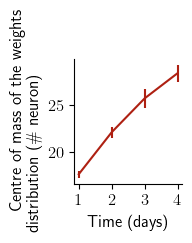

In [4699]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar([1,2,3,4],np.mean(WoutL,axis=0),stats.sem(WoutL),color = "#ae2012")


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks([1,2,3,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr_slope.pdf',bbox_inches='tight')



## Revision: drift rate vs size engram

In [74]:
# beautiful ordinal
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [75]:
Nseed = 100
V_list = np.zeros([4,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V
        
    #plot_all()
    #plt.show()
    
np.save("V_list.npy", V_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [76]:
#V_list = np.load('V_list.npy')

In [77]:
np.shape(V_list)

(4, 50, 100)

In [78]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])
        

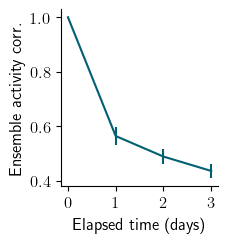

In [79]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corr_tot,axis=1),stats.sem(corr_tot,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr.pdf')

In [80]:
corrL = np.zeros((Nseed,4))
size = np.zeros((Nseed,4))

for seed in range(Nseed):
    V0 = V_list[0,:,seed]
    V1 = V_list[1,:,seed]
    V2 = V_list[2,:,seed]
    V3 = V_list[3,:,seed]
    
    corrL[seed,:] = [correlation(V0,V0),correlation(V0,V1),correlation(V0,V2),correlation(V0,V3)]
    size[seed,:] = [np.sum(V0>threshold),np.sum(V1>threshold),np.sum(V2>threshold),np.sum(V3>threshold)]
drift = np.sum(1-corrL[:,:],1)

In [81]:
drift

array([1.33174369, 1.14178409, 1.39064432, 1.46599429, 1.05748732,
       0.51624027, 1.37616432, 0.80281624, 0.86175053, 0.85325589,
       3.39449083, 0.69948523, 2.11329595, 2.66090318, 2.63355717,
       3.39075196, 1.04081354, 0.23139093, 0.80259094, 2.7625342 ,
       1.23352987, 2.77075912, 0.97945472, 0.4142032 , 2.79973188,
       2.23455122, 0.96202296, 1.02979583, 0.77322473, 1.76876756,
       0.82105543, 2.6932898 , 0.48196361, 2.63213571, 1.24502279,
       1.44899749, 1.29069144, 2.59499648, 0.90772164, 2.0693078 ,
       2.79054827, 3.39085012, 1.5145277 , 2.04841608, 0.97496961,
       1.13792317, 1.09632118, 3.33108095, 0.30575405, 2.7784337 ,
       0.62229026, 2.67064235, 2.77480203, 0.91105058, 2.63654976,
       0.55039421, 1.75404351, 1.45916299, 2.64889892, 1.51190425,
       1.35610252, 1.95153101, 1.2838507 , 1.37573244, 1.31235799,
       1.19794272, 0.72104004, 0.66990264, 1.3106943 , 1.90000452,
       0.62715574, 0.92588046, 0.30254986, 0.63858669, 1.20326

Text(0, 0.5, 'size of engram')

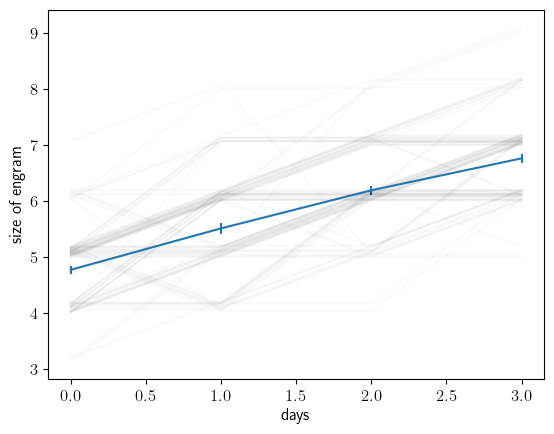

In [82]:
plt.errorbar([0,1,2,3],np.mean(size,axis = 0),stats.sem(size,axis = 0))
for seed in range(Nseed):
    plt.plot([0,1,2,3],size[seed,:]+random.random()*.2,'k', alpha = .02)
plt.xlabel('days')
plt.ylabel('size of engram')

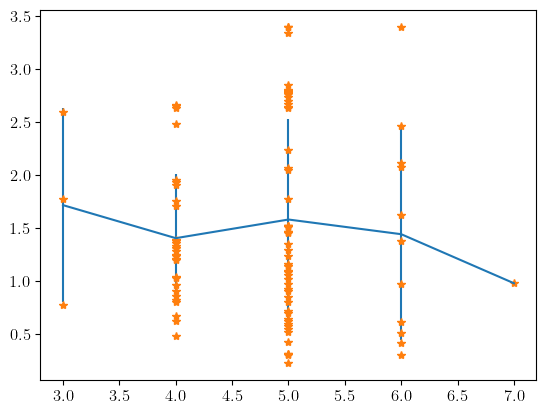

In [83]:
X = range(3,8)
Y = []
errY = []
for s in X:
    l = np.where(size[:,0] == s)[0]
    l_drift = np.zeros(len(l))
    for i in range(len(l)):
        l_drift[i] = drift[l[i]]
    Y.append(np.mean(l_drift))
    try:
        errY.append(statistics.stdev(l_drift))
    except:
        errY.append(0)

plt.errorbar(X,Y,errY)
plt.plot(size[:,0],drift,'*')

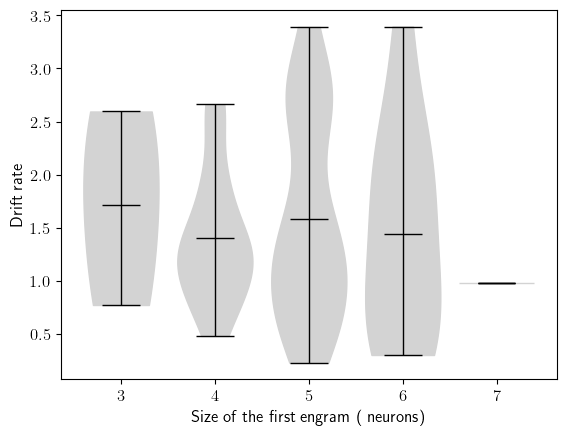

In [110]:
import matplotlib.pyplot as plt
import numpy as np


for s in range(3,8):
    l = np.where(size[:,0] == s)[0]
    l_drift = np.zeros(len(l))
    for i in range(len(l)):
        l_drift[i] = drift[l[i]]
        
    positions = [s]
    parts = plt.violinplot(dataset=l_drift,positions=positions,widths = .8,showmeans=True, showmedians=False);
    for pc in parts['bodies']:
        pc.set_facecolor('lightgray')
        pc.set_edgecolor('lightgray')
        pc.set_alpha(1)

    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = parts[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1)

plt.xlabel('Size of the first engram ( neurons)')
plt.ylabel('Drift rate');
plt.savefig('driftVSsize.pdf')


## Revision: drift rate vs size engram for different E

In [34]:
# beautiful ordinal
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [36]:
Nseed = 10
EL = [0,.5,1,1.5,2,2.5,3]
V_list = np.zeros([4,N,Nseed,len(EL)])
for e in range(len(EL)):
    E = EL[e]
    for seed in range(Nseed):
        print(seed)

         # initialisation
        np.random.seed(seed)
        r0 = np.zeros(N)
        W0 = np.zeros(N*N)
        exc0 = np.zeros(N)
        exc0 = np.random.normal(0,sigma,N)
        exc0 = np.sqrt(exc0*exc0)
        #exc0 = np.random.uniform(0,sigma,N)
        theta0 = np.zeros(N)

        Emat = def_Emat(E,exc0)

        # run
        y = run(INPUT)
        exc = y[index[2][:],:]
        r = y[index[0][:],:]
        theta = y[index[3][:],:]


        V0 = r[:,2900]
        V1 = r[:,5900]
        V2 = r[:,8900]
        V3 = r[:,11900]
        V = np.array([V0,V1,V2,V3])
        V_list[:,:,seed,e] = V

        #plot_all()
        #plt.show()
np.save("V_list_E.npy", V_list)


0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [1918]:
V_list = np.load('V_list_E.npy')

In [1919]:
corr_tot = np.zeros((4,Nseed,len(EL)))
for e in range(len(EL)):
    for day in range(4):
        for seed in range(Nseed):
            corr_tot[day,seed,e] = correlation(V_list[0,:,seed,e],V_list[day,:,seed,e])
        

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

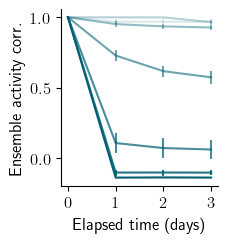

In [172]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

for e in range(len(EL)):
    ax.errorbar([0,1,2,3], np.mean(corr_tot[:,:,e],axis=1),stats.sem(corr_tot[:,:,e],axis = 1), color = color[1],alpha = (e+1)/len(EL))

    ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr.pdf')

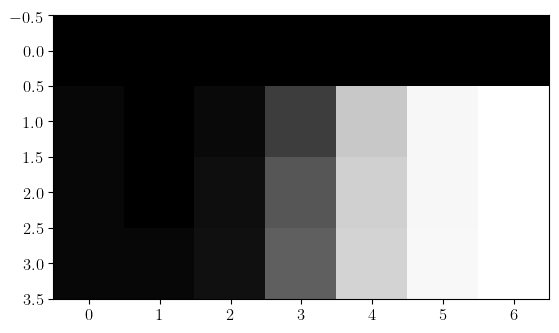

In [175]:
plt.imshow(np.mean(corr_tot[:,:,:],axis=1),cmap = 'binary')

In [183]:
size = np.zeros((4,Nseed,len(EL)))

for e in range(len(EL)):
    for day in range(4):
        for seed in range(Nseed):
            size[day,seed,e] = np.sum(V_list[day,:,seed,e] > threshold)


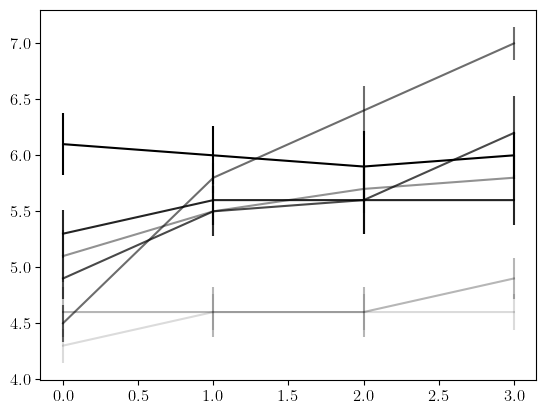

In [182]:
for e in range(len(EL)):
    plt.errorbar([0,1,2,3],np.mean(size[:,:,e],axis = 1),stats.sem(size[:,:,e],axis = 1),color='k',alpha = (e+1)/len(EL))


In [189]:
drift = np.max(1-corr_tot[:,:,:],0)

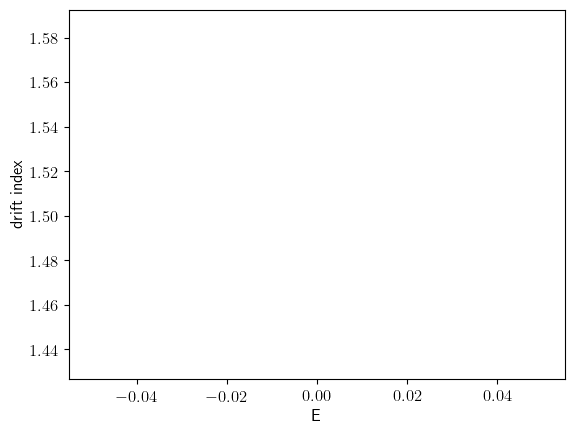

In [33]:
plt.plot(np.mean(drift,axis=0))
plt.xlabel('E')
plt.ylabel('drift index')
plt.savefig('driftVSE.png')

In [202]:
size

array([[[5., 5., 5., 4., 4., 5., 5.],
        [4., 4., 6., 5., 5., 5., 6.],
        [5., 4., 5., 4., 4., 5., 7.],
        [4., 5., 5., 5., 6., 7., 7.],
        [4., 4., 5., 5., 5., 5., 6.],
        [5., 4., 6., 5., 5., 5., 7.],
        [4., 4., 4., 4., 5., 5., 5.],
        [4., 6., 5., 4., 5., 5., 5.],
        [4., 5., 4., 4., 5., 6., 6.],
        [4., 5., 6., 5., 5., 5., 7.]],

       [[5., 5., 5., 5., 5., 5., 6.],
        [5., 4., 6., 6., 6., 6., 7.],
        [5., 4., 5., 5., 5., 5., 5.],
        [5., 5., 5., 6., 5., 6., 6.],
        [4., 4., 5., 6., 6., 7., 7.],
        [5., 4., 6., 6., 7., 6., 7.],
        [4., 4., 5., 6., 5., 6., 6.],
        [4., 6., 6., 6., 5., 5., 5.],
        [4., 5., 5., 6., 5., 5., 6.],
        [5., 5., 7., 6., 6., 5., 5.]],

       [[5., 5., 6., 6., 7., 6., 4.],
        [5., 4., 6., 7., 6., 7., 7.],
        [5., 4., 5., 5., 5., 4., 5.],
        [5., 5., 6., 6., 5., 6., 7.],
        [4., 4., 5., 7., 4., 6., 6.],
        [5., 4., 6., 7., 5., 4., 5.],
        

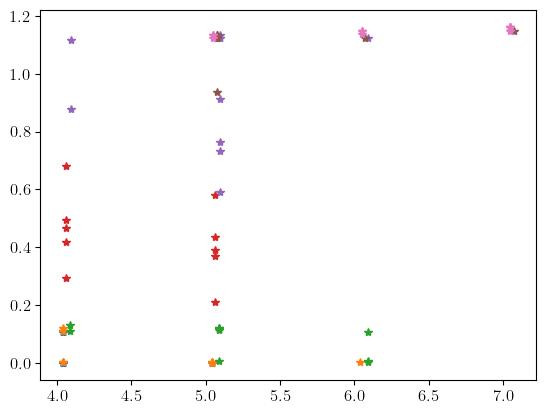

In [201]:
for e in range(len(EL)):
    plt.plot(size[0,:,e]+random.random()*.1,drift[:,e],'*')

In [203]:
size[0,:,e]

array([5., 6., 7., 7., 6., 7., 5., 5., 6., 7.])

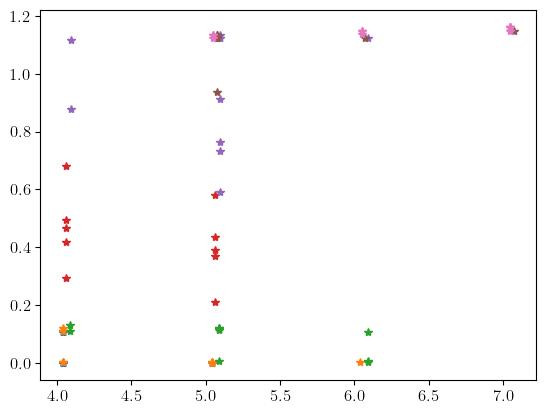

In [201]:
for e in range(len(EL)):
    plt.plot(size[0,:,e],drift[:,e],'*')

In [219]:
size[0,:,e]

array([4., 5., 4., 5., 5., 5., 4., 4., 4., 5.])

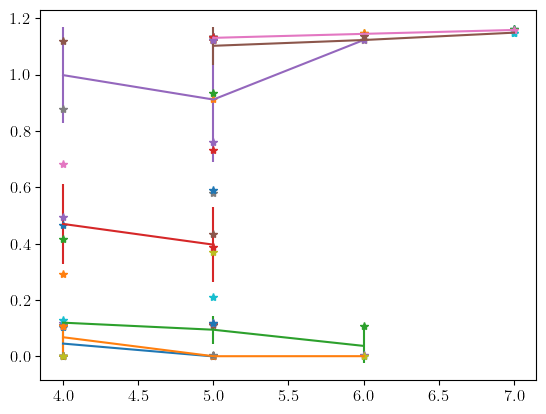

In [227]:
X = range(3,8)
for e in range(len(EL)):
#for e in [6]:
    Y = []
    errY = []
    for s in X:
        l = np.where(size[0,:,e] == s)[0]
        l_drift = np.zeros(len(l))
        for i in range(len(l)):
            l_drift[i] = drift[l[i],e]
        try:
            Y.append(np.mean(l_drift))
        except:
            Y.append([])
        try:
            errY.append(statistics.stdev(l_drift))
        except:
            errY.append(0)

    plt.errorbar(X,Y,errY)
    for s in range(Nseed):
        plt.plot(size[0,s,e],drift[s,e],'*')
#plt.plot(size[:,0],drift,'*')

In [139]:
l_drift

array([1.33174369, 1.39064433, 1.37616287, 0.80281624, 0.86175054,
       2.66090318, 2.63355717, 1.04081354, 1.23352987, 0.96202296,
       1.02979583, 0.82105544, 0.48196361, 1.24502279, 0.62229026,
       0.91105058, 1.75404351, 2.64889892, 1.35610252, 1.951531  ,
       1.28385042, 1.31235755, 1.19794272, 0.66990264, 1.31069431,
       1.90000452, 1.20326764, 1.93658737, 2.4787109 , 1.70924101])

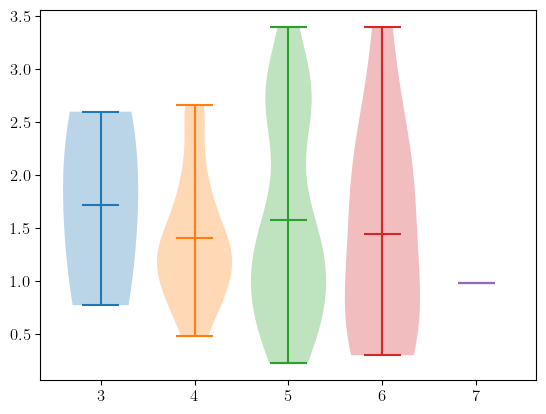

In [165]:
for s in range(3,8):
    l = np.where(size[:,0] == s)[0]
    l_drift = np.zeros(len(l))
    for i in range(len(l)):
        l_drift[i] = drift[l[i]]
        
    plt.violinplot(dataset=l_drift,positions=[s],widths = .8,showmeans=True, showextrema=True, showmedians=False);

## Revision sparsity
increased IN

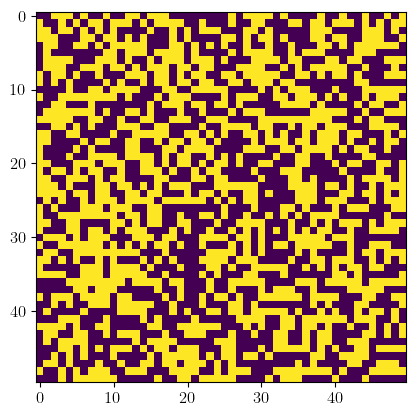

In [4207]:
np.random.seed(4)
mask = np.random.randint(2, size=(N, N))
plt.imshow(mask)

In [4208]:
mask

array([[0, 0, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 1, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [4209]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    thetaL=np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0,Wout0,rout0,thetaout0))
    y = np.zeros((len(y0),nstep))
    routbis = np.zeros((4,nstep))

    y[:,0] = y0
    
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [4210]:
# main function
routbis = np.zeros((4,nstep))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    Wout = yt[index[4]].reshape((1,N))
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T
    thetaout = yt[index[6]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=cap,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    # sparsity
    dWdt = np.multiply(dWdt,mask)
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    rout = Wout.dot(r)[0]
    routbis[0,t] = rout
    dWoutdt = (1 - np.sum(Wout))*r.T * rout/200 - Wout/1000
    #dWoutdt = r.T * rout/1000 - Wout/1000
    #dWoutdt = (rout * (rout-thetaout) * r.T )/ 4000
    #dWoutdt = np.multiply(dWoutdt,Wout<10)
    dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout<=0,dWoutdt<0)))
    #dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout>=10,dWoutdt>0)))
    #droutdt = (Wout.dot(r) - rout) /1
    #dthetaoutdt = ((rout*rout)/.2 - thetaout)/10
    dthetaoutdt = np.zeros((1))
    droutdt = np.zeros((1))
    S.append(np.sum(Wout))
    
    if t > 3000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[1,t] = Wout.dot(r)[0]

    if t > 6000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[2,t] = Wout.dot(r)[0]
        
    if t > 9000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[3,t] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten(),
                           droutdt.flatten(),
                           dthetaoutdt.flatten()))

    return dydt

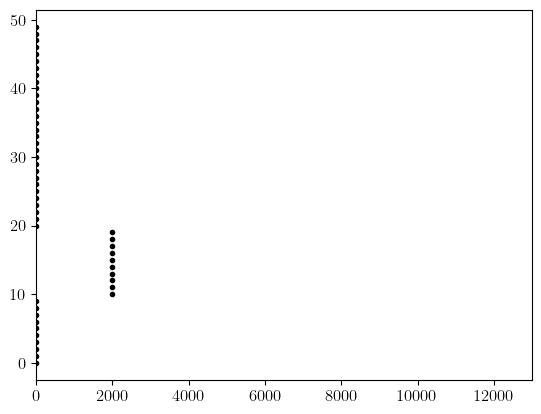

In [4211]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)
rout0 = np.zeros(1)
Wout0 = np.zeros(N) + .001
thetaout0 = np.zeros(1)

nstep = 13000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000

seq = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
    
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1


tag = np.zeros(N)
 
#tag[:10] = 1
#tag[25] = 2000

#tag = np.arange(1,nstep,nstep/N)

#tag[:10] = np.arange(1,1000,100)
#tag[10:20] = np.arange(2000,3000,100)

tag[:10] = 1
tag[10:20] = 2000

plt.plot(tag,range(N),'k.')
plt.xlim([0,nstep])
         
index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N),
         range(N + N*N +N+N+N,N + N*N +N+N+N+1),
         range(N + N*N +N+N+N+1,N + N*N +N+N+N+1+1)]
         
         
         
         
         

In [4212]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [4213]:
# works previous decoder
threshold = 5

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [20]
seedL = [7]
cap = 1
(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [4214]:
# works ok with new decoder
threshold = 5

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [7]
I1L = [.6]
#EL = np.arange(0,3.1,.1)
#EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [18]
seedL = [7]
capL = [1.2]
(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])
(800, 20, 100, 10, 0.5, 1.5, 2, 1, 1000, 18, 7)

(800, 20, 100, 10, 0.5, 1.5, 2, 1, 1000, 18, 7)

In [4215]:
# works ok
threshold = 5

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [7]
I1L = [.7]
#EL = np.arange(0,3.1,.1)
#EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [18]
seedL = [3]
capL = [1]
(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])
(800, 20, 100, 10, 0.5, 1.5, 2, 1, 1000, 18, 7)

(800, 20, 100, 10, 0.5, 1.5, 2, 1, 1000, 18, 7)

In [4221]:
# test
threshold = 5

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [7]
I1L = [.8]
#EL = np.arange(0,3.1,.1)
#EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [20]
seedL = [6]
capL = [1]
(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])
(800, 20, 100, 10, 0.5, 1.5, 2, 1, 1000, 18, 7)

(800, 20, 100, 10, 0.5, 1.5, 2, 1, 1000, 18, 7)

In [4222]:
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)

exc0

array([0.20679514, 1.2122118 , 0.0653609 , 0.34674769, 0.11807299,
       1.04479378, 0.67882999, 1.30952683, 0.5979118 , 0.90844514,
       0.64530814, 1.26205311, 0.0921834 , 0.85525152, 2.60951951,
       0.18957997, 0.26228926, 0.95697004, 0.53066454, 0.33383776,
       1.70735998, 0.90230473, 1.21404379, 2.52047613, 1.56392903,
       0.21178424, 0.71056101, 1.24623212, 0.96225669, 0.15249584,
       1.18256464, 0.67305515, 1.6806523 , 0.65045128, 0.45851141,
       0.19173912, 1.1361113 , 1.37277575, 1.26377778, 0.1429269 ,
       0.59405578, 0.45433393, 0.29369088, 0.2401508 , 2.18023738,
       2.67459351, 0.74541977, 0.16196535, 0.04476357, 1.1415592 ])

(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 6, 1)
1.7012019161933194
0.7998626727486646


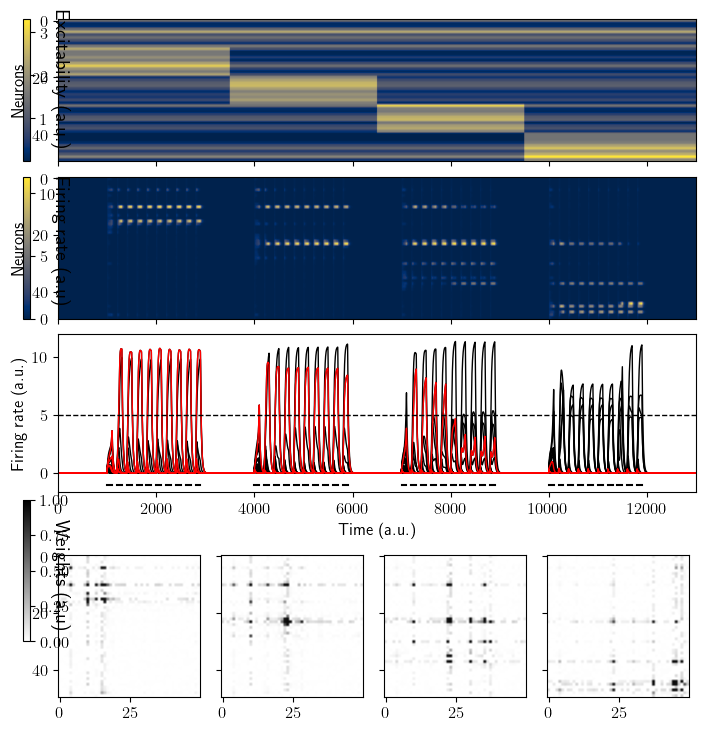

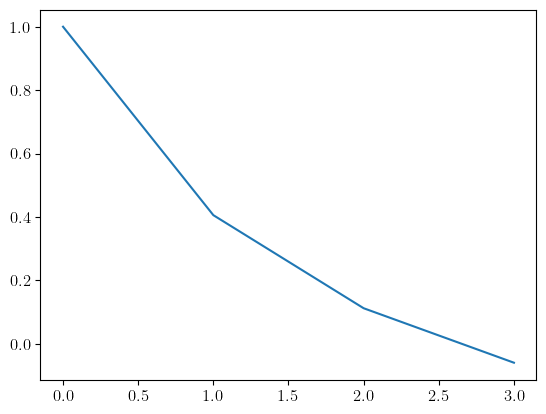

In [4223]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,cap) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL,capL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,cap))
    
    
     # initialisation
    np.random.seed(seed)
    random.seed(seed)
    mask = np.random.randint(2, size=(N, N))

    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    rout = y[index[5][:],:] 
    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    
    # decoder ordinal
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            #print(V[perm[i],:])
            s += correlation(V[perm[i],:],V[perm[i+1],:])
        s = s
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
 
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_suffled[:,i] = line
 
    
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[perm[i],:],V_list_suffled[perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    
    
    plot_all()
    #plt.savefig('all.pdf')

    plt.show()
  

    plt.plot([correlation(V0,V0),correlation(V0,V1),correlation(V0,V2),correlation(V0,V3)])
    plt.show()




### figure

In [4224]:
threshold = 5

In [4225]:
active = r[:,2850]>threshold

In [4226]:
active = np.where(active)[0]

In [4227]:
L = np.array(range(N))
for l in active:
    L = np.delete(L,l)

In [4228]:
L = [i for i in range(N) if i not in active]

In [4229]:
active

array([10, 15])

In [4230]:
cmap = reversed(["20331a","33512a","446c37","558745","66a253","7cb36b","94c186","abcea1","c3dcbc","dbead7"])
cmap2 = ["ffffff","005F73"]

In [4231]:
import matplotlib.colors as mcolors
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

cmap = get_continuous_cmap(cmap)
cmap2 = get_continuous_cmap(cmap2)

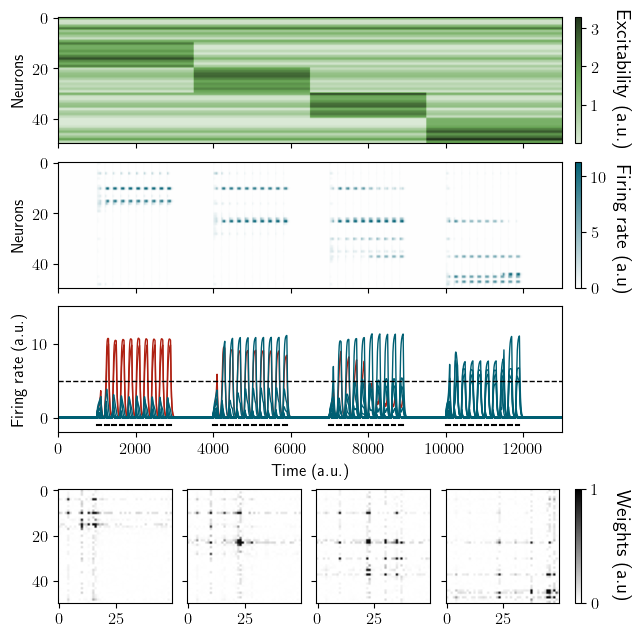

In [4232]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(160*mm,160*mm), facecolor='w',frameon=False)

ax1 = fig.add_axes([.04,.79,.88,.2]) # [left, bottom, width, height] 
ax2 = fig.add_axes([.04,.56,.88,.2])
ax3 = fig.add_axes([.08,.33,.8,.2])

w = .18
ax5 = fig.add_axes([.08,.06,w,w])
ax6 = fig.add_axes([.285,.06,w,w])
ax7 = fig.add_axes([.49,.06,w,w])
ax8 = fig.add_axes([.695,.06,w,w])


im = ax1.imshow(Emat,aspect = nstep/N*2/8,cmap = cmap)
ax1.set_ylabel('Neurons')
ax1.set_xticklabels('')
cbar1 = plt.colorbar(im,cax = plt.axes([.9, 0.79, 0.01, 0.2])) # [left, bottom, width, height] 
cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=-.09,x=6)

im = ax2.imshow(np.maximum(0,r),aspect = nstep/N*2/8,cmap = cmap2)
ax2.set_ylabel('Neurons')
ax2.set_xticklabels('')
cbar2 = plt.colorbar(im,cax = plt.axes([.9, 0.56, 0.01, 0.2])) # [left, bottom, width, height] 
cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=-.09,x=6)

for n in active:
    ax3.plot(r[n,:],color[8],linewidth = 1)
for n in L:
    ax3.plot(r[n,:],color[1],linewidth = 1)


ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
ax3.set_xlabel('Time (a.u.)')
ax3.set_ylabel('Firing rate (a.u.)')

ax3.set_xlim([0,nstep])
ax3.set_ylim([-2,15])

h = -1
for s in range(int(len(seq)/2)):
    ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
ax6.set_yticklabels('')
ax7.set_yticklabels('')
ax8.set_yticklabels('')

cbar3 = plt.colorbar(im,cax = plt.axes([.9, 0.06, 0.01, 0.18]))
cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=-.02,x=6)
cbar3.set_ticks([0,1])
plt.savefig('all_sparsity.pdf')

In [4233]:
Nseed = 10
V_list = np.zeros([4,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    
    mask = np.random.randint(2, size=(N, N))


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)


    # run
    y = run(INPUT)
    r = y[index[0][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]

    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V
        
    
np.save("V_list_sparsity.npy", V_list)

0
1


KeyboardInterrupt: 

In [4015]:
#np.save("V_list.npy", V_list)
V_list = np.load('V_list_sparsity.npy')

In [4016]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])
        

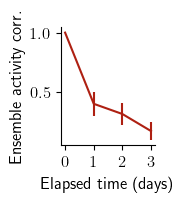

In [4018]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(30*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corr_tot,axis=1),stats.sem(corr_tot,axis = 1), color = color[8])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_sparsity.pdf',bbox_inches='tight')

### figure

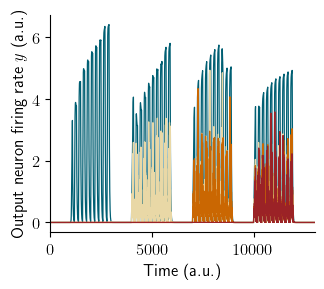

In [122]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(80*mm,70*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.16,0.18,.84,.79])

lw = .9
ax.plot(routbis[0,:],color[1],linewidth=lw);
ax.plot(routbis[1,:],color[4],linewidth=lw);
ax.plot(routbis[2,:],color[6],linewidth=lw);
ax.plot(routbis[3,:],color[9],linewidth=lw);

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,13000])
plt.savefig('decode_rate.pdf')




### figure

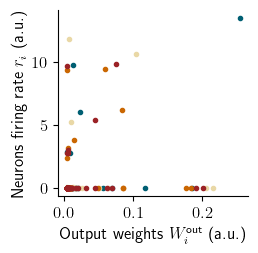

In [123]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(70*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


for t in [2900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[1])
for t in [5900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[4])
for t in [8900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[6])
for t in [11900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[9])

ax.set_xlabel(r'Output weights $W^{\text{out}}_i$ (a.u.)')
ax.set_ylabel(r'Neurons firing rate $r_i$ (a.u.)')
ax.set_yticks([0,5,10])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf')

### figure

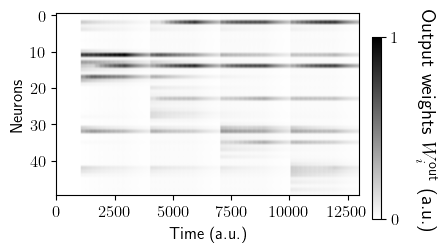

In [124]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(110*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.12,0.2,.7,.77])


ax.imshow(Wout, aspect='auto', cmap = 'binary')
cbar3 = plt.colorbar(im,cax = plt.axes([.85, 0.1, 0.02, 0.77]))
cbar3.ax.set_title(r'Output weights $W^{\text{out}}_i$ (a.u.)', rotation=270,loc='left',y=-.1,x=5)
cbar3.set_ticks([0,1])


ax.set_ylabel('Neurons')
ax.set_xlabel('Time (a.u.)')

plt.savefig('weights.pdf')

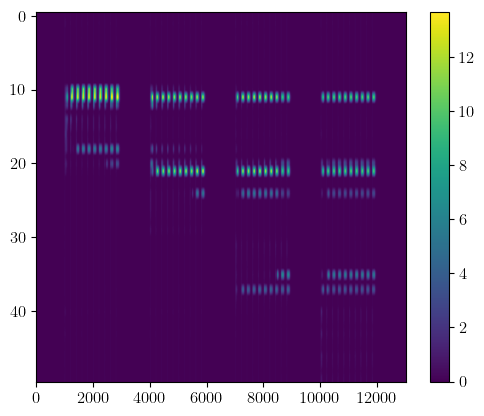

In [125]:
plt.figure()
plt.imshow(r,aspect = nstep/N)
plt.colorbar()

In [126]:
r[:,2900]

array([1.99603578e-03, 2.77503198e-03, 2.15014350e-03, 2.43503085e-03,
       2.28449623e-03, 2.58309475e-03, 2.32892273e-03, 2.31953845e-03,
       1.98501193e-03, 2.10675196e-03, 9.75785481e+00, 1.34555900e+01,
       2.75469109e+00, 3.09147615e-03, 1.09953007e-02, 1.55432235e-02,
       5.76087002e-03, 7.97882889e-03, 5.98386637e+00, 3.28392795e-03,
       2.81585025e+00, 3.65072320e-03, 2.16924620e-03, 2.00706611e-03,
       2.23029099e-03, 2.23504583e-03, 2.21257003e-03, 2.14002706e-03,
       2.02989625e-03, 2.27712962e-03, 2.08993949e-03, 2.21044971e-03,
       2.11518211e-03, 2.18373242e-03, 2.15045970e-03, 2.16694201e-03,
       2.19054655e-03, 2.41007560e-03, 2.12636581e-03, 2.04201076e-03,
       2.85661222e-03, 2.21552631e-03, 2.11039908e-03, 2.58082264e-03,
       2.13499310e-03, 2.07423584e-03, 2.32625536e-03, 2.25023158e-03,
       2.03145407e-03, 2.33059789e-03])

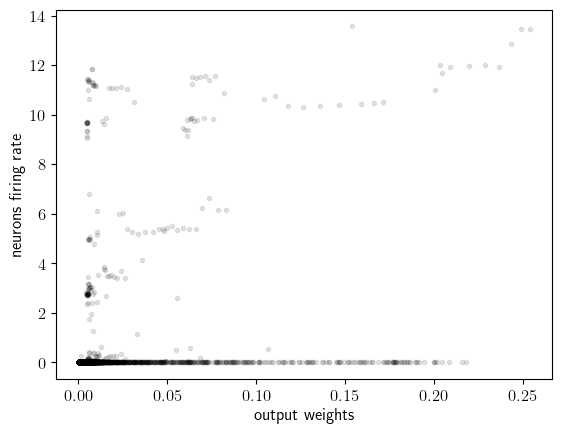

In [127]:
# weights vs rates
for t in np.arange(100,nstep,200):
    plt.plot(Wout[:,t],r[:,t],'k.', alpha = .1)
plt.xlabel('output weights')
plt.ylabel('neurons firing rate')
plt.savefig('decode_corr.png',dpi = 500)
plt.show()

### figure


In [4234]:
pos = np.array(range(N))
pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [4235]:
seedL = range(10)
WoutL = np.zeros((len(seedL),4))
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    
    mask = np.random.randint(2, size=(N, N))

    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    
    W1 = Wout[:,2900]
    W2 = Wout[:,5900]
    W3 = Wout[:,8900]
    W4 = Wout[:,11900]

    WoutL[seed,:] = np.array([sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)])
    

(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 0)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 1)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 2)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 3)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 4)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 5)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 6)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 7)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 8)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 9)


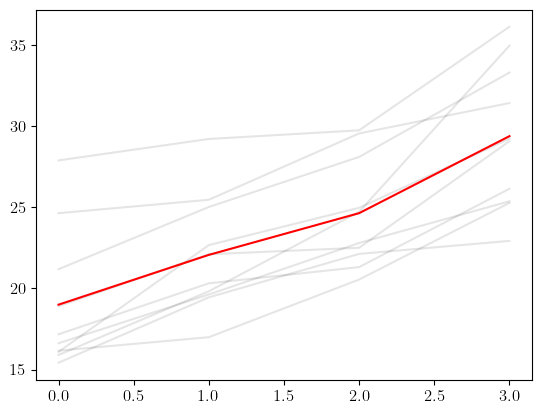

In [4236]:
for i in range(10):
    plt.plot(WoutL[i,:],'k',alpha=.1)
plt.plot(np.mean(WoutL,axis=0),'r')

In [4237]:
WoutLshuffled = np.copy(WoutL)
np.random.shuffle(WoutLshuffled.T)


In [4238]:
WoutL

array([[16.08698119, 22.66314328, 24.95878196, 29.21754106],
       [18.90034737, 22.10017664, 22.4992067 , 29.06266262],
       [21.17791191, 25.0095637 , 28.09303342, 33.28951142],
       [27.87929365, 29.19922789, 29.73247072, 36.11212846],
       [16.61817045, 19.62148272, 22.79299157, 25.36180521],
       [17.17034063, 20.30934866, 21.30911714, 26.13319394],
       [15.89987326, 19.81897358, 24.71189193, 34.94614747],
       [24.62933761, 25.45516487, 29.54012658, 31.41266098],
       [16.16314487, 16.99104307, 20.5426412 , 25.26301665],
       [15.41988356, 19.44530609, 22.12191834, 22.92141124]])

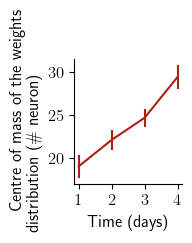

In [4239]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar([1,2,3,4],np.mean(WoutL,axis=0),stats.sem(WoutL),color = color[8])


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks([1,2,3,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr_sparsity.pdf',bbox_inches='tight')



### Run different seeds, fixed E, get V_list

In [4019]:
Nseed = 10
V_list = np.zeros([4,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V
        
    #plot_all()
    #plt.show()

0
1
2
3
4
5
6
7
8
9


In [4020]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])

corr_tot

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.88894941,  0.31301261,  0.74889191,  0.57128091,  0.78248696,
         0.32301142,  0.27908245,  0.95002597,  0.70304093,  0.82742917],
       [ 0.91499042,  0.33353661,  0.36561836,  0.36113753,  0.88728975,
         0.07932267,  0.65189079,  0.96237838,  0.72861516,  0.57457964],
       [ 0.91717629,  0.34192599, -0.06145201, -0.06224962,  0.15551308,
        -0.08234326,  0.67076771,  0.62560452,  0.72758004,  0.63924597]])

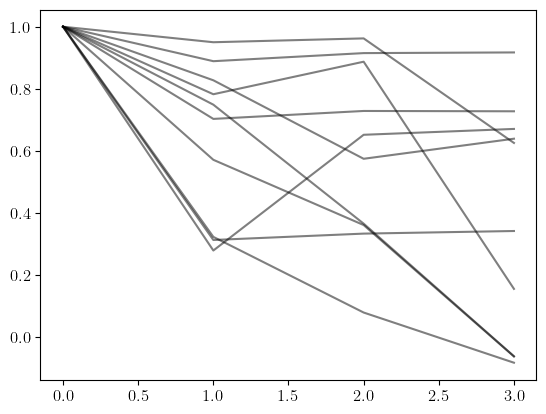

In [4021]:
for seed in range(Nseed):
    plt.plot(corr_tot[:,seed],'k', alpha = .5)

### figure

In [4022]:
Nseed = 10

In [4023]:
V_list_shuffled = np.copy(V_list)

In [4024]:
for seed in range(Nseed):
    for day in range(4):
        np.random.shuffle(V_list_shuffled[day,:,seed])

In [4025]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])
        
corr_tot_shuffled = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot_shuffled[day,seed] = correlation(V_list_shuffled[0,:,seed],V_list_shuffled[day,:,seed])

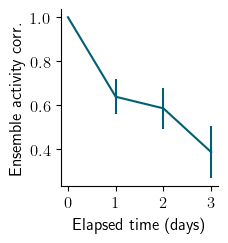

In [4026]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corr_tot,axis=1),stats.sem(corr_tot,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_sparsity.pdf')

### Ordinal time decoder, run different E, get t_mat

In [4198]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))

In [4199]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [4200]:
seedL = np.arange(0,10,1)
seedL

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4201]:
EL = [0,.2,.4,.6,.8,1]
EL = np.arange(0,3.2,.5)
Nseed = len(seedL)
EL

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ])

In [4202]:
t_mat = []
t_mat_shuffled = []
V_list = np.zeros([4,N,Nseed])
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    

     # initialisation
    np.random.seed(seed)
    
    mask = np.random.randint(2, size=(N, N))

    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    

    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]

    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V

    np.save("V_list.npy", V_list)

    # decoder ordinal
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            #print(V[perm[i],:])
            s += correlation(V[perm[i],:],V[perm[i+1],:])
        s = s
        s_corr.append(s)
    #print(s_corr)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    # shuffle
    
    #V_list_suffled = np.copy(V_list[:,:,seed])
    #np.random.shuffle(V_list_suffled.T)
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_suffled[:,i] = line
    
    #print(V_list[:,:,seed] == V_list_suffled)

    #print(V_list)
    #print(V_list_suffled)
    
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[perm[i],:],V_list_suffled[perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    #plot_all()
    #plt.savefig(str(E)+'all.pdf')

    plt.show()
    




(800, 20, 100, 7, 0.8, 0.0, 2, 1, 1000, 20, 0)
1.0101389199056676
-0.3533455552736568
(800, 20, 100, 7, 0.8, 0.0, 2, 1, 1000, 20, 1)
1.8320286099779608
-0.21768820370917707
(800, 20, 100, 7, 0.8, 0.0, 2, 1, 1000, 20, 2)
-0.36366045850176804
1.743977770468933
(800, 20, 100, 7, 0.8, 0.0, 2, 1, 1000, 20, 3)
-0.06201154231814637
0.6874274035709663
(800, 20, 100, 7, 0.8, 0.0, 2, 1, 1000, 20, 4)
1.375500135655187
-0.848099956324481
(800, 20, 100, 7, 0.8, 0.0, 2, 1, 1000, 20, 5)
-0.8883837046193112
-1.5215918132580368
(800, 20, 100, 7, 0.8, 0.0, 2, 1, 1000, 20, 6)
0.02051590020374464
0.6614415419471715
(800, 20, 100, 7, 0.8, 0.0, 2, 1, 1000, 20, 7)
0.24239746479549745
-0.8042130053338389
(800, 20, 100, 7, 0.8, 0.0, 2, 1, 1000, 20, 8)
0.6801516215766833
1.567424417277574
(800, 20, 100, 7, 0.8, 0.0, 2, 1, 1000, 20, 9)
-1.5383772722620477
-0.24347670239119815
(800, 20, 100, 7, 0.8, 0.5, 2, 1, 1000, 20, 0)
1.5854517666640457
1.2053350033230898
(800, 20, 100, 7, 0.8, 0.5, 2, 1, 1000, 20, 1)
0.9048

In [4203]:
#np.save("t_mat_sparsity.npy", t_mat)
#np.save("t_mat_shuffled_sparsity.npy", t_mat_shuffled)
#t_mat = np.load("t_mat_sparsity.npy")
#t_mat_shuffled = np.load("t_mat_shuffled_sparsity.npy")

In [4204]:
t_mat = np.array(t_mat).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled = np.array(t_mat_shuffled).reshape((len(EL),len(decayL),len(seedL)))

decay = 0
t_mat = t_mat[:,decay,:]
t_mat_shuffled = t_mat_shuffled[:,decay,:]

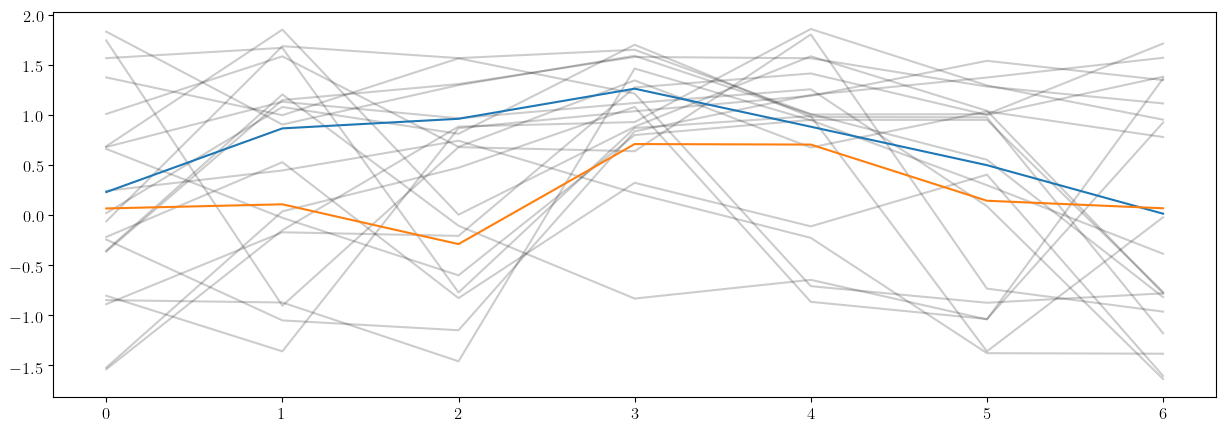

In [4205]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat[:,seed],'k', alpha = .2)
    plt.plot(t_mat_shuffled[:,seed],'k', alpha = .2)
plt.plot(np.mean(t_mat,axis = 1))
plt.plot(np.mean(t_mat_shuffled,axis = 1))
#plt.xticks(range(len(EL)),lab);

### figure

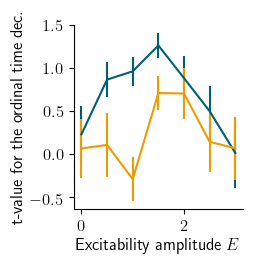

In [4206]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat,axis = 1),stats.sem(t_mat,axis = 1),color = color[1])
ax.errorbar(EL,np.mean(t_mat_shuffled,axis = 1),stats.sem(t_mat_shuffled,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('tVSE_sparsity.pdf',dpi = 1000,bbox_inches='tight')



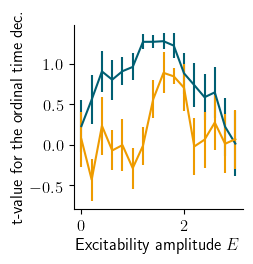

In [4035]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat,axis = 1),stats.sem(t_mat,axis = 1),color = color[1])
ax.errorbar(EL,np.mean(t_mat_shuffled,axis = 1),stats.sem(t_mat_shuffled,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('tVSE_sparsity.pdf',dpi = 1000,bbox_inches='tight')



## Revision: 2 memories
increased decayL,decayout

In [20]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    thetaL=np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0,Wout0,rout0,thetaout0))
    y = np.zeros((len(y0),nstep))
    routbis = np.zeros((4,nstep))

    y[:,0] = y0
    
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [5775]:
# main function
routbis = np.zeros((4,nstep))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    Wout = yt[index[4]].reshape((1,N))
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T
    thetaout = yt[index[6]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t,ctxA,seqA)[np.newaxis].T + INPUT(t,ctxB,seqB)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=cap,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    rout = Wout.dot(r)[0]
    routbis[0,t] = rout
    dWoutdt = (1 - np.sum(Wout))*r.T * rout/200 - Wout/1000
    #dWoutdt = r.T * rout/1000 - Wout/1000
    #dWoutdt = (rout * (rout-thetaout) * r.T )/ 4000
    #dWoutdt = np.multiply(dWoutdt,Wout<10)
    dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout<=0,dWoutdt<0)))
    #dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout>=10,dWoutdt>0)))
    #droutdt = (Wout.dot(r) - rout) /1
    #dthetaoutdt = ((rout*rout)/.2 - thetaout)/10
    dthetaoutdt = np.zeros((1))
    droutdt = np.zeros((1))
    S.append(np.sum(Wout))
    
    if t > 3000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[1,t] = Wout.dot(r)[0]

    if t > 6000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[2,t] = Wout.dot(r)[0]
        
    if t > 9000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[3,t] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten(),
                           droutdt.flatten(),
                           dthetaoutdt.flatten()))

    return dydt

In [5776]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)
rout0 = np.zeros(1)
Wout0 = np.zeros(N) + .001
thetaout0 = np.zeros(1)

In [5777]:
nstep = 25000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000


seqA = []
seqB = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seqA.append(pause + i*stim + 2*delay*ev)
        seqA.append(pause + i*stim + duration + 2*delay*ev)
        
    for i in range(Nstim):
        seqB.append(pause + i*stim + delay + 2*delay*ev)
        seqB.append(pause + i*stim + duration + delay + 2*delay*ev)


def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * ctx * L/2 + 1

 

In [5778]:
ctxA

array([1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.])

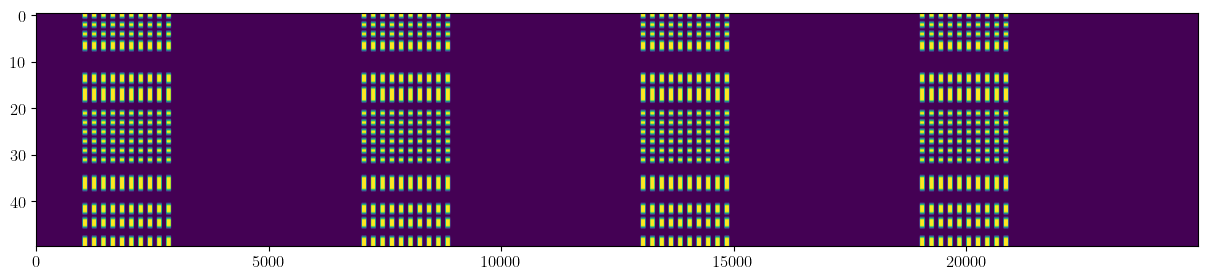

In [5779]:
X = np.arange(nstep)
Y = np.array([INPUT(t,ctxA,seqA) for t in X])
plt.figure(figsize=(15,30))
plt.imshow(Y.T,aspect = 100)

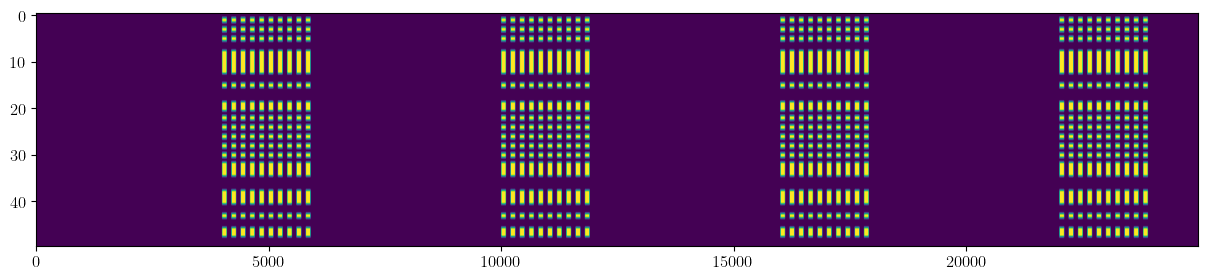

In [5780]:
X = np.arange(nstep)
Y = np.array([INPUT(t,ctxB,seqB) for t in X])
plt.figure(figsize=(15,30))
plt.imshow(Y.T,aspect = 100)

In [5781]:
index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N),
         range(N + N*N +N+N+N,N + N*N +N+N+N+1),
         range(N + N*N +N+N+N+1,N + N*N +N+N+N+1+1)]

In [5782]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:6500] = E
    Emat[20:30,6500:12500] = E
    Emat[30:40,12500:18500] = E
    Emat[40:50,18500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [5783]:
#  works 2 memories
threshold = 3

decayL = [1500]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = [1.5]
#EL = [3.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [0]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [5784]:
# works ok but reactivations not high
threshold = 5

decayL = [2000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = [1.5]
#EL = [3.5]
y0L = [2]
sigmaL = [1]
INL = [12]
seedL = [0]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [5785]:
# works but bad reactivation


threshold = 5

decayL = [4000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.9]
EL = [1.5]
#EL = [0]

EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [1]
cap = 1


(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [5786]:
threshold = 5 # almost works, bad reactivation

decayL = [4000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [10]
I1L = [1]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [12]
seedL = [5]
cap = 1.5


(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [5787]:
# better ?
threshold = 5 
decayL = [4000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [8]
I1L = [1]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [12]
seedL = [0]
cap = 1.5

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [5788]:
# test 
threshold = 3

decayL = [1500]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = [1.5]
#EL = [3.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [0]
cap = 1

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [5789]:
# works 
threshold = .5 
decayL = [4000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [1]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [2]
cap = 1.5


(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [5790]:
# test 
threshold = 4
decayL = [4000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [10]
I1L = [1]
EL = [1.8]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [7]
cap = 1.5


(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


(800, 20, 100, 10, 1, 1.8, 2, 1, 4000, 15, 7)
1.5081841316039295
1.2931943962689747
1.137245782180328
-1.215474139306076


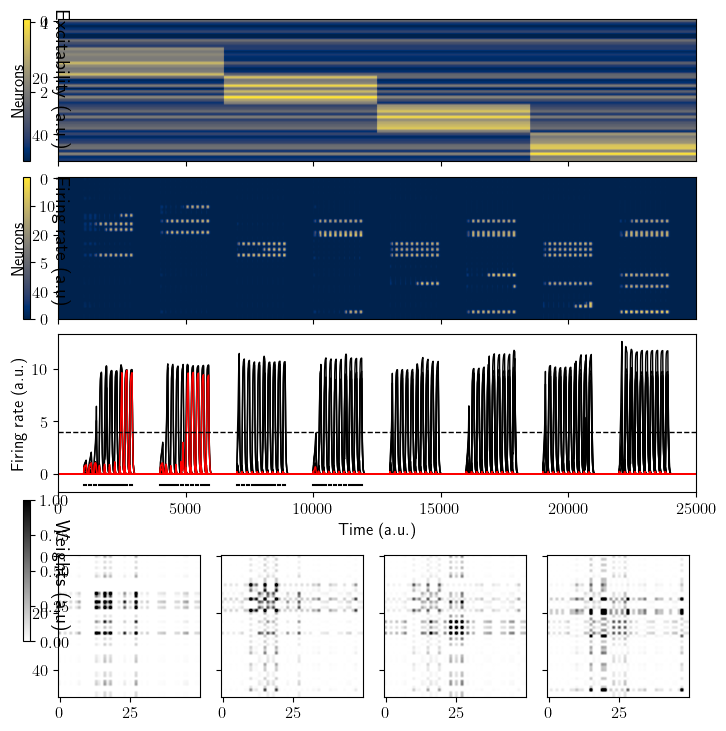

In [5791]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
          # initialisation
    np.random.seed(seed)
    random.seed(seed)
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    #ctxA = np.zeros(N) + 1
    random.shuffle(ctxA)
    ctxB = 1 - ctxA
    #ctxB = 0


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)



    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    rout = y[index[5][:],:] 
    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V4 = r[:,14900]
    V5 = r[:,17900]
    V6 = r[:,20900]
    V7 = r[:,23900]
    
    V_list = np.array([V0,V1,V2,V3,V4,V5,V6,V7])
        
    

    # decoder ordinal A
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list[2*perm[i],:],V_list[2*perm[i+1],:])
            #print((2*perm[i],2*perm[i+1]))
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    
    
    #print(s_corr[0])
    #plt.hist(s_corr)
   # plt.show()
    
    # decoder ordinal B
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list[2*perm[i]+1,:],V_list[2*perm[i+1]+1,:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    
    
    
    V_list_suffled = np.copy(V_list)
    np.random.shuffle(V_list_suffled)


    # shuffle A
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            2*perm[i+1]
            s += correlation(V_list_suffled[2*perm[i],:],V_list_suffled[2*perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    # shuffle B
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[2*perm[i]+1,:],V_list_suffled[2*perm[i+1]+1,:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    
    
    plot_all()
    #plt.savefig('all.pdf')

    plt.show()
 





### figure

In [42]:
active = r[:,2850]>threshold
active2 = r[:,5850]>threshold
active = np.where(active)[0]
active2 = np.where(active2)[0]

In [43]:
np.concatenate((active,active2))

array([16, 23, 27, 45, 10, 15, 19, 47])

In [44]:
nonactive = [i for i in range(N) if i not in np.concatenate((active,active2))]

In [45]:
cmap = reversed(["20331a","33512a","446c37","558745","66a253","7cb36b","94c186","abcea1","c3dcbc","dbead7"])
cmap2 = ["ffffff","005F73"]

In [46]:
import matplotlib.colors as mcolors
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

cmap = get_continuous_cmap(cmap)
cmap2 = get_continuous_cmap(cmap2)

In [47]:
def plot_2memories(ctx = 'A'):
    mm = 1/2.54/10 
    fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
    rc('text', usetex=True)
    rc('font',**fontProperties)
    fig = plt.figure(figsize=(160*mm,160*mm), facecolor='w',frameon=False)

    ax1 = fig.add_axes([.04,.79,.88,.2]) # [left, bottom, width, height] 
    ax2 = fig.add_axes([.04,.56,.88,.2])
    ax3 = fig.add_axes([.08,.33,.8,.2])

    w = .18
    ax5 = fig.add_axes([.08,.06,w,w])
    ax6 = fig.add_axes([.285,.06,w,w])
    ax7 = fig.add_axes([.49,.06,w,w])
    ax8 = fig.add_axes([.695,.06,w,w])


    im = ax1.imshow(Emat[:,:25000],aspect = 25000/N*2/8,cmap = cmap)
    ax1.set_ylabel('Neurons')
    ax1.set_xticklabels('')
    cbar1 = plt.colorbar(im,cax = plt.axes([.9, 0.79, 0.01, 0.2])) # [left, bottom, width, height] 
    cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=-.09,x=6)

    im = ax2.imshow(r[:,:25000],aspect = 25000/N*2/8,cmap = cmap2)
    ax2.set_ylabel('Neurons')
    ax2.set_xticklabels('')
    cbar2 = plt.colorbar(im,cax = plt.axes([.9, 0.56, 0.01, 0.2])) # [left, bottom, width, height] 
    cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=-.09,x=6)

    for n in active:
        ax3.plot(r[n,:],color[8],linewidth = 1)
    for n in active2:
        ax3.plot(r[n,:],color = '#558745',linewidth = 1)
    for n in nonactive:
        ax3.plot(r[n,:],color[1],linewidth = 1)


    ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
    ax3.set_xlabel('Time (a.u.)')
    ax3.set_ylabel('Firing rate (a.u.)')

    ax3.set_xlim([0,25000])
    ax3.set_ylim([-2,15])

    h = -1
    for s in range(int(len(seq)/2)):
        ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')

    if ctx == 'A':
        im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax6.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax7.imshow(y[index[1][:],15000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax8.imshow(y[index[1][:],21000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
    else:
        im = ax5.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax6.imshow(y[index[1][:],12000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax7.imshow(y[index[1][:],18000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax8.imshow(y[index[1][:],24000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
        
    ax6.set_yticklabels('')
    ax7.set_yticklabels('')
    ax8.set_yticklabels('')

    cbar3 = plt.colorbar(im,cax = plt.axes([.9, 0.06, 0.01, 0.18]))
    cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=-.02,x=6)
    cbar3.set_ticks([0,1])
    plt.savefig('all'+ctx+'.pdf')

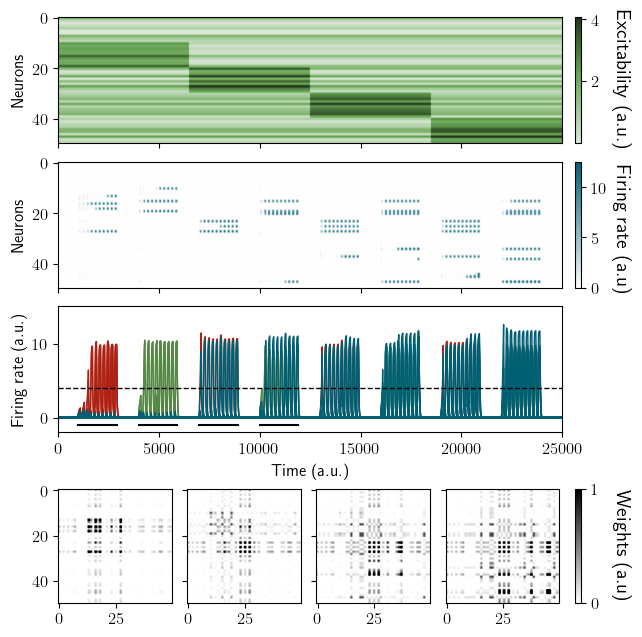

In [5798]:
plot_2memories(ctx = 'A')

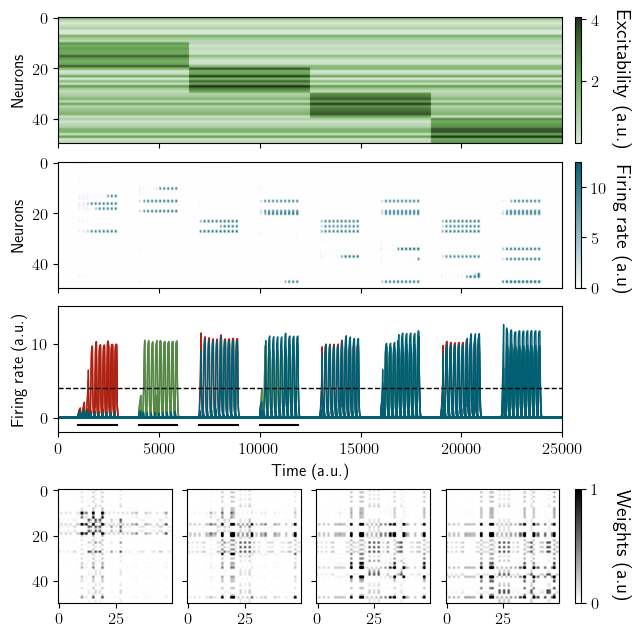

In [5799]:
plot_2memories(ctx = 'B')

### VList and correlations

In [5703]:
Nseed = 10
V_list = np.zeros([8,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    random.seed(seed)
    
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    ctxB = 1 - ctxA


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)


    # run
    y = run(INPUT)
    r = y[index[0][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V4 = r[:,14900]
    V5 = r[:,17900]
    V6 = r[:,20900]
    V7 = r[:,23900]
    V = np.array([V0,V1,V2,V3,V4,V5,V6,V7])
    V_list[:,:,seed] = V
        
    #plot_2memories(ctx = 'A')
    #plt.show()
    #plot_2memories(ctx = 'B')
    #plt.show()
    
#np.save("V_list_2memories.npy", V_list)

0
1
2
3
4
5
6
7
8
9


In [5704]:
#V_list = np.load('V_list_2memories.npy')

In [5705]:
np.max(V_list)

12.008648821426263

In [5706]:
V_list.shape

(8, 50, 10)

In [5707]:
corrA = np.zeros((4,Nseed))
corrB = np.zeros((4,Nseed))
corrAB = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corrA[day,seed]  = correlation(V_list[0,:,seed],V_list[day*2,:,seed])
        corrB[day,seed]  = correlation(V_list[1,:,seed],V_list[day*2+1,:,seed])
        corrAB[day,seed] = correlation(V_list[day*2,:,seed],V_list[day*2+1,:,seed])

corrAB

array([[-0.07456683, -0.06393291, -0.07435283, -0.08707023, -0.08704318,
        -0.08703061, -0.07442902, -0.07467191, -0.08700881, -0.06397304],
       [-0.07371096, -0.09790738, -0.08627541, -0.11051806, -0.0859523 ,
        -0.11046805, -0.09772295, -0.0744208 , -0.09770811, -0.08379191],
       [-0.09548849, -0.0978911 , -0.09708255, -0.11015084, -0.11024464,
        -0.12287068, -0.1062564 , -0.1081881 , -0.11048523, -0.09692516],
       [-0.11034169, -0.11008273, -0.10835637, -0.13510245, -0.11112938,
        -0.13566186, -0.12261862, -0.13511602, -0.10978981, -0.09795028]])

### figure

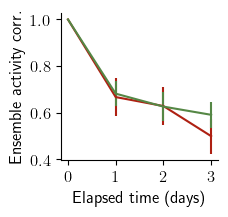

In [5708]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,50*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corrA,axis=1),stats.sem(corrA,axis = 1), color = color[8])
ax.errorbar([0,1,2,3], np.mean(corrB,axis=1),stats.sem(corrB,axis = 1), color = '#558745')
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr.pdf',bbox_inches='tight')

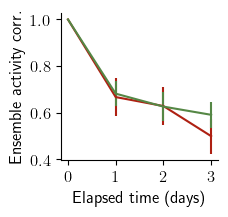

In [5709]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,50*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corrA,axis=1),stats.sem(corrA,axis = 1), color = color[8])
ax.errorbar([0,1,2,3], np.mean(corrB,axis=1),stats.sem(corrB,axis = 1), color = '#558745')
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr.pdf',bbox_inches='tight')

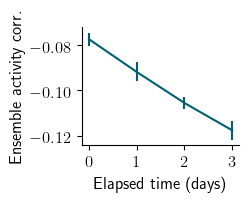

In [5710]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])


ax.errorbar([0,1,2,3], np.mean(corrAB,axis=1),stats.sem(corrAB,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_both.pdf',bbox_inches='tight')

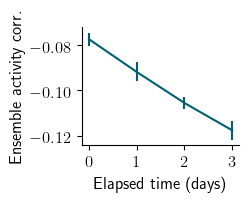

In [5711]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])


ax.errorbar([0,1,2,3], np.mean(corrAB,axis=1),stats.sem(corrAB,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_both.pdf',bbox_inches='tight')

### Ordinal time decoder, run different E, get t_mat

In [5712]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))

In [5713]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [5714]:
EL = [0,.2,.4,.6,.8,1]
EL = np.arange(0,6,1)
EL = [0]

In [5715]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))
print(L)

[[0 1 2 3]
 [0 1 3 2]
 [0 2 1 3]
 [0 2 3 1]
 [0 3 1 2]
 [0 3 2 1]
 [1 0 2 3]
 [1 0 3 2]
 [1 2 0 3]
 [1 2 3 0]
 [1 3 0 2]
 [1 3 2 0]
 [2 0 1 3]
 [2 0 3 1]
 [2 1 0 3]
 [2 1 3 0]
 [2 3 0 1]
 [2 3 1 0]
 [3 0 1 2]
 [3 0 2 1]
 [3 1 0 2]
 [3 1 2 0]
 [3 2 0 1]
 [3 2 1 0]]


In [5716]:
Nseed = 4
seedL = range(Nseed)
EL = np.arange(0,3.5,.5)
#EL = [0,1.5,3]

#Nseed = 1
#EL = [3]

In [5717]:
V_list_shuffled = np.zeros([8,N])
t_mat_A = []
t_mat_shuffled_A = []
t_mat_B = []
t_mat_shuffled_B = []

for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((E,seed))
    
     # initialisation
    np.random.seed(seed)
    random.seed(seed)
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    #ctxA = np.zeros(N) + 1
    random.shuffle(ctxA)
    ctxB = 1 - ctxA
    #ctxB = 0


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)


    # run
    y = run(INPUT)
    r = y[index[0][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V4 = r[:,14900]
    V5 = r[:,17900]
    V6 = r[:,20900]
    V7 = r[:,23900]
    
    V = np.array([V0,V1,V2,V3,V4,V5,V6,V7])
        
        
    active = r[:,2900]>threshold
    active2 = r[:,5900]>threshold
    active = np.where(active)[0]
    active2 = np.where(active2)[0]
    nonactive = [i for i in range(N) if i not in np.concatenate((active,active2))]
    
    #plot_2memories(ctx = 'A')
    #plt.show()
    #plot_2memories(ctx = 'B')
    #plt.show()
    
    

    # decoder ordinal A
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V[2*perm[i],:],V[2*perm[i+1],:])
            #print((2*perm[i],2*perm[i+1]))
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_A.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    
    
    #print(s_corr[0])
    #plt.hist(s_corr)
   # plt.show()
    
    # decoder ordinal B
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V[2*perm[i]+1,:],V[2*perm[i+1]+1,:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_B.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    
    
    
    
    #V_list_E[:,:,seed,int(np.where(np.array(EL) == E)[0])] = np.copy(V_list)
    #V_list_suffled = np.copy(V_list)
    #np.random.shuffle(V_list_suffled)
    #V_list_shuffled_E[:,:,seed,int(np.where(np.array(EL) == E)[0])] = np.copy(V_list_suffled)
    
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_suffled[:,i] = line
        
    # shuffle A
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            2*perm[i+1]
            s += correlation(V_list_suffled[2*perm[i],:],V_list_suffled[2*perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled_A.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    # shuffle B
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[2*perm[i]+1,:],V_list_suffled[2*perm[i+1]+1,:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled_B.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    
    
#np.save("V_list_E.npy", V_list_E)
#np.save("V_list_shuffled_E.npy", V_list_shuffled_E)

(0.0, 0)
0.41533174239050574
1.2026955992091968
1.3274607316956262
-1.377779924262626
(0.0, 1)
1.1979274907331536
-0.7557726676090366
-0.7161423221151234
0.8243029564454759
(0.0, 2)
-1.4701531338087446
1.271781990606382
-0.33296590276010035
0.43798525406287103
(0.0, 3)
-1.5414401299406792
0.9976243558857589
-1.0926660714235774
-0.8946681156545253
(0.5, 0)
-0.802130720386731
1.2001711255688703
1.491501770823421
-1.5780607282104055
(0.5, 1)
1.3171588164891765
1.0542310088077678
0.5883938813341941
0.8222634765497345
(0.5, 2)
1.280796361981035
-0.9421199836319548
-0.7611501436207436
0.4490286756593619
(0.5, 3)
1.552289791874561
0.6461257006679194
-0.8373387584237064
-0.2732221470406256
(1.0, 0)
-0.5949658774994888
1.082888639621538
1.514903331931413
-1.5666810801803404
(1.0, 1)
1.106914883439812
1.010386673816067
1.976130222962464
-0.9366390784316748
(1.0, 2)
1.3096905126190042
0.7688183502641937
-0.5245326147291465
-0.24728823507318873
(1.0, 3)
1.449349654600385
1.1450531904964687
-1.0558

In [5718]:
#np.save("t_mat_A.npy", t_mat_A)
#np.save("t_mat_B.npy", t_mat_B)
#np.save("t_mat_shuffled_A.npy", t_mat_shuffled_A)
#np.save("t_mat_shuffled_B.npy", t_mat_shuffled_B)
#t_mat_A = np.load("t_mat_A.npy")
#t_mat_B = np.load("t_mat_B.npy")
#t_mat_shuffled_A = np.load("t_mat_shuffled_A.npy")
#t_mat_shuffled_B = np.load("t_mat_shuffled_B.npy")

In [5719]:
t_mat_A = np.array(t_mat_A).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled_A = np.array(t_mat_shuffled_A).reshape((len(EL),len(decayL),len(seedL)))
t_mat_B = np.array(t_mat_B).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled_B = np.array(t_mat_shuffled_B).reshape((len(EL),len(decayL),len(seedL)))

decay = 0
#t_mat_A = np.abs(t_mat_A[:,decay,:])
#t_mat_shuffled_A = np.abs(t_mat_shuffled_A[:,decay,:])
#t_mat_B = np.abs(t_mat_B[:,decay,:])
#t_mat_shuffled_B = np.abs(t_mat_shuffled_B[:,decay,:])

t_mat_A = t_mat_A[:,decay,:]
t_mat_shuffled_A = t_mat_shuffled_A[:,decay,:]
t_mat_B = t_mat_B[:,decay,:]
t_mat_shuffled_B = t_mat_shuffled_B[:,decay,:]

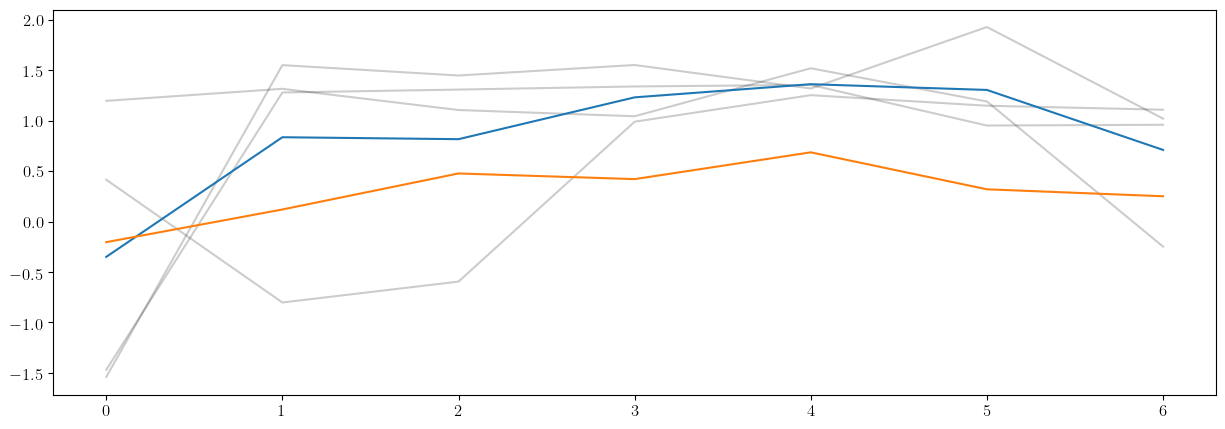

In [5720]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat_A[:,seed],'k', alpha = .2)
plt.plot(np.mean(t_mat_A,axis = 1))
plt.plot(np.mean(t_mat_shuffled_A,axis = 1))
#plt.xticks(range(len(EL)),lab);

### figure

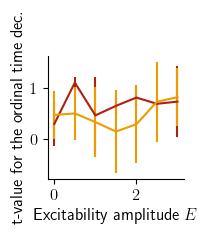

In [5832]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat_A,axis = 1),stats.sem(t_mat_A,axis = 1),color = color[8])
ax.errorbar(EL,np.mean(t_mat_shuffled_A,axis = 1),stats.sem(t_mat_shuffled_A,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0.2,2.1)

plt.savefig('tVSEa.pdf',dpi = 1000,bbox_inches='tight')



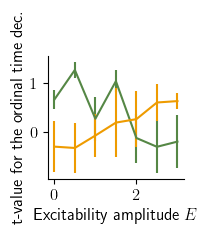

In [5831]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat_B,axis = 1),stats.sem(t_mat_B,axis = 1),color = '#558745')
ax.errorbar(EL,np.mean(t_mat_shuffled_B,axis = 1),stats.sem(t_mat_shuffled_B,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0.2,2.1)
plt.savefig('tVSEb.pdf',dpi = 1000,bbox_inches='tight')



## Revision: 2 memories with output

In [109]:
decayout = 1000

In [110]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    thetaL=np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0,Wout0))
    y = np.zeros((len(y0),nstep))
    routbis = np.zeros((4,nstep))

    y[:,0] = y0
    
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [111]:
# main function
routbis = np.zeros((4,nstep,2))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T

    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t,ctxA,seqA)[np.newaxis].T + INPUT(t,ctxB,seqB)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=cap,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    dWoutdt = np.zeros((N,2))
    for memory in range(2):
        Wout = yt[index[4]].reshape((N,2))[:,memory]
        
        rout = Wout.dot(r)[0] 
        
        if t > 1000 and t < 3000 and memory == 0:
            rout += .1
        if t > 4000 and t < 6000 and memory == 1:
            rout += .1
            
        routbis[0,t,memory] = rout

        dWoutdt[:,memory] = (1 - np.sum(Wout))*r.T * rout/200 - Wout/decayout

    
            
        dWoutdt[:,memory] = np.multiply(dWoutdt[:,memory],np.logical_not(np.logical_and(Wout<=0,dWoutdt[:,memory]<0)))




        S.append(np.sum(Wout))

        if t > 6500:
            Wout = Wout.T
            np.random.shuffle(Wout)
            Wout = Wout.T
            routbis[1,t,memory] = Wout.dot(r)[0]

        if t > 13500:
            Wout = Wout.T
            np.random.shuffle(Wout)
            Wout = Wout.T
            routbis[2,t,memory] = Wout.dot(r)[0]

        if t > 20500:
            Wout = Wout.T
            np.random.shuffle(Wout)
            Wout = Wout.T
            routbis[3,t,memory] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten()
                           ))

    return dydt

In [112]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)
Wout0 = np.zeros(N*2) + 0


In [113]:
nstep = 25000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000


seqA = []
seqB = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seqA.append(pause + i*stim + 2*delay*ev)
        seqA.append(pause + i*stim + duration + 2*delay*ev)
        
    for i in range(Nstim):
        seqB.append(pause + i*stim + delay + 2*delay*ev)
        seqB.append(pause + i*stim + duration + delay + 2*delay*ev)


def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * ctx * L/2 + 1

 

In [114]:
index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N*2)]

In [115]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:6500] = E
    Emat[20:30,6500:12500] = E
    Emat[30:40,12500:18500] = E
    Emat[40:50,18500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [116]:
#  works 2 memories previous decoder
threshold = 3

decayL = [1500]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = [1.5]
#EL = [3.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [0]
cap = 1
(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [117]:
# works well new decoder 
threshold = 5
decayL = [4000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [8]
I1L = [1]
EL = [2]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [8]
cap = 1


(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [118]:
# works
threshold = 5
decayL = [4000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [8]
I1L = [.8]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [12]
seedL = [7]
cap = 1


(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 7)


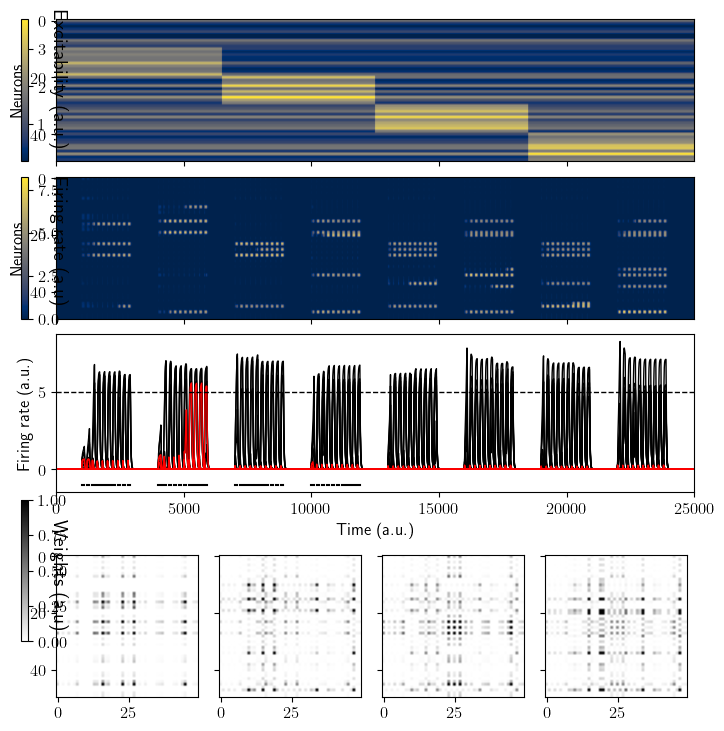

In [119]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    random.seed(seed)
    
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    ctxB = 1 - ctxA


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    
    
    plot_all()
    #plt.savefig('all.pdf')

    plt.show()
 





### figure

In [120]:
active = r[:,2850]>threshold
active2 = r[:,5850]>threshold
active = np.where(active)[0]
active2 = np.where(active2)[0]

In [121]:
np.concatenate((active,active2))

array([16, 23, 27, 45, 10, 15, 19, 47])

In [122]:
nonactive = [i for i in range(N) if i not in np.concatenate((active,active2))]

In [123]:
cmap = reversed(["20331a","33512a","446c37","558745","66a253","7cb36b","94c186","abcea1","c3dcbc","dbead7"])
cmap2 = ["ffffff","005F73"]

In [124]:
import matplotlib.colors as mcolors
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

cmap = get_continuous_cmap(cmap)
cmap2 = get_continuous_cmap(cmap2)

In [129]:
def plot_2memories(ctx = 'A'):
    mm = 1/2.54/10 
    fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
    rc('text', usetex=True)
    rc('font',**fontProperties)
    fig = plt.figure(figsize=(160*mm,160*mm), facecolor='w',frameon=False)

    ax1 = fig.add_axes([.04,.79,.88,.2]) # [left, bottom, width, height] 
    ax2 = fig.add_axes([.04,.56,.88,.2])
    ax3 = fig.add_axes([.08,.33,.8,.2])

    w = .18
    ax5 = fig.add_axes([.08,.06,w,w])
    ax6 = fig.add_axes([.285,.06,w,w])
    ax7 = fig.add_axes([.49,.06,w,w])
    ax8 = fig.add_axes([.695,.06,w,w])


    im = ax1.imshow(Emat[:,:25000],aspect = 25000/N*2/8,cmap = cmap)
    ax1.set_ylabel('Neurons')
    ax1.set_xticklabels('')
    cbar1 = plt.colorbar(im,cax = plt.axes([.9, 0.79, 0.01, 0.2])) # [left, bottom, width, height] 
    cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=-.09,x=6)

    im = ax2.imshow(r[:,:25000],aspect = 25000/N*2/8,cmap = cmap2)
    ax2.set_ylabel('Neurons')
    ax2.set_xticklabels('')
    cbar2 = plt.colorbar(im,cax = plt.axes([.9, 0.56, 0.01, 0.2])) # [left, bottom, width, height] 
    cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=-.09,x=6)

    for n in active:
        ax3.plot(r[n,:],color[8],linewidth = 1)
    for n in active2:
        ax3.plot(r[n,:],color = '#558745',linewidth = 1)
    for n in nonactive:
        ax3.plot(r[n,:],color[1],linewidth = 1)


    ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
    ax3.set_xlabel('Time (a.u.)')
    ax3.set_ylabel('Firing rate (a.u.)')

    ax3.set_xlim([0,25000])
    ax3.set_ylim([-1,9])

    h = -.5
    for s in range(int(len(seq)/2)):
        ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')

    if ctx == 'A':
        im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax6.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax7.imshow(y[index[1][:],15000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax8.imshow(y[index[1][:],21000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
    else:
        im = ax5.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax6.imshow(y[index[1][:],12000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax7.imshow(y[index[1][:],18000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax8.imshow(y[index[1][:],24000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
        
    ax6.set_yticklabels('')
    ax7.set_yticklabels('')
    ax8.set_yticklabels('')

    cbar3 = plt.colorbar(im,cax = plt.axes([.9, 0.06, 0.01, 0.18]))
    cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=-.02,x=6)
    cbar3.set_ticks([0,1])
    plt.savefig('all'+ctx+'.pdf')

IndexError: list index out of range

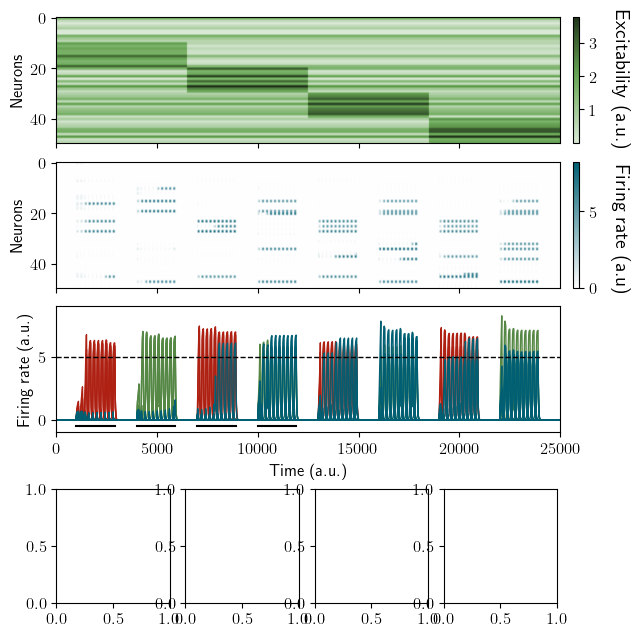

In [130]:
plot_2memories(ctx = 'A')

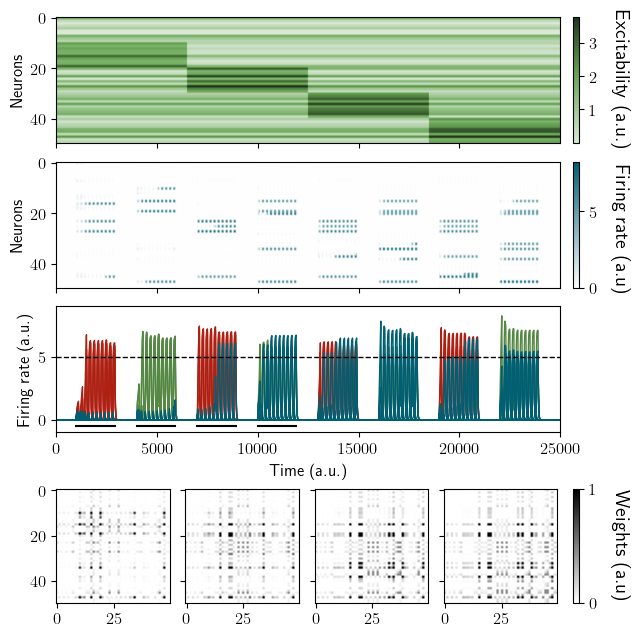

In [131]:
plot_2memories(ctx = 'B')

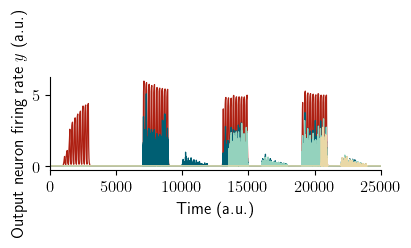

In [97]:
memory = 0

mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(100*mm,30*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.16,0.18,.84,.79])

lw = .9
ax.plot(routbis[0,:,memory],color[8] ,linewidth=lw);
ax.plot(routbis[1,:,memory],color[1],linewidth=lw);
ax.plot(routbis[2,:,memory],color[3],linewidth=lw);
ax.plot(routbis[3,:,memory],color[4],linewidth=lw);

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,25000])
plt.savefig('decode_rate_A.pdf',bbox_inches='tight')




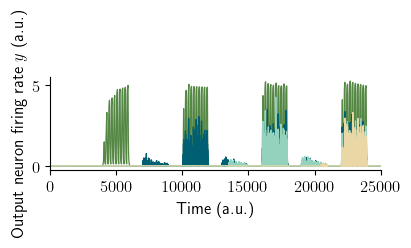

In [103]:
memory = 1

mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(100*mm,30*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.16,0.18,.84,.79])

lw = .9
ax.plot(routbis[0,:,memory],'#558745',linewidth=lw);
ax.plot(routbis[1,:,memory],color[1],linewidth=lw);
ax.plot(routbis[2,:,memory],color[3],linewidth=lw);
ax.plot(routbis[3,:,memory],color[4],linewidth=lw);

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,25000])
plt.savefig('decode_rate_B.pdf',bbox_inches='tight')




In [101]:


Wout = Wout.reshape((N,2,nstep))
WoutL = np.zeros((N,2,8))
for memory in [0,1]:
    W0 = Wout[:,memory,2900]
    W1 = Wout[:,memory,5900]
    W2 = Wout[:,memory,8900]
    W3 = Wout[:,memory,11900]
    W4 = Wout[:,memory,14900]
    W5 = Wout[:,memory,17900]
    W6 = Wout[:,memory,20900]
    W7 = Wout[:,memory,23900]
    
    WoutL[:,memory,:] = np.array([W0,W1,W2,W3,W4,W5,W6,W7]).T

V0 = r[:,2900]
V1 = r[:,5900]
V2 = r[:,8900]
V3 = r[:,11900]
V4 = r[:,14900]
V5 = r[:,17900]
V6 = r[:,20900]
V7 = r[:,23900]
V = np.array([V0,V1,V2,V3,V4,V5,V6,V7])
    

In [102]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(160*mm,70*mm), facecolor='w',frameon=False)

memory = 0
for stim in [0,2,4,6]:
    ax.plot(V[stim,:],WoutL[:,memory,stim],'.',color = color[1])
for stim in [1,3,5,7]:
    ax.plot(V[stim,:],WoutL[:,memory,stim],'.',color = color[8])
ax.set_xlim([8,11])

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,25000])
plt.savefig('decode_rate_B.pdf')

<Figure size 629.921x275.591 with 0 Axes>

In [ ]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(160*mm,70*mm), facecolor='w',frameon=False)

memory = 1
for stim in [0,2,4,6]:
    ax.plot(V[stim,:],WoutL[:,memory,stim],'.',color = color[1])
for stim in [1,3,5,7]:
    ax.plot(V[stim,:],WoutL[:,memory,stim],'.',color = color[8])
ax.set_xlim([8,11])

### figure


In [104]:
Wout = Wout.reshape((N,2,nstep))

In [105]:
pos = np.array(range(N))
pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [107]:
seedL = range(10)
track = np.zeros((len(seedL),2,8))
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(1,sigma,N)
    #exc0 = np.random.uniform(slope-sigma,slope+sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)

    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:].reshape((N,2,nstep))
    
    for memory in [0,1]:
        W0 = Wout[:,memory,2900]
        W1 = Wout[:,memory,5900]
        W2 = Wout[:,memory,8900]
        W3 = Wout[:,memory,11900]
        W4 = Wout[:,memory,14900]
        W5 = Wout[:,memory,17900]
        W6 = Wout[:,memory,20900]
        W7 = Wout[:,memory,23900]

        track[seed,memory,:] = np.array([sum(np.multiply(W0,pos))/np.sum(W0),
                                          sum(np.multiply(W1,pos))/np.sum(W1),
                                          sum(np.multiply(W2,pos))/np.sum(W2),
                                          sum(np.multiply(W3,pos))/np.sum(W3),
                                          sum(np.multiply(W4,pos))/np.sum(W4),
                                          sum(np.multiply(W5,pos))/np.sum(W5),
                                          sum(np.multiply(W6,pos))/np.sum(W6),
                                          sum(np.multiply(W7,pos))/np.sum(W7)])



(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 0)


/tmp/ipykernel_2036811/2651753439.py:37: RuntimeWarning: invalid value encountered in double_scalars
  track[seed,memory,:] = np.array([sum(np.multiply(W0,pos))/np.sum(W0),


(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 1)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 2)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 3)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 4)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 5)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 6)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 7)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 8)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 9)


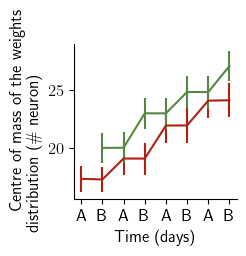

In [108]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(60*mm,50*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar(range(8),np.mean(track[:,0,:],axis=0),stats.sem(track[:,0,:]),color = color[8])
ax.errorbar(range(8),np.mean(track[:,1,:],axis=0),stats.sem(track[:,1,:]),color = '#558745')


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks(range(8))
ax.set_xticklabels(['A','B','A','B','A','B','A','B','A','B'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf',bbox_inches='tight')



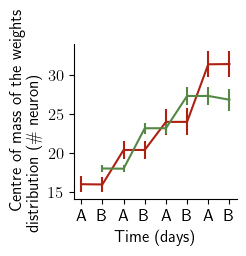

In [6108]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(60*mm,50*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar(range(8),np.mean(track[:,0,:],axis=0),stats.sem(track[:,0,:]),color = color[8])
ax.errorbar(range(8),np.mean(track[:,1,:],axis=0),stats.sem(track[:,1,:]),color = '#558745')


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks(range(8))
ax.set_xticklabels(['A','B','A','B','A','B','A','B','A','B'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf',bbox_inches='tight')



### VList and correlations

In [6109]:
Nseed = 10
V_list = np.zeros([8,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    random.seed(seed)
    
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    ctxB = 1 - ctxA


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)


    # run
    y = run(INPUT)
    r = y[index[0][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V4 = r[:,14900]
    V5 = r[:,17900]
    V6 = r[:,20900]
    V7 = r[:,23900]
    V = np.array([V0,V1,V2,V3,V4,V5,V6,V7])
    V_list[:,:,seed] = V
        
    #plot_2memories(ctx = 'A')
    #plt.show()
    #plot_2memories(ctx = 'B')
    #plt.show()
    
#np.save("V_list_2memories.npy", V_list)

0
1
2
3
4
5
6
7
8
9


In [6110]:
#V_list = np.load('V_list_2memories.npy')

In [6111]:
np.max(V_list)

8.01347216379486

In [6112]:
V_list.shape

(8, 50, 10)

In [6113]:
corrA = np.zeros((4,Nseed))
corrB = np.zeros((4,Nseed))
corrAB = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corrA[day,seed]  = correlation(V_list[0,:,seed],V_list[day*2,:,seed])
        corrB[day,seed]  = correlation(V_list[1,:,seed],V_list[day*2+1,:,seed])
        corrAB[day,seed] = correlation(V_list[day*2,:,seed],V_list[day*2+1,:,seed])

corrAB

array([[-0.11074789, -0.08647945, -0.0923531 , -0.09813994, -0.11086647,
        -0.11065728, -0.09748666, -0.10887904, -0.12291317, -0.09791372],
       [-0.09597832, -0.12184557, -0.10751118, -0.13342864, -0.10848427,
        -0.11395528, -0.09803948, -0.08344411, -0.10887401, -0.10681137],
       [-0.11943754, -0.11153307, -0.09609672, -0.12544561, -0.11862403,
        -0.13140836, -0.1201457 , -0.13288737, -0.12088529, -0.11837048],
       [-0.14395533, -0.10196154, -0.10938896, -0.13162093, -0.14522798,
        -0.13233189, -0.12131612, -0.1320283 , -0.11923768, -0.12152831]])

### figure

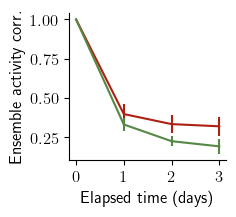

In [6114]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,50*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corrA,axis=1),stats.sem(corrA,axis = 1), color = color[8])
ax.errorbar([0,1,2,3], np.mean(corrB,axis=1),stats.sem(corrB,axis = 1), color = '#558745')
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_bis.pdf',bbox_inches='tight')

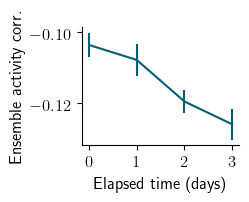

In [6115]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])


ax.errorbar([0,1,2,3], np.mean(corrAB,axis=1),stats.sem(corrAB,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_both_bis.pdf',bbox_inches='tight')

### Ordinal time decoder, run different E, get t_mat

In [6127]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))

In [6128]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [6129]:
EL = [0,.2,.4,.6,.8,1]
EL = np.arange(0,6,1)
EL = [0]

In [6130]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))
print(L)

[[0 1 2 3]
 [0 1 3 2]
 [0 2 1 3]
 [0 2 3 1]
 [0 3 1 2]
 [0 3 2 1]
 [1 0 2 3]
 [1 0 3 2]
 [1 2 0 3]
 [1 2 3 0]
 [1 3 0 2]
 [1 3 2 0]
 [2 0 1 3]
 [2 0 3 1]
 [2 1 0 3]
 [2 1 3 0]
 [2 3 0 1]
 [2 3 1 0]
 [3 0 1 2]
 [3 0 2 1]
 [3 1 0 2]
 [3 1 2 0]
 [3 2 0 1]
 [3 2 1 0]]


In [6132]:
Nseed = 10
seedL = range(Nseed)
EL = np.arange(0,3.5,.5)
#EL = [0,1.5,3]

#Nseed = 1
#EL = [3]

In [6133]:
V_list_shuffled = np.zeros([8,N])
t_mat_A = []
t_mat_shuffled_A = []
t_mat_B = []
t_mat_shuffled_B = []

for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((E,seed))
    
     # initialisation
    np.random.seed(seed)
    random.seed(seed)
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    #ctxA = np.zeros(N) + 1
    random.shuffle(ctxA)
    ctxB = 1 - ctxA
    #ctxB = 0


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)


    # run
    y = run(INPUT)
    r = y[index[0][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V4 = r[:,14900]
    V5 = r[:,17900]
    V6 = r[:,20900]
    V7 = r[:,23900]
    
    V = np.array([V0,V1,V2,V3,V4,V5,V6,V7])
        
        
    active = r[:,2900]>threshold
    active2 = r[:,5900]>threshold
    active = np.where(active)[0]
    active2 = np.where(active2)[0]
    nonactive = [i for i in range(N) if i not in np.concatenate((active,active2))]
    
    #plot_2memories(ctx = 'A')
    #plt.show()
    #plot_2memories(ctx = 'B')
    #plt.show()
    
    

    # decoder ordinal A
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V[2*perm[i],:],V[2*perm[i+1],:])
            #print((2*perm[i],2*perm[i+1]))
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_A.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    
    
    #print(s_corr[0])
    #plt.hist(s_corr)
   # plt.show()
    
    # decoder ordinal B
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V[2*perm[i]+1,:],V[2*perm[i+1]+1,:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_B.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    
    
    
    
    #V_list_E[:,:,seed,int(np.where(np.array(EL) == E)[0])] = np.copy(V_list)
    #V_list_suffled = np.copy(V_list)
    #np.random.shuffle(V_list_suffled)
    #V_list_shuffled_E[:,:,seed,int(np.where(np.array(EL) == E)[0])] = np.copy(V_list_suffled)
    
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_suffled[:,i] = line
        
    # shuffle A
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            2*perm[i+1]
            s += correlation(V_list_suffled[2*perm[i],:],V_list_suffled[2*perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled_A.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    # shuffle B
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[2*perm[i]+1,:],V_list_suffled[2*perm[i+1]+1,:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled_B.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    
    
#np.save("V_list_E.npy", V_list_E)
#np.save("V_list_shuffled_E.npy", V_list_shuffled_E)

(0.0, 0)
1.239014230430086
-1.9482483116928433
-1.1912611420258936
0.733265314029428
(0.0, 1)
0.7686369023591323
-0.9883617122124693
1.3481384980857505
0.7647980599105887
(0.0, 2)
1.1495594319464664
-0.35226404557859
1.022287731029135
0.49429211441565424
(0.0, 3)
1.6277690584296887
-0.8782915070735823
1.700889789435913
-1.443825967935003
(0.0, 4)
1.0051266739005322
1.7079198213949196
-0.40300153579373543
-0.8933645171449905
(0.0, 5)
-0.9519070036660157
0.920317030690517
1.8339425774504134
-1.040430911082389
(0.0, 6)
1.0090528348271337
1.1018299335095412
0.19867561727791794
0.0738316000093511
(0.0, 7)
1.0008680519890492
-1.3767408213243166
0.4623969761150369
0.8148740747886688
(0.0, 8)
1.237245307980755
0.9946460379162801
1.071580470861007
1.0082835189630301
(0.0, 9)
-1.826093103185041
0.9913089427955087
1.723305672871524
1.162410655768172
(0.5, 0)
-0.704050993212933
1.0707281132988888
-1.541833991744605
0.4244341479902507
(0.5, 1)
1.4936157185144172
1.6181112819209813
1.429896350106070

In [6134]:
#np.save("t_mat_A.npy", t_mat_A)
#np.save("t_mat_B.npy", t_mat_B)
#np.save("t_mat_shuffled_A.npy", t_mat_shuffled_A)
#np.save("t_mat_shuffled_B.npy", t_mat_shuffled_B)
#t_mat_A = np.load("t_mat_A.npy")
#t_mat_B = np.load("t_mat_B.npy")
#t_mat_shuffled_A = np.load("t_mat_shuffled_A.npy")
#t_mat_shuffled_B = np.load("t_mat_shuffled_B.npy")

In [6135]:
t_mat_A = np.array(t_mat_A).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled_A = np.array(t_mat_shuffled_A).reshape((len(EL),len(decayL),len(seedL)))
t_mat_B = np.array(t_mat_B).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled_B = np.array(t_mat_shuffled_B).reshape((len(EL),len(decayL),len(seedL)))

decay = 0
#t_mat_A = np.abs(t_mat_A[:,decay,:])
#t_mat_shuffled_A = np.abs(t_mat_shuffled_A[:,decay,:])
#t_mat_B = np.abs(t_mat_B[:,decay,:])
#t_mat_shuffled_B = np.abs(t_mat_shuffled_B[:,decay,:])

t_mat_A = t_mat_A[:,decay,:]
t_mat_shuffled_A = t_mat_shuffled_A[:,decay,:]
t_mat_B = t_mat_B[:,decay,:]
t_mat_shuffled_B = t_mat_shuffled_B[:,decay,:]

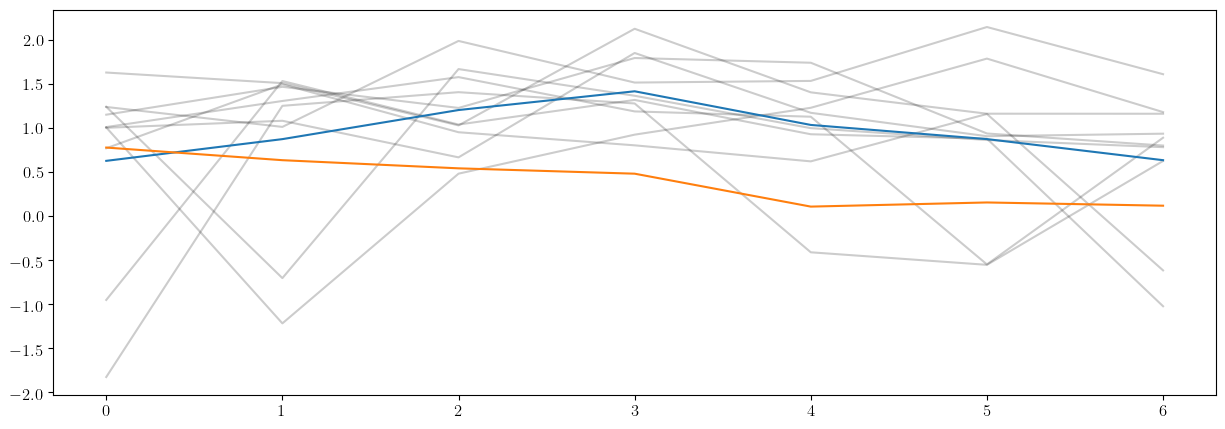

In [6136]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat_A[:,seed],'k', alpha = .2)
plt.plot(np.mean(t_mat_A,axis = 1))
plt.plot(np.mean(t_mat_shuffled_A,axis = 1))
#plt.xticks(range(len(EL)),lab);

### figure

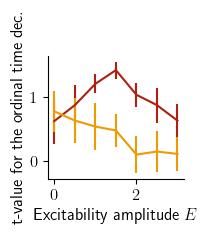

In [6140]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat_A,axis = 1),stats.sem(t_mat_A,axis = 1),color = color[8])
ax.errorbar(EL,np.mean(t_mat_shuffled_A,axis = 1),stats.sem(t_mat_shuffled_A,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0.2,2.1)

plt.savefig('tVSEa2.pdf',dpi = 1000,bbox_inches='tight')



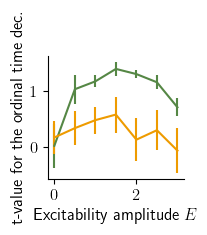

In [6139]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat_B,axis = 1),stats.sem(t_mat_B,axis = 1),color = '#558745')
ax.errorbar(EL,np.mean(t_mat_shuffled_B,axis = 1),stats.sem(t_mat_shuffled_B,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0.2,2.1)
plt.savefig('tVSEb2.pdf',dpi = 1000,bbox_inches='tight')



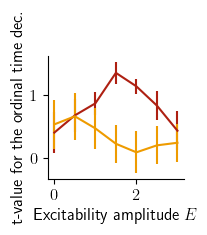

In [6075]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat_A,axis = 1),stats.sem(t_mat_A,axis = 1),color = color[8])
ax.errorbar(EL,np.mean(t_mat_shuffled_A,axis = 1),stats.sem(t_mat_shuffled_A,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0.2,2.1)

plt.savefig('tVSEa.pdf',dpi = 1000,bbox_inches='tight')



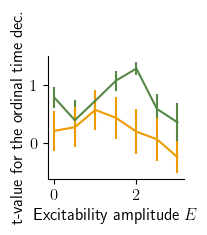

In [6076]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat_B,axis = 1),stats.sem(t_mat_B,axis = 1),color = '#558745')
ax.errorbar(EL,np.mean(t_mat_shuffled_B,axis = 1),stats.sem(t_mat_shuffled_B,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0.2,2.1)
plt.savefig('tVSEb.pdf',dpi = 1000,bbox_inches='tight')



## Revision: sigmoid instead of ReLU

In [26]:
I0

12

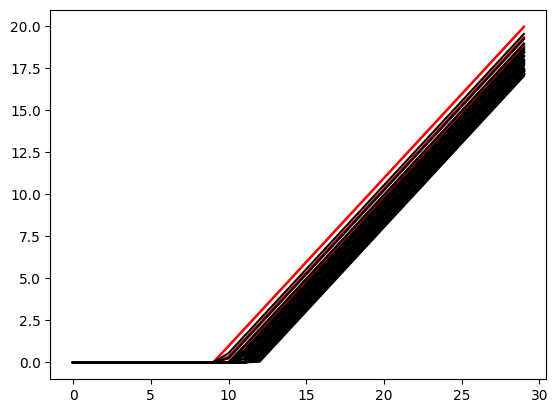

In [27]:
np.random.seed(0)
sigma = 1
E = 1.5
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)


X = np.arange(0,30)
for i in range(N):
    Y = np.maximum(0, X + exc0[i] - I0)
    plt.plot(X,Y, 'k')
    if i >=10 and i < 20:
        Y = np.maximum(0, X + exc0[i] + E - I0)
        plt.plot(X,Y, 'r')

In [28]:
I0 = 20

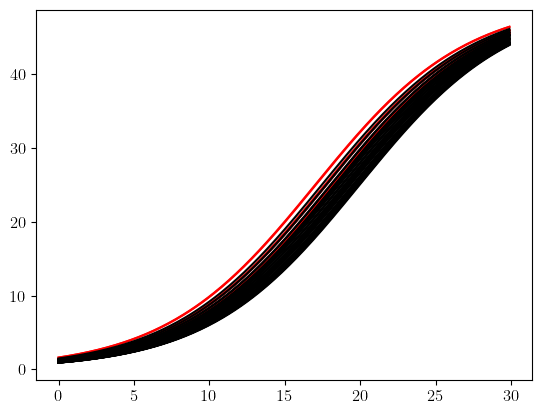

In [33]:
np.random.seed(0)
sigma = 1
E = 1.5
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)

cap = 50

slope = .1
X = np.arange(0,30,.1)
for i in range(N):
    Y = (1+np.tanh((X + exc0[i] - I0)*slope))*cap/2
    plt.plot(X,Y, 'k')
    if i >=10 and i < 20:
        Y = (1+np.tanh((X + exc0[i] + E - I0)*slope))*cap/2
        plt.plot(X,Y, 'r')

In [34]:
# main function
routbis = np.zeros((4,nstep))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    Wout = yt[index[4]].reshape((1,N))
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T
    thetaout = yt[index[6]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.2

    drdt = (-r + (1 + np.tanh((W.dot(r) + INPUT(t)[np.newaxis].T - rinhib)*slope))*cap/2 )/taur
    #drdt = (-r + np.arctan(exc) * np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib) )/taur
    #drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur


    #if t == 2050:
    #    print(W.dot(r) + INPUT(t)[np.newaxis].T - rinhib)
    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>= 1 ,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    rout = Wout.dot(r)[0]
    routbis[0,t] = rout
    dWoutdt = (1 - np.sum(Wout))*r.T * rout/200 - Wout/1000
    #dWoutdt = r.T * rout/1000 - Wout/1000
    #dWoutdt = (rout * (rout-thetaout) * r.T )/ 4000
    #dWoutdt = np.multiply(dWoutdt,Wout<10)
    dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout<=0,dWoutdt<0)))
    #dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout>=10,dWoutdt>0)))
    #droutdt = (Wout.dot(r) - rout) /1
    #dthetaoutdt = ((rout*rout)/.2 - thetaout)/10
    dthetaoutdt = np.zeros((1))
    droutdt = np.zeros((1))
    S.append(np.sum(Wout))
    
    if t > 3000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[1,t] = Wout.dot(r)[0]

    if t > 6000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[2,t] = Wout.dot(r)[0]
        
    if t > 9000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[3,t] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten(),
                           droutdt.flatten(),
                           dthetaoutdt.flatten()))

    return dydt

In [39]:
# beautiful ordinal
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [20]
I1L = [.1]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [2]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


(800, 20, 100, 20, 0.1, 1.5, 2, 1, 1000, 15, 2)


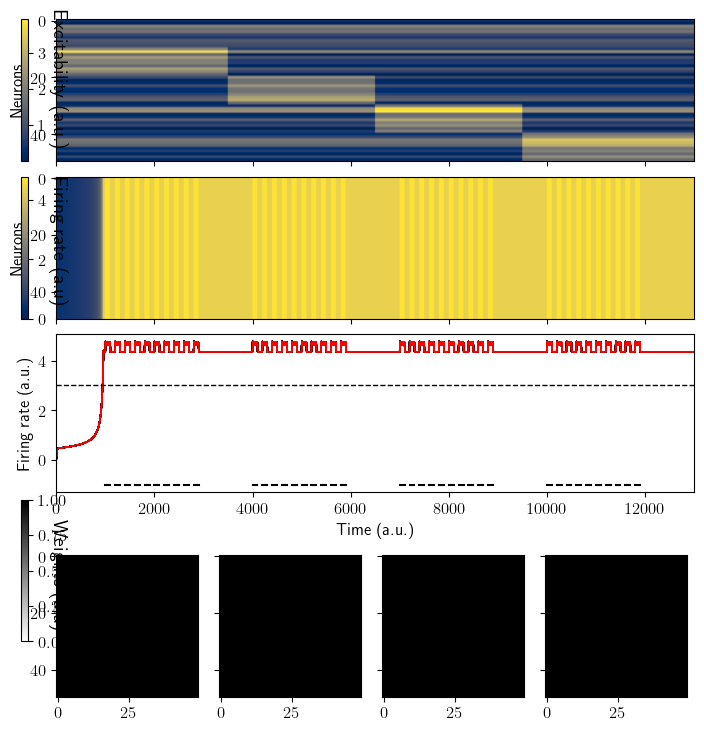

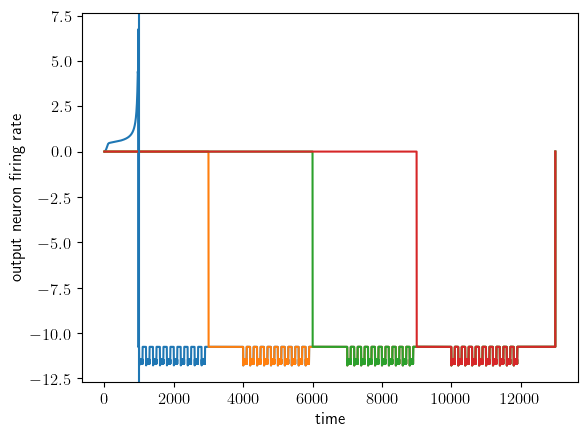

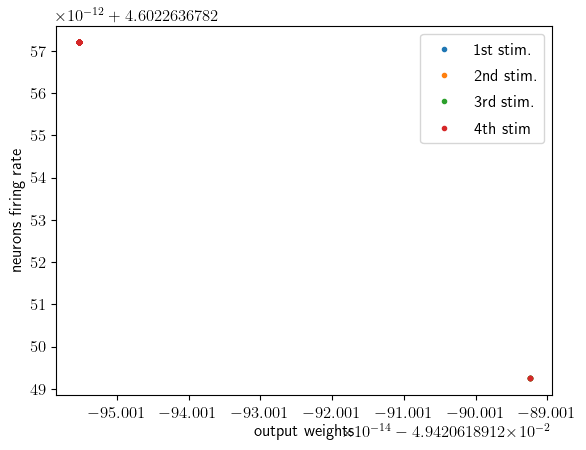

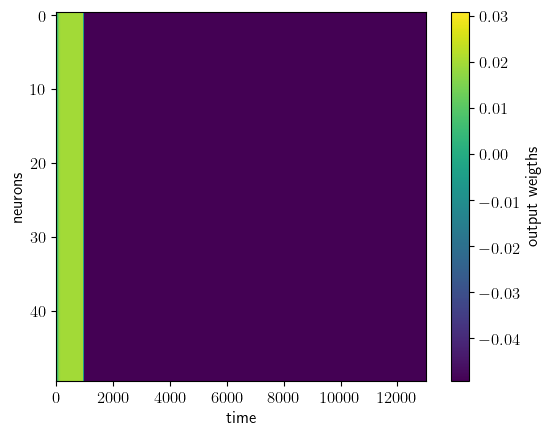

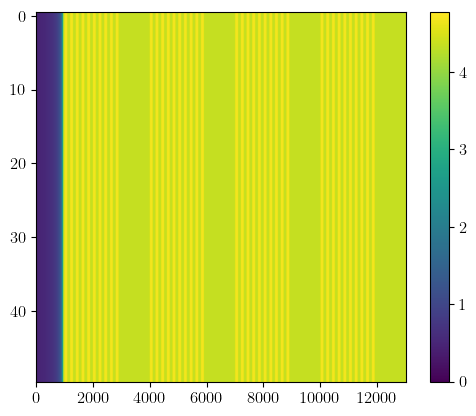

In [40]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    rout = y[index[5][:],:] 
    
    
    plot_all()
    #plt.savefig('all.pdf')

    plt.show()
    
    
    # decode memory rate
    plt.figure()
    plt.plot(routbis[0,:]);
    plt.plot(routbis[1,:]);
    plt.plot(routbis[2,:]);
    plt.plot(routbis[3,:]);
    plt.xlabel('time')
    plt.ylabel('output neuron firing rate')
    plt.axvline(x = 1000)
    plt.savefig('decode_rate.png',dpi = 500)
    plt.show()

    # weights vs rates
    for t in [2900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [5900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [8900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [11900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    plt.legend(['1st stim.','2nd stim.','3rd stim.','4th stim'])
    plt.xlabel('output weights')
    plt.ylabel('neurons firing rate')
    plt.savefig('decode_corr.png',dpi = 500)
    plt.show()

    
    # weights
    plt.figure()
    plt.imshow(Wout,aspect = nstep/N)
    cbar = plt.colorbar()
    cbar.set_label('output weigths')
    plt.ylabel('neurons')
    plt.xlabel('time')
    plt.savefig('weights.png',dpi = 500)
    plt.show()

    # rates
    plt.figure()
    plt.imshow(r,aspect = nstep/N)
    plt.colorbar()
    plt.show()





# 3 E

## figure

In [17]:
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [3]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [18]:
# beautiful ordinal
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [2]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])

In [19]:
EL = [0,1.5,3]


In [20]:
def plot_all():
    mm = 1/2.54/10 
    fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
    rc('text', usetex=True)
    rc('font',**fontProperties)
    fig = plt.figure(figsize=(180*mm,200*mm), facecolor='w',frameon=False)
    
    ax1 = fig.add_axes([.05,.7,.9,.2]) # [left, bottom, width, height] 
    ax2 = fig.add_axes([.05,.5,.9,.2])
    ax3 = fig.add_axes([.05,.29,.9,.2])


    ax5 = fig.add_axes([.05,.02,.2,.2])
    ax6 = fig.add_axes([.28,.02,.2,.2])
    ax7 = fig.add_axes([.51,.02,.2,.2])
    ax8 = fig.add_axes([.74,.02,.2,.2])
    
    



    im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
    ax6.set_yticklabels('')
    ax7.set_yticklabels('')
    ax8.set_yticklabels('')

    #cbar3 = plt.colorbar(im,cax = plt.axes([0, 0.1, 0.01, 0.18]))
    #cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=.05,x=4)
    #plt.savefig('all.pdf')

    #plt.show()

(800, 20, 100, 12, 0.5, 0, 2, 1, 1000, 15, 2)


NameError: name 'cmap' is not defined

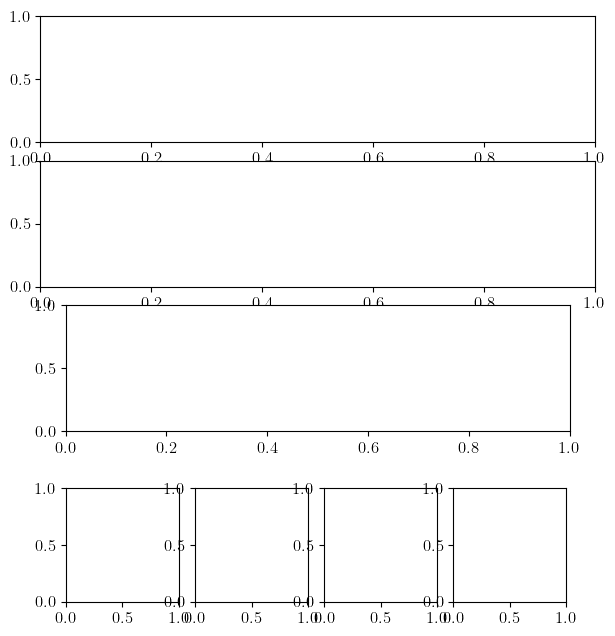

In [21]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]


        
    mm = 1/2.54/10 
    fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
    rc('text', usetex=True)
    rc('font',**fontProperties)
    fig = plt.figure(figsize=(160*mm,160*mm), facecolor='w',frameon=False)

    ax1 = fig.add_axes([.04,.79,.88,.2]) # [left, bottom, width, height] 
    ax2 = fig.add_axes([.04,.56,.88,.2])
    ax3 = fig.add_axes([.08,.33,.8,.2])

    w = .18
    ax5 = fig.add_axes([.08,.06,w,w])
    ax6 = fig.add_axes([.285,.06,w,w])
    ax7 = fig.add_axes([.49,.06,w,w])
    ax8 = fig.add_axes([.695,.06,w,w])


    im = ax1.imshow(Emat,aspect = nstep/N*2/8,cmap = cmap)
    ax1.set_ylabel('Neurons')
    ax1.set_xticklabels('')
    cbar1 = plt.colorbar(im,cax = plt.axes([.9, 0.79, 0.01, 0.2])) # [left, bottom, width, height] 
    cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=-.09,x=6)

    im = ax2.imshow(np.maximum(0,r),aspect = nstep/N*2/8,cmap = cmap2)
    ax2.set_ylabel('Neurons')
    ax2.set_xticklabels('')
    cbar2 = plt.colorbar(im,cax = plt.axes([.9, 0.56, 0.01, 0.2])) # [left, bottom, width, height] 
    cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=-.09,x=6)

    for n in active:
        ax3.plot(r[n,:],color[8],linewidth = 1)
    for n in L:
        ax3.plot(r[n,:],color[1],linewidth = 1)


    ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
    ax3.set_xlabel('Time (a.u.)')
    ax3.set_ylabel('Firing rate (a.u.)')

    ax3.set_xlim([0,nstep])
    h = -1
    for s in range(int(len(seq)/2)):
        ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


    im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
    ax6.set_yticklabels('')
    ax7.set_yticklabels('')
    ax8.set_yticklabels('')

    cbar3 = plt.colorbar(im,cax = plt.axes([.9, 0.06, 0.01, 0.18]))
    cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=-.02,x=6)
    cbar3.set_ticks([0,1])
    plt.savefig(str(E) + '.pdf')

# OLD

## Initialisation

In [981]:
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
from numpy import linalg as LA
import time
import pickle
from matplotlib import rc, font_manager
from scipy import stats
import itertools 
#from matplotlib.backends.backend_pdf import PdfPages

In [982]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    thetaL=np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0))
    y = np.zeros((len(y0),nstep))
    y[:,0] = y0
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [983]:
# main function
def f(yt,t,tag,dt):
    
    global theta
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
            
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten()))

    return dydt

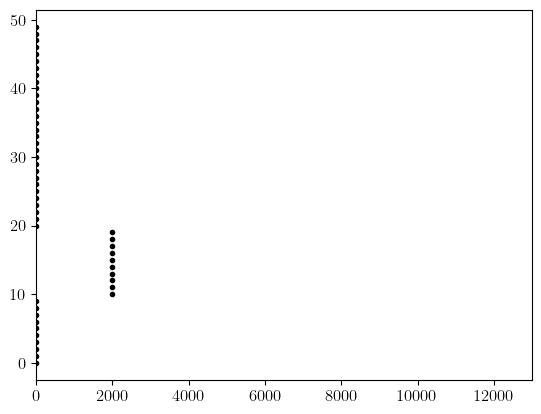

In [984]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)

nstep = 13000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000

seq = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
    
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1


tag = np.zeros(N)
 
#tag[:10] = 1
#tag[25] = 2000

#tag = np.arange(1,nstep,nstep/N)

#tag[:10] = np.arange(1,1000,100)
#tag[10:20] = np.arange(2000,3000,100)

tag[:10] = 1
tag[10:20] = 2000

plt.plot(tag,range(N),'k.')
plt.xlim([0,nstep])
index=[range(0,N),range(N,N + N*N),range(N + N*N,N + N*N +N),range(N + N*N +N,N + N*N +N+N)]

In [985]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


## Run different seeds, fixed E, get V_list

In [367]:
# works well, nice plot and ordinal decoder and decode memory
threshold = 3

decayL = [800]
tauwL = [500]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [3]

In [1028]:
def plot_all():
    mm = 1/2.54/10 
    fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
    rc('text', usetex=True)
    rc('font',**fontProperties)
    fig = plt.figure(figsize=(180*mm,200*mm), facecolor='w',frameon=False)
    
    ax1 = fig.add_axes([.05,.7,.9,.2]) # [left, bottom, width, height] 
    ax2 = fig.add_axes([.05,.5,.9,.2])
    ax3 = fig.add_axes([.05,.29,.9,.2])


    ax5 = fig.add_axes([.05,.02,.2,.2])
    ax6 = fig.add_axes([.28,.02,.2,.2])
    ax7 = fig.add_axes([.51,.02,.2,.2])
    ax8 = fig.add_axes([.74,.02,.2,.2])
    
    
    im = ax1.imshow(Emat,aspect = nstep/N*2/9,cmap = 'cividis')
    ax1.set_ylabel('Neurons')
    ax1.set_xticklabels('')
    cbar1 = plt.colorbar(im,cax = plt.axes([0, 0.71, 0.01, 0.18]))
    cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=.05,x=4)
    
    im = ax2.imshow(np.maximum(0,r),aspect = nstep/N*2/9,cmap = 'cividis')
    ax2.set_ylabel('Neurons')
    ax2.set_xticklabels('')
    cbar2 = plt.colorbar(im,cax = plt.axes([0, 0.51, 0.01, 0.18]))
    cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.05,x=4)

        
    for n in range(N):
        ax3.plot(r[n,:],'k',linewidth = 1)
    for n in range(10,15):
        ax3.plot(r[n,:],'r',linewidth = 1)
        
    ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
    ax3.set_xlabel('Time (a.u.)')
    ax3.set_ylabel('Firing rate (a.u.)')
    
    ax3.set_xlim([0,nstep])
    h = -1
    for s in range(int(len(seq)/2)):
        ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


    im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
    ax6.set_yticklabels('')
    ax7.set_yticklabels('')
    ax8.set_yticklabels('')

    cbar3 = plt.colorbar(im,cax = plt.axes([0, 0.1, 0.01, 0.18]))
    cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=.05,x=4)
    #plt.savefig('all.pdf')

    #plt.show()

In [1029]:
Nseed = 100
V_list = np.zeros([4,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V
        
    plot_all()

0
1
2


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa79c016af0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
#np.save("V_list.npy", V_list)
V_list = np.load('V_list.npy')

In [ ]:
#V_list = np.load('V_list.npy')

In [ ]:
corr_tot = np.zeros((4,10))
for day in range(4):
    for seed in range(10):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])

corr_tot

In [ ]:
for seed in range(10):
    plt.plot(corr_tot[:,seed],'k', alpha = .5)

In [ ]:
plt.errorbar([0,1,2,3], np.mean(corr_tot,axis=1),stats.sem(corr_tot,axis = 1))
plt.xlabel('elapsed time (days)')
plt.ylabel('Ensemble activity correlation')
plt.savefig('decay_corr.pdf')

## Ordinal time decoder, run different E, get t_mat

In [ ]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))
print(L)

In [ ]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [35]:
# works well, nice plot and ordinal decoder and decode memory
threshold = 3

decayL = [800]
tauwL = [500]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
#EL = [1.5]
EL = [0,.5,1,1.5,2,2.5,3]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)
Nseed = len(seedL)

In [1010]:
threshold = 3

decayL = [800]
tauwL = [600]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [ ]:
t_mat = []
t_mat_shuffled = []
V_list = np.zeros([4,N,Nseed])
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]

    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V

    np.save("V_list.npy", V_list)


    # decoder ordinal
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list[perm[i],:],V_list[perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    # shuffle
    
    V_list_suffled = np.copy(V_list)
    np.random.shuffle(V_list_suffled)
   # print(V_list)
    #print(V_list_suffled)
    
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[perm[i],:],V_list_suffled[perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    #plot_all()
    #plt.savefig(str(E)+'all.pdf')

    plt.show()
    




In [370]:
t_mat = np.array(t_mat).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled = np.array(t_mat_shuffled).reshape((len(EL),len(decayL),len(seedL)))

decay = 0
t_mat = np.abs(t_mat[:,decay,:])
t_mat_shuffled = np.abs(t_mat_shuffled[:,decay,:])

ValueError: cannot reshape array of size 70 into shape (1,1,1)

In [38]:
lab = [str(round(idx,2)) for idx in EL]


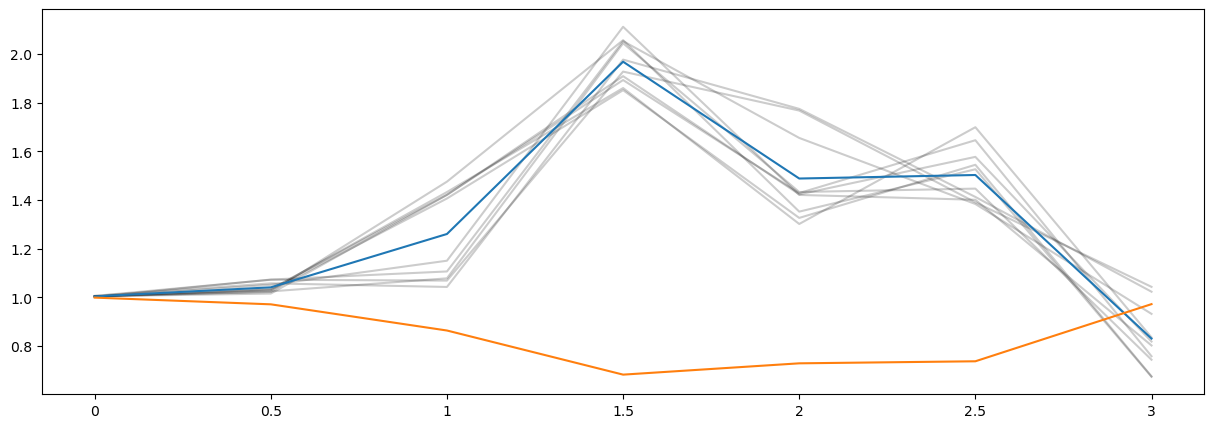

In [39]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat[:,seed],'k', alpha = .2)
plt.plot(np.mean(t_mat,axis = 1))
plt.plot(np.mean(t_mat_shuffled,axis = 1))
plt.xticks(range(len(EL)),lab);

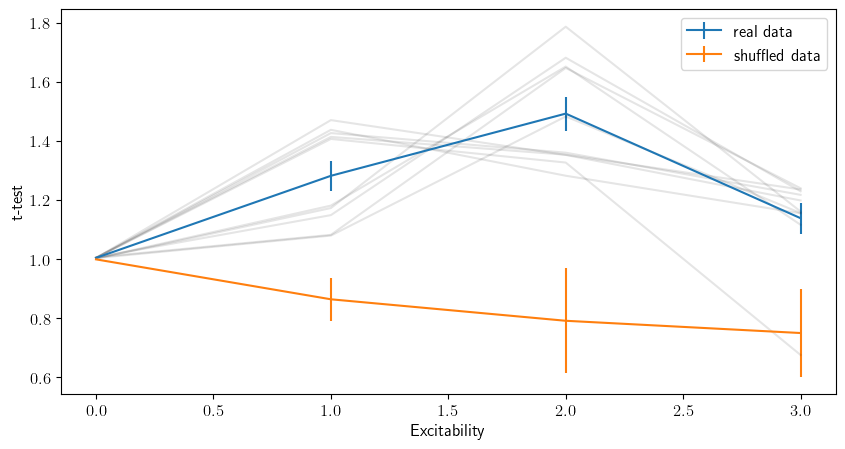

In [271]:
Nseed = len(seedL)
plt.figure(figsize = (10,5))
plt.errorbar(EL,np.mean(t_mat,axis = 1),stats.sem(t_mat,axis = 1))

    
plt.errorbar(EL,np.mean(t_mat_shuffled,axis = 1),stats.sem(t_mat_shuffled,axis = 1))
plt.ylabel('t-test')
plt.xlabel('Excitability')
plt.legend(['real data','shuffled data'])
for seed in range(Nseed):
    plt.plot(EL,t_mat[:,seed],'k', alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],'k', alpha = .1)
plt.savefig('tVSE.pdf',dpi = 1000)



In [2759]:
t_mat[e,seed]

1.1579486749210786

In [2760]:
p_mat = np.copy(t_mat)
p_mat_shuffled = np.copy(t_mat_shuffled)
import scipy
for seed in range(Nseed):
    for e in range(len(EL)):
        p_mat[e,seed] = scipy.stats.t.sf(t_mat[e,seed], df=Nseed-1)
        p_mat_shuffled[e,seed] = scipy.stats.t.sf(t_mat_shuffled[e,seed], df=Nseed-1)

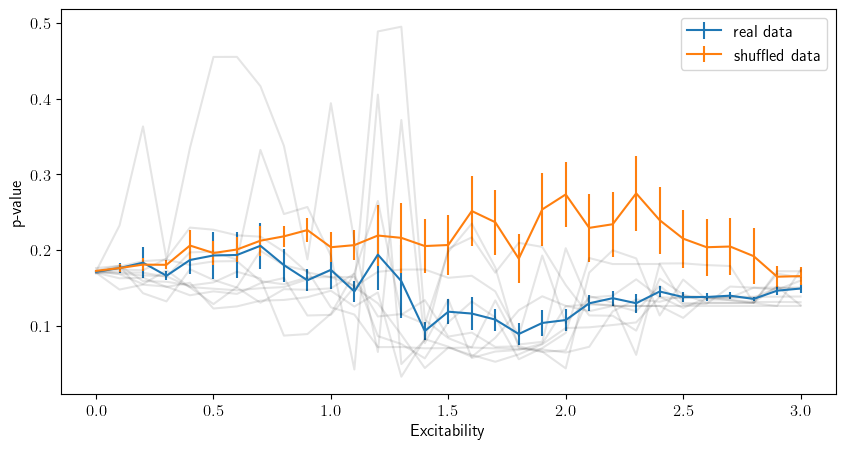

In [2761]:
Nseed = len(seedL)
plt.figure(figsize = (10,5))
plt.errorbar(EL,np.mean(p_mat,axis = 1),stats.sem(p_mat,axis = 1))
plt.errorbar(EL,np.mean(p_mat_shuffled,axis = 1),stats.sem(p_mat_shuffled,axis = 1))
plt.ylabel('p-value')
plt.xlabel('Excitability')
plt.legend(['real data','shuffled data'])
for seed in range(Nseed):
    plt.plot(EL,p_mat[:,seed],'k', alpha = .1)
plt.savefig('pVSE.png',dpi = 1000)



## Time decoder

In [305]:
# works well, nice plot and ordinal decoder and decode memory
threshold = 3

decayL = [800]
tauwL = [500]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

In [1497]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [1498]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:12500] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [1499]:
# main function
def f(yt,t,tag,dt):
    
    global theta
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))

    if t > pause + Nstim*stim + duration + delay*(Nevent-1):
        dWdt = np.zeros((N,N))
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
            
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten()))

    return dydt

In [1500]:
pause + Nstim*stim + duration + delay*(Nevent-1)

12100

In [1504]:
Nseed = 10
V_list = np.zeros([Nseed,2,4,N])
for seed in range(Nseed):
    print(seed)
    np.random.seed(seed)
    
    for day in range(4):
        nstep = 14000
        dt = 1
        IN = 15
        Nstim = 10
        stim = 200
        duration = 100
        pause = 1000
        delay = 3000

        seq = []
        Nevent = day + 1

        for ev in range(Nevent):

            for i in range(Nstim):
                seq.append(pause + i*stim + delay*ev)
                seq.append(pause + i*stim + duration + delay*ev)

        seq.append(13000)
        seq.append(13000 + duration)

        def INPUT(t):
            L = 0
            pol = 1
            for step in seq:
                L += np.tanh(t-step)*pol
                pol *= -1
            return IN * np.ones(N)*L/2 + 1




        ############ RUN ##############



         # initialisation
        r0 = np.zeros(N)
        W0 = np.zeros(N*N)
        exc0 = np.zeros(N)
        exc0 = np.random.normal(0,sigma,N)
        exc0 = np.sqrt(exc0*exc0)
        #exc0 = np.random.uniform(0,sigma,N)
        theta0 = np.zeros(N)

        Emat = def_Emat(E,exc0)

        # run
        y = run(INPUT)
        exc = y[index[2][:],:]
        r = y[index[0][:],:]
        theta = y[index[3][:],:]

        V_list[seed,0,day,:] =  r[:,pause + Nstim*stim + delay*day - 100]
        V_list[seed,1,day,:] =  r[:,13100]

        #plot_all()
        


0
1
2
3
4
5
6
7
8
9


In [1505]:
decod = np.zeros((Nseed,4))
for seed in range(Nseed):
    for day in range(4):
        corr = []
        for day_try in range(4):
            corr.append(correlation(V_list[seed,0,day,:],V_list[seed,1,day_try,:]))
    
        decod[seed,day] = np.where(corr == np.max(corr))[0]
decod

array([[0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.]])

In [1513]:
V_list_shuffled = np.copy(V_list)

decod_shuffled = np.zeros((Nseed,4))
for seed in range(10):
    V = np.copy(V_list_shuffled[seed,1,:,:])
    np.random.shuffle(V)
    V_list_shuffled[seed,1,:,:] = V
    
    for day in range(4):
        corr = []
        for day_try in range(4):
            corr.append(correlation(V_list_shuffled[seed,1,day,:],V_list_shuffled[seed,0,day_try,:]))
        #print(corr)
        decod_shuffled[seed,day] = np.where(corr == np.max(corr))[0]
decod_shuffled

array([[3., 1., 0., 2.],
       [2., 0., 1., 3.],
       [3., 2., 1., 0.],
       [3., 2., 1., 0.],
       [0., 1., 2., 3.],
       [2., 1., 3., 0.],
       [0., 1., 3., 2.],
       [1., 3., 0., 2.],
       [3., 1., 0., 2.],
       [3., 1., 2., 0.]])

In [1515]:
error = np.zeros([Nseed,4])
error_shuffled = np.zeros([Nseed,4])
for seed in range(Nseed):
    error[seed,:] = decod[seed,:] - np.arange(4)
    error_shuffled[seed,:] = decod_shuffled[seed,:] - np.arange(4)

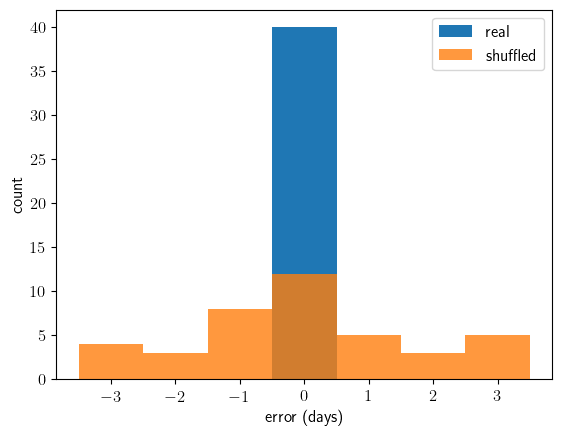

In [1529]:
plt.hist(error.flatten(),bins = np.arange(-3.5,4.5,1),alpha = 1)
plt.hist(error_shuffled.flatten(),bins = np.arange(-3.5,4.5,1),alpha = .8)
plt.legend(['real','shuffled'])
plt.ylabel('count')
plt.xlabel('error (days)')
plt.savefig('TimeDecoder.png',dpi = 500)


## Memory decoder

In [371]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    thetaL=np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0,Wout0,rout0,thetaout0))
    y = np.zeros((len(y0),nstep))
    routbis = np.zeros((4,nstep))

    y[:,0] = y0
    
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [372]:
# main function
routbis = np.zeros((4,nstep))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    Wout = yt[index[4]].reshape((1,N))
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T
    thetaout = yt[index[6]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    rout = Wout.dot(r)[0]
    routbis[0,t] = rout
    dWoutdt = (.5 - np.sum(Wout))*r.T * rout/500 - Wout/1000
    #dWoutdt = (rout * (rout-thetaout) * r.T )/ 4000
    #dWoutdt = np.multiply(dWoutdt,Wout<10)
    #dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout<=0,dWoutdt<0)))
    #droutdt = (Wout.dot(r) - rout) /1
    #dthetaoutdt = ((rout*rout)/.2 - thetaout)/10
    dthetaoutdt = np.zeros((1))
    droutdt = np.zeros((1))
    S.append(np.sum(Wout))
    
    if t > 3000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[1,t] = Wout.dot(r)[0]

    if t > 6000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[2,t] = Wout.dot(r)[0]
        
    if t > 9000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[3,t] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten(),
                           droutdt.flatten(),
                           dthetaoutdt.flatten()))

    return dydt

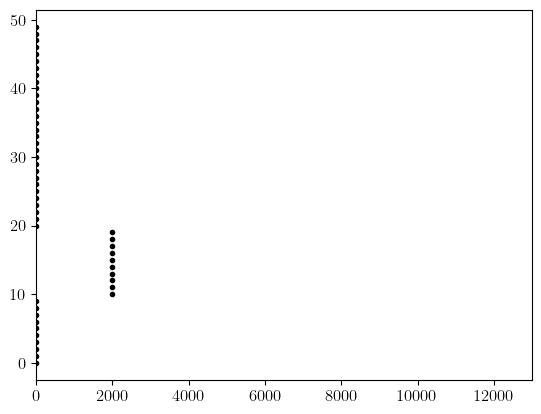

In [373]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)
rout0 = np.zeros(1)
Wout0 = np.zeros(N) + .001
thetaout0 = np.zeros(1)

nstep = 13000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000

seq = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
    
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1


tag = np.zeros(N)
 
#tag[:10] = 1
#tag[25] = 2000

#tag = np.arange(1,nstep,nstep/N)

#tag[:10] = np.arange(1,1000,100)
#tag[10:20] = np.arange(2000,3000,100)

tag[:10] = 1
tag[10:20] = 2000

plt.plot(tag,range(N),'k.')
plt.xlim([0,nstep])
         
index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N),
         range(N + N*N +N+N+N,N + N*N +N+N+N+1),
         range(N + N*N +N+N+N+1,N + N*N +N+N+N+1+1)]
         
         
         
         
         

In [374]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [375]:
# works well, nice plot and ordinal decoder and decode memory
threshold = 3

decayL = [800]
tauwL = [500]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [3]

(500, 20, 100, 12, 0.5, 1.5, 2, 1, 800, 15, 3)


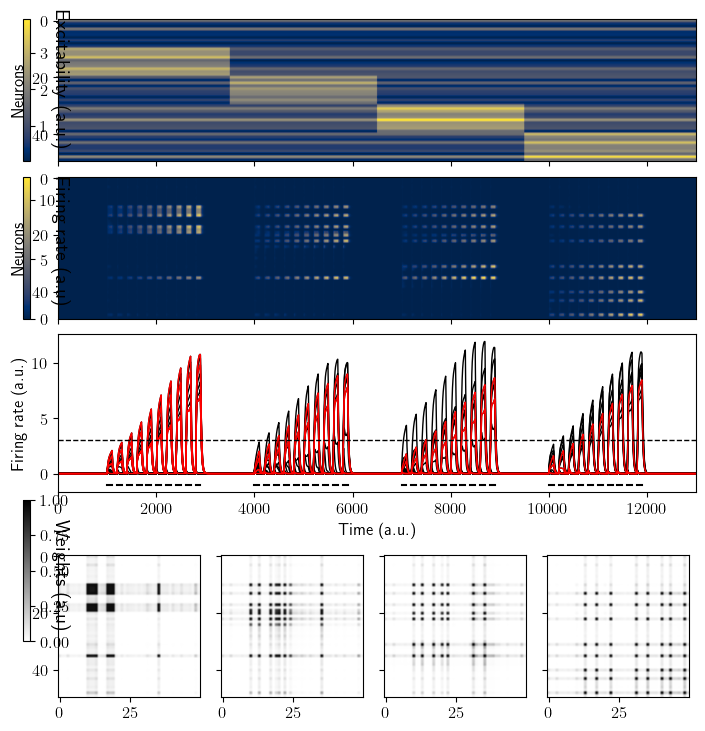

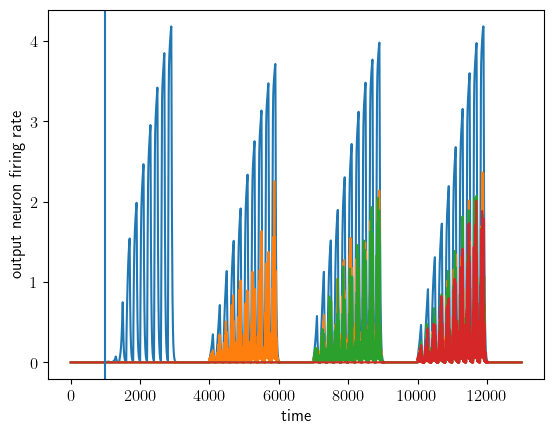

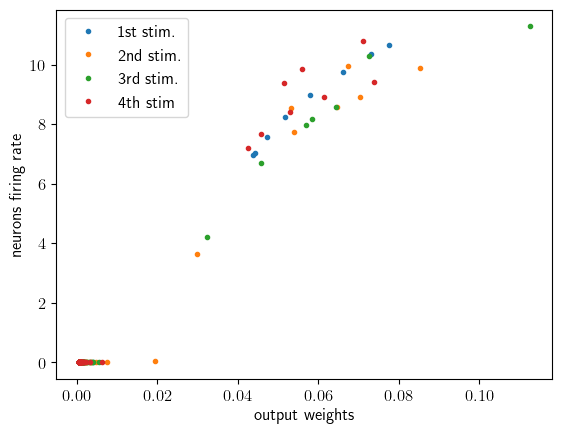

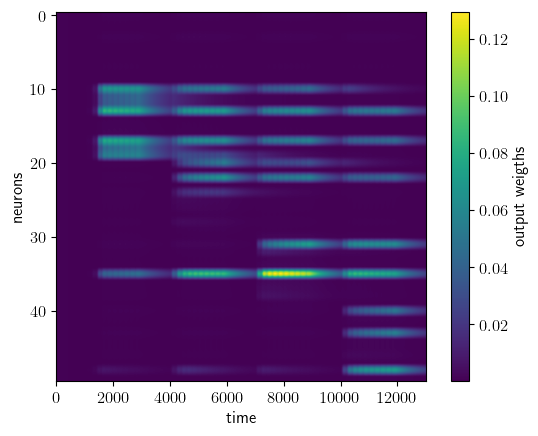

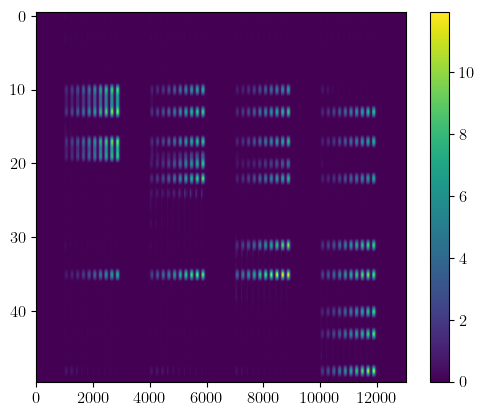

In [376]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    rout = y[index[5][:],:] 
    
    
    plot_all()
    #plt.savefig('all.pdf')

    plt.show()
    
    
    # decode memory rate
    plt.figure()
    plt.plot(routbis[0,:]);
    plt.plot(routbis[1,:]);
    plt.plot(routbis[2,:]);
    plt.plot(routbis[3,:]);
    plt.xlabel('time')
    plt.ylabel('output neuron firing rate')
    plt.axvline(x = 1000)
    plt.savefig('decode_rate.png',dpi = 500)
    plt.show()

    # weights vs rates
    for t in [2900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [5900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [8900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [11900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    plt.legend(['1st stim.','2nd stim.','3rd stim.','4th stim'])
    plt.xlabel('output weights')
    plt.ylabel('neurons firing rate')
    plt.savefig('decode_corr.png',dpi = 500)
    plt.show()

    
    # weights
    plt.figure()
    plt.imshow(Wout,aspect = nstep/N)
    cbar = plt.colorbar()
    cbar.set_label('output weigths')
    plt.ylabel('neurons')
    plt.xlabel('time')
    plt.savefig('weights.png',dpi = 500)
    plt.show()

    # rates
    plt.figure()
    plt.imshow(r,aspect = nstep/N)
    plt.colorbar()
    plt.show()





In [ ]:
plt.plot(S)

In [ ]:
plt.figure()
plt.plot(routbis[0,:]);
plt.plot(routbis[1,:]);
plt.plot(routbis[2,:]);
plt.plot(routbis[3,:]);

#plt.yscale('log')
plt.xlabel('time')
plt.ylabel('output neuron firing rate')
plt.savefig('decode_rate.png',dpi = 500)

In [ ]:
#for t in range(nstep):
for t in [2900]:
    plt.plot(Wout[:,t],r[:,t],'.')
for t in [5900]:
    plt.plot(Wout[:,t],r[:,t],'.')
for t in [8900]:
    plt.plot(Wout[:,t],r[:,t],'.')
for t in [11900]:
    plt.plot(Wout[:,t],r[:,t],'.')

plt.legend(['1st stim.','2nd stim.','3rd stim.','4th stim'])
plt.xlabel('output weights')
plt.ylabel('neurons firing rate')
plt.savefig('decode_corr.png',dpi = 500)

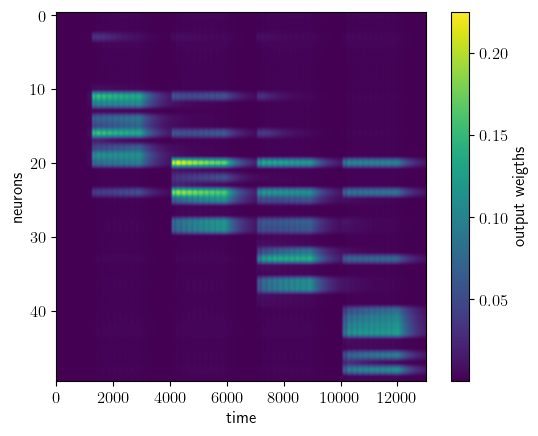

In [2341]:
plt.figure()
plt.imshow(Wout,aspect = nstep/N)
cbar = plt.colorbar()
cbar.set_label('output weigths')
plt.ylabel('neurons')
plt.xlabel('time')

plt.savefig('weights.png',dpi = 500)

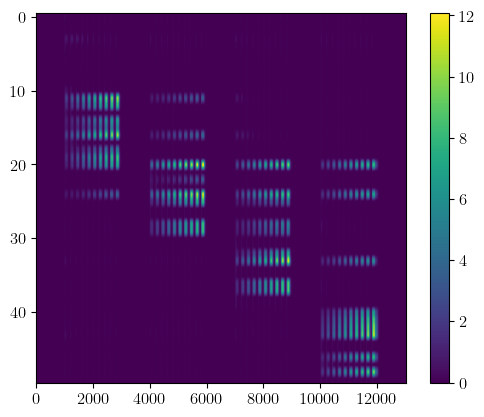

In [2342]:
plt.figure()
plt.imshow(r,aspect = nstep/N)
plt.colorbar()

In [2343]:
r[:,2900]

array([2.10238039e-03, 1.34656819e-03, 1.53963886e-03, 3.75326650e-03,
       2.22433333e-03, 1.53915171e-03, 1.53008009e-03, 1.26351825e-03,
       1.24744725e-03, 1.35005333e-03, 2.77340543e-03, 1.07628571e+01,
       8.56189164e+00, 2.71825870e-03, 6.89945658e+00, 5.64505436e+00,
       1.08717607e+01, 2.99581314e-03, 5.23180775e+00, 8.91606617e+00,
       7.61846835e+00, 1.43115882e-03, 1.50150473e-03, 1.46070455e-03,
       3.43299773e+00, 1.83237613e-03, 1.22826671e-03, 1.27547864e-03,
       1.89049799e-03, 1.84348739e-03, 1.26471683e-03, 1.33922662e-03,
       1.50929570e-03, 2.42992404e-03, 1.32912921e-03, 1.26518472e-03,
       1.66641885e-03, 1.64589674e-03, 1.34228557e-03, 1.31390463e-03,
       1.56293139e-03, 1.80693185e-03, 2.03817669e-03, 2.37432190e-03,
       1.38311128e-03, 1.35922419e-03, 1.68306235e-03, 1.47249251e-03,
       1.95110537e-03, 1.28401022e-03])